## 1. Εγκατάσταση και Εισαγωγή Βιβλιοθηκών
## 1. Setup and Import Libraries

Εισάγουμε όλες τις απαραίτητες βιβλιοθήκες για την πλήρη pipeline:  
We import all necessary libraries for the complete pipeline:

In [1]:
# Βασικές Βιβλιοθήκες Δεδομένων (Core Data Libraries)
import os
import warnings
import pickle
from datetime import datetime

import numpy as np
import pandas as pd

# Μηχανική Μάθηση (Machine Learning)
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.decomposition import PCA
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Επεξεργασία Σήματος (Signal Processing)
from scipy.ndimage import gaussian_filter1d

# Οπτικοποίηση (Visualization)
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# API Requests
import requests

# Χειρισμός Ημερομηνιών (Date Handling)
from dateutil.relativedelta import relativedelta

# Ρυθμίσεις (Settings)
warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8-darkgrid')
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)

print("✓ Όλες οι βιβλιοθήκες φορτώθηκαν επιτυχώς!")
print("✓ All libraries loaded successfully!")

✓ Όλες οι βιβλιοθήκες φορτώθηκαν επιτυχώς!
✓ All libraries loaded successfully!


### Ρύθμιση API Key (API Key Configuration)

Φορτώνουμε το Alpha Vantage API key από το αρχείο `.env`.  
Αν δεν έχετε API key, εγγραφείτε δωρεάν στο: https://www.alphavantage.co/support/#api-key

We load the Alpha Vantage API key from the `.env` file.  
If you don't have an API key, sign up for free at: https://www.alphavantage.co/support/#api-key

In [2]:
def load_api_key():
    """
    Φορτώνει το Alpha Vantage API key από το αρχείο .env.
    Loads the Alpha Vantage API key from the .env file.
    
    Returns:
        str: API key για την υπηρεσία Alpha Vantage (API key for Alpha Vantage service)
    """
    try:
        with open(".env", "r") as f:
            for line in f:
                if line.startswith("api_key="):
                    return line.strip().split("=", 1)[1]
        raise ValueError("API key not found in .env file")
    except FileNotFoundError:
        print("⚠️  Το αρχείο .env δεν βρέθηκε! (.env file not found!)")
        print("Παρακαλώ δημιουργήστε ένα αρχείο .env με: (Please create a .env file with:)")
        print("api_key=your_key_here")
        raise

# Φόρτωση API Key (Load API Key)
API_KEY = load_api_key()
print(f"✓ API Key φορτώθηκε επιτυχώς! (API Key loaded successfully!)")
print(f"  Key: {API_KEY[:8]}...{API_KEY[-4:]}")

✓ API Key φορτώθηκε επιτυχώς! (API Key loaded successfully!)
  Key: JHC8CKJE...1KFV


### Δημιουργία Δομής Φακέλων (Create Directory Structure)

Δημιουργούμε τους απαραίτητους φακέλους για αποθήκευση αποτελεσμάτων:  
We create the necessary folders for storing results:

In [3]:
# Δημιουργία φακέλων (Create directories)
os.makedirs("data", exist_ok=True)
os.makedirs("features", exist_ok=True)
os.makedirs("models", exist_ok=True)
os.makedirs("results", exist_ok=True)

print("✓ Δομή φακέλων δημιουργήθηκε! (Directory structure created!)")
print("  - data/")
print("  - features/")
print("  - models/")
print("  - results/")

✓ Δομή φακέλων δημιουργήθηκε! (Directory structure created!)
  - data/
  - features/
  - models/
  - results/


---

## ΒΗΜΑ 1: ΣΥΛΛΟΓΗ ΔΕΔΟΜΕΝΩΝ ΚΑΙ ΠΡΟΕΠΕΞΕΡΓΑΣΙΑ
## STEP 1: DATA ACQUISITION AND PREPROCESSING

### Περιγραφή (Description)

Σε αυτό το βήμα:  
In this step:

1. Ανακτούμε ιστορικά ημερήσια δεδομένα μετοχών από Alpha Vantage API για NFLX
   - Fetch historical daily stock data from Alpha Vantage API for NFLX
   
2. Μετατρέπουμε ημερήσια δεδομένα σε **μηνιαίους μέσους όρους**
   - Convert daily data to **monthly averages**
   - Τιμή Κλεισίματος (Close Price) & Όγκος (Volume)
   
3. Εφαρμόζουμε **Gaussian smoothing** με 4 διαφορετικές τιμές σ:
   - Apply **Gaussian smoothing** with 4 different σ values:
   - σ=0 (raw): Χωρίς εξομάλυνση (No smoothing)
   - σ=1: Ελαφριά εξομάλυνση (Light smoothing)
   - σ=2: Μέτρια εξομάλυνση (Moderate smoothing)
   - σ=3: Έντονη εξομάλυνση (Heavy smoothing)

### Μαθηματικό Υπόβαθρο Gaussian Smoothing
### Mathematical Background of Gaussian Smoothing

Το Gaussian φίλτρο είναι ένας **σταθμισμένος κινητός μέσος** με Gaussian βάρη:  
The Gaussian filter is a **weighted moving average** with Gaussian weights:

$$w(x) = \frac{1}{\sqrt{2\pi\sigma^2}} e^{-\frac{x^2}{2\sigma^2}}$$

Όπου (Where):
- σ (sigma): Τυπική απόκλιση - ελέγχει το εύρος εξομάλυνσης (Standard deviation - controls smoothing width)
- Μεγαλύτερο σ → Περισσότερη εξομάλυνση (Larger σ → More smoothing)

**Πλεονεκτήματα (Benefits)**:
- Μειώνει θόρυβο υψηλής συχνότητας (Reduces high-frequency noise)
- Διατηρεί γενικές τάσεις (Preserves overall trends)
- Προετοιμάζει δεδομένα για μοντελοποίηση (Prepares data for modeling)

### 1.1 Συναρτήσεις Ανάκτησης Δεδομένων (Data Acquisition Functions)

In [4]:
def fetch_stock_data(symbol, api_key):
    """
    Ανακτά ημερήσια ιστορικά δεδομένα μετοχών από Alpha Vantage API.
    Fetches daily historical stock data from Alpha Vantage API.
    
    Args:
        symbol (str): Σύμβολο μετοχής (Stock ticker symbol) (e.g., 'NFLX')
        api_key (str): Alpha Vantage API key
    
    Returns:
        dict: JSON απόκριση που περιέχει χρονοσειρές δεδομένων
              JSON response containing time series data
    
    Σημειώσεις (Notes):
        - Χρησιμοποιεί TIME_SERIES_DAILY για ημερήσια δεδομένα OHLCV
          Uses TIME_SERIES_DAILY function to get daily OHLCV data
        - outputsize=full ανακτά 20+ χρόνια ιστορικών δεδομένων
          outputsize=full retrieves 20+ years of historical data
        - Δωρεάν tier έχει όρια (5 κλήσεις/λεπτό, 500/ημέρα)
          Free tier has rate limits (5 API calls per minute, 500 per day)
    """
    print(f"Ανακτώνται ιστορικά δεδομένα για (Fetching historical data for) {symbol}...")
    url = f"https://www.alphavantage.co/query?function=TIME_SERIES_DAILY&symbol={symbol}&outputsize=full&apikey={api_key}"
    
    try:
        response = requests.get(url, timeout=30)
        response.raise_for_status()
        data = response.json()
        
        if "Error Message" in data:
            raise ValueError(f"API Error: {data['Error Message']}")
        if "Note" in data:
            raise ValueError(f"API Rate Limit: {data['Note']}")
        
        print(f"✓ Δεδομένα ανακτήθηκαν επιτυχώς! (Data fetched successfully!)")
        return data
    
    except requests.exceptions.RequestException as e:
        print(f"❌ Σφάλμα κατά την ανάκτηση δεδομένων (Error fetching data): {e}")
        raise

In [5]:
def convert_to_daily_dataframe(json_data):
    """
    Μετατρέπει την JSON απόκριση του Alpha Vantage σε pandas DataFrame με ημερήσια δεδομένα.
    Converts Alpha Vantage JSON response to a pandas DataFrame with daily data.
    
    Παράμετροι (Args):
        json_data (dict): JSON απόκριση από το Alpha Vantage API
                          (JSON response from Alpha Vantage API)
    
    Επιστρέφει (Returns):
        pd.DataFrame: DataFrame με στήλες [Date, Open, High, Low, Close, Volume]
                      ταξινομημένο χρονολογικά (από παλιότερο σε νεότερο)
                      (DataFrame with columns [Date, Open, High, Low, Close, Volume]
                      sorted chronologically (oldest to newest))
    """
    time_series = json_data.get("Time Series (Daily)", {})
    
    if not time_series:
        raise ValueError("No time series data found in API response")
    
    # Extract data into lists
    dates = []
    opens = []
    highs = []
    lows = []
    closes = []
    volumes = []
    
    for date, values in time_series.items():
        dates.append(date)
        opens.append(float(values["1. open"]))
        highs.append(float(values["2. high"]))
        lows.append(float(values["3. low"]))
        closes.append(float(values["4. close"]))
        volumes.append(int(values["5. volume"]))
    
    # Create DataFrame
    df = pd.DataFrame({
        "Date": pd.to_datetime(dates),
        "Open": opens,
        "High": highs,
        "Low": lows,
        "Close": closes,
        "Volume": volumes
    })
    
    # Sort chronologically (oldest first)
    df = df.sort_values("Date").reset_index(drop=True)
    
    print(f"Μετατράπηκε σε DataFrame (Converted to DataFrame): {len(df)} ημερήσιες εγγραφές (daily records)")
    print(f"  Εύρος ημερομηνιών (Date range): {df['Date'].min().date()} έως (to) {df['Date'].max().date()}")
    
    return df

In [6]:
def convert_to_monthly_averages(daily_df):
    """
    Μετατρέπει ημερήσια δεδομένα μετοχών σε μηνιαίους μέσους όρους.
    Converts daily stock data to monthly averages.
    
    Παράμετροι (Args):
        daily_df (pd.DataFrame): DataFrame με ημερήσια δεδομένα μετοχών
                                  (DataFrame with daily stock data)
    
    Επιστρέφει (Returns):
        pd.DataFrame: DataFrame με μηνιαίους μέσους όρους [Year, Month, Close, Volume]
                      (DataFrame with monthly averages [Year, Month, Close, Volume])
    
    Σημειώσεις (Notes):
        - Ομαδοποιεί δεδομένα ανά έτος και μήνα
          (Groups data by year and month)
        - Υπολογίζει μέσο όρο τιμών κλεισίματος και όγκων για κάθε μήνα
          (Calculates mean of close prices and volumes for each month)
        - Αυτό μειώνει τον θόρυβο και δημιουργεί κατάλληλη χρονική κλίμακα για πρόβλεψη
          (This reduces noise and creates appropriate time scale for prediction)
    """
    # Extract year and month
    daily_df["Year"] = daily_df["Date"].dt.year
    daily_df["Month"] = daily_df["Date"].dt.month
    
    # Group by year and month, calculate mean
    monthly_df = (
        daily_df.groupby(["Year", "Month"])
        .agg({"Close": "mean", "Volume": "mean"})
        .reset_index()
    )
    
    # Create a date column for visualization (first day of each month)
    monthly_df["Date"] = pd.to_datetime(monthly_df[["Year", "Month"]].assign(Day=1))
    
    print(f"Μετατράπηκε σε μηνιαίους μέσους όρους (Converted to monthly averages): {len(monthly_df)} μήνες (months)")
    print(f"  Εύρος (Range): {monthly_df['Year'].min()}-{monthly_df['Month'].min():02d} έως (to) {monthly_df['Year'].max()}-{monthly_df['Month'].max():02d}")
    
    return monthly_df

In [7]:
def apply_gaussian_smoothing(data, sigma):
    """
    Εφαρμόζει Gaussian φίλτρο για εξομάλυνση δεδομένων χρονοσειράς και μείωση θορύβου.
    Applies Gaussian filter to smooth time series data and reduce noise.
    
    Παράμετροι (Args):
        data (np.array or pd.Series): Δεδομένα χρονοσειράς προς εξομάλυνση
                                       (Time series data to smooth)
        sigma (float): Τυπική απόκλιση του Gaussian kernel
                       (Standard deviation of the Gaussian kernel)
                       Μεγαλύτερο sigma = περισσότερη εξομάλυνση
                       (Higher sigma = more smoothing)
    
    Επιστρέφει (Returns):
        np.array: Εξομαλυμένα δεδομένα (Smoothed data)
    
    Μαθηματικό Υπόβαθρο (Mathematical Background):
        Το Gaussian kernel έχει βάρη (The Gaussian kernel has weights):
        w(x) = exp(-x²/(2σ²)) / √(2πσ²)
        Κάθε σημείο αντικαθίσταται από σταθμισμένο μέσο όρο γειτονικών σημείων
        (Each point is replaced by a weighted average of nearby points)
    """
    return gaussian_filter1d(data, sigma=sigma)

### 1.2 Εκτέλεση: Ανάκτηση και Προεπεξεργασία Δεδομένων
### 1.2 Execution: Data Acquisition and Preprocessing

**Σημείωση (Note)**: Αυτό το κελί μπορεί να διαρκέσει 30-60 δευτερόλεπτα λόγω του API call.  
**Note**: This cell may take 30-60 seconds due to the API call.

In [8]:
# Ανάκτηση δεδομένων από Alpha Vantage (Fetch data from Alpha Vantage)
print("="*70)
print("ΒΗΜΑ 1: ΑΝΑΚΤΗΣΗ ΔΕΔΟΜΕΝΩΝ (STEP 1: DATA ACQUISITION)")
print("="*70)

json_data = fetch_stock_data("NFLX", API_KEY)
daily_df = convert_to_daily_dataframe(json_data)
monthly_df = convert_to_monthly_averages(daily_df)

# Εμφάνιση δείγματος (Display sample)
print("\nΠρώτες 5 γραμμές μηνιαίων δεδομένων (First 5 rows of monthly data):")
print(monthly_df.head())
print("\nΤελευταίες 5 γραμμές (Last 5 rows):")
print(monthly_df.tail())

ΒΗΜΑ 1: ΑΝΑΚΤΗΣΗ ΔΕΔΟΜΕΝΩΝ (STEP 1: DATA ACQUISITION)
Ανακτώνται ιστορικά δεδομένα για (Fetching historical data for) NFLX...
✓ Δεδομένα ανακτήθηκαν επιτυχώς! (Data fetched successfully!)
Μετατράπηκε σε DataFrame (Converted to DataFrame): 5914 ημερήσιες εγγραφές (daily records)
  Εύρος ημερομηνιών (Date range): 2002-05-23 έως (to) 2025-11-20
Μετατράπηκε σε μηνιαίους μέσους όρους (Converted to monthly averages): 283 μήνες (months)
  Εύρος (Range): 2002-01 έως (to) 2025-12

Πρώτες 5 γραμμές μηνιαίων δεδομένων (First 5 rows of monthly data):
   Year  Month      Close        Volume       Date
0  2002      5  15.901667  1.760483e+06 2002-05-01
1  2002      6  14.533000  2.649650e+05 2002-06-01
2  2002      7  15.540000  2.389955e+05 2002-07-01
3  2002      8  12.193636  2.106591e+05 2002-08-01
4  2002      9  11.612500  1.991050e+05 2002-09-01

Τελευταίες 5 γραμμές (Last 5 rows):
     Year  Month        Close        Volume       Date
278  2025      7  1233.127727  3.939579e+06 2025-07-01
27

### 1.3 Εφαρμογή Gaussian Smoothing με 4 Επίπεδα
### 1.3 Apply Gaussian Smoothing with 4 Levels

Δημιουργούμε 4 εκδόσεις των δεδομένων:  
We create 4 versions of the data:

1. **raw** (σ=0): Χωρίς εξομάλυνση - διατηρεί όλες τις διακυμάνσεις
   - No smoothing - preserves all fluctuations
   
2. **sigma1** (σ=1): Ελαφριά εξομάλυνση - μειώνει μικρές διακυμάνσεις
   - Light smoothing - reduces minor fluctuations
   
3. **sigma2** (σ=2): Μέτρια εξομάλυνση - ισορροπία θορύβου/σήματος
   - Moderate smoothing - balance of noise/signal
   
4. **sigma3** (σ=3): Έντονη εξομάλυνση - εμφανίζει μόνο τάσεις
   - Heavy smoothing - shows only trends

In [9]:
# Εφαρμογή smoothing και αποθήκευση (Apply smoothing and save)
smoothing_configs = [
    ("raw", 0),
    ("sigma1", 1),
    ("sigma2", 2),
    ("sigma3", 3)
]

smoothed_versions = {}

print("\nΕφαρμογή Gaussian Smoothing (Applying Gaussian Smoothing):")
print("="*70)

for smoothing_type, sigma in smoothing_configs:
    # Δημιουργία αντιγράφου (Create copy)
    df_smoothed = monthly_df.copy()
    
    if sigma > 0:
        # Εφαρμογή Gaussian smoothing (Apply Gaussian smoothing)
        df_smoothed["Close"] = apply_gaussian_smoothing(monthly_df["Close"].values, sigma)
        df_smoothed["Volume"] = apply_gaussian_smoothing(monthly_df["Volume"].values, sigma)
        print(f"  ✓ {smoothing_type}: Εφαρμόστηκε σ={sigma} (Applied σ={sigma})")
    else:
        print(f"  ✓ {smoothing_type}: Χωρίς εξομάλυνση (No smoothing)")
    
    # Αποθήκευση σε dictionary και CSV (Save to dictionary and CSV)
    smoothed_versions[smoothing_type] = df_smoothed
    
    if smoothing_type == "raw":
        filename = "data/nflx_monthly_raw.csv"
    else:
        filename = f"data/nflx_monthly_smoothed_{smoothing_type}.csv"
    
    df_smoothed.to_csv(filename, index=False)
    print(f"    Αποθηκεύτηκε (Saved): {filename}")

print("\n✓ Όλες οι εκδόσεις δεδομένων αποθηκεύτηκαν επιτυχώς!")
print("✓ All data versions saved successfully!")


Εφαρμογή Gaussian Smoothing (Applying Gaussian Smoothing):
  ✓ raw: Χωρίς εξομάλυνση (No smoothing)
    Αποθηκεύτηκε (Saved): data/nflx_monthly_raw.csv
  ✓ sigma1: Εφαρμόστηκε σ=1 (Applied σ=1)
    Αποθηκεύτηκε (Saved): data/nflx_monthly_smoothed_sigma1.csv
  ✓ sigma2: Εφαρμόστηκε σ=2 (Applied σ=2)
    Αποθηκεύτηκε (Saved): data/nflx_monthly_smoothed_sigma2.csv
  ✓ sigma3: Εφαρμόστηκε σ=3 (Applied σ=3)
    Αποθηκεύτηκε (Saved): data/nflx_monthly_smoothed_sigma3.csv

✓ Όλες οι εκδόσεις δεδομένων αποθηκεύτηκαν επιτυχώς!
✓ All data versions saved successfully!


### 1.4 Οπτικοποίηση: Σύγκριση Επιπέδων Εξομάλυνσης
### 1.4 Visualization: Comparison of Smoothing Levels

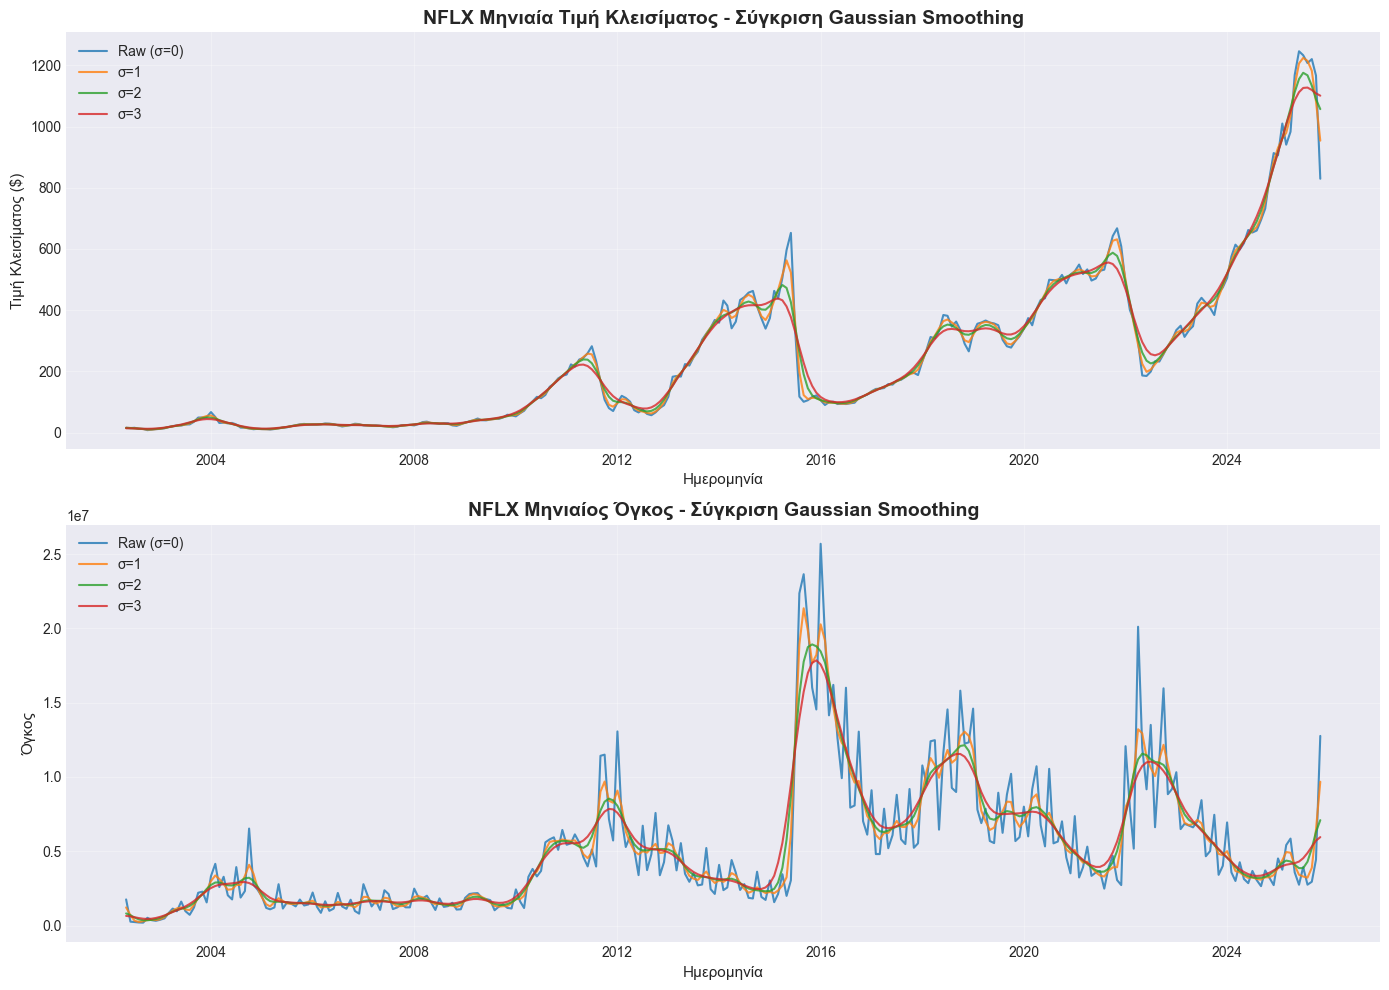

✓ Οπτικοποίηση αποθηκεύτηκε: data/smoothing_comparison.png
✓ Visualization saved: data/smoothing_comparison.png


In [10]:
# Δημιουργία σύγκρισης smoothing (Create smoothing comparison plot)
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 10))

# Close Price
for smoothing_type in ["raw", "sigma1", "sigma2", "sigma3"]:
    df = smoothed_versions[smoothing_type]
    label_map = {"raw": "Raw (σ=0)", "sigma1": "σ=1", "sigma2": "σ=2", "sigma3": "σ=3"}
    ax1.plot(df["Date"], df["Close"], label=label_map[smoothing_type], linewidth=1.5, alpha=0.8)

ax1.set_title("NFLX Μηνιαία Τιμή Κλεισίματος - Σύγκριση Gaussian Smoothing", 
              fontsize=14, fontweight='bold')
ax1.set_xlabel("Ημερομηνία", fontsize=11)
ax1.set_ylabel("Τιμή Κλεισίματος (\$)", fontsize=11)
ax1.legend(loc='upper left', fontsize=10)
ax1.grid(True, alpha=0.3)

# Volume
for smoothing_type in ["raw", "sigma1", "sigma2", "sigma3"]:
    df = smoothed_versions[smoothing_type]
    label_map = {"raw": "Raw (σ=0)", "sigma1": "σ=1", "sigma2": "σ=2", "sigma3": "σ=3"}
    ax2.plot(df["Date"], df["Volume"], label=label_map[smoothing_type], linewidth=1.5, alpha=0.8)

ax2.set_title("NFLX Μηνιαίος Όγκος - Σύγκριση Gaussian Smoothing", 
              fontsize=14, fontweight='bold')
ax2.set_xlabel("Ημερομηνία", fontsize=11)
ax2.set_ylabel("Όγκος", fontsize=11)
ax2.legend(loc='upper left', fontsize=10)
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig("data/smoothing_comparison.png", dpi=150, bbox_inches='tight')
plt.show()

print("✓ Οπτικοποίηση αποθηκεύτηκε: data/smoothing_comparison.png")
print("✓ Visualization saved: data/smoothing_comparison.png")

### 1.5 Στατιστικά Δεδομένων (Data Statistics)

In [11]:
# Εμφάνιση περιγραφικών στατιστικών (Display descriptive statistics)
print("\nΣτατιστικά Μηνιαίων Δεδομένων (Monthly Data Statistics):")
print("="*70)
print(monthly_df[['Close', 'Volume']].describe())

print(f"\nΣυνολικός αριθμός μηνών (Total months): {len(monthly_df)}")
print(f"Εύρος ετών (Year range): {monthly_df['Year'].min()} - {monthly_df['Year'].max()}")
print(f"Μέγιστη τιμή κλεισίματος (Max close price): ${monthly_df['Close'].max():.2f}")
print(f"Ελάχιστη τιμή κλεισίματος (Min close price): ${monthly_df['Close'].min():.2f}")


Στατιστικά Μηνιαίων Δεδομένων (Monthly Data Statistics):
             Close        Volume
count   283.000000  2.830000e+02
mean    247.307613  5.112566e+06
std     258.867204  4.423764e+06
min       7.843652  1.991050e+05
25%      31.774512  1.876556e+06
50%     167.702381  3.680790e+06
75%     367.421346  6.727788e+06
max    1246.012750  2.569438e+07

Συνολικός αριθμός μηνών (Total months): 283
Εύρος ετών (Year range): 2002 - 2025
Μέγιστη τιμή κλεισίματος (Max close price): $1246.01
Ελάχιστη τιμή κλεισίματος (Min close price): $7.84


---

## ΒΗΜΑ 2: ΔΗΜΙΟΥΡΓΙΑ ΧΑΡΑΚΤΗΡΙΣΤΙΚΩΝ (FEATURE ENGINEERING)
## STEP 2: FEATURE ENGINEERING FOR TIME SERIES REGRESSION

### Περιγραφή (Description)

Σε αυτό το βήμα δημιουργούμε χαρακτηριστικά με υστέρηση (lagged features) για πρόβλεψη τιμών μετοχών:  
In this step we create lagged features for stock price prediction:

1. **Φορτώνουμε προεπεξεργασμένα μηνιαία δεδομένα** (4 επίπεδα εξομάλυνσης)
   - Load preprocessed monthly data (4 smoothing levels)

2. **Δημιουργούμε χαρακτηριστικά με υστέρηση**: close_t-1, close_t-2, ..., volume_t-1, volume_t-2, ...
   - Create lagged features: close_t-1, close_t-2, ..., volume_t-1, volume_t-2, ...

3. **Εφαρμόζουμε χρονολογική διαίρεση**: Εκπαίδευση (προ-2025) vs Επικύρωση (2025)
   - Implement chronological split: Training (pre-2025) vs Validation (2025)

4. **Εφαρμόζουμε StandardScaler** προσαρμοσμένο μόνο στα δεδομένα εκπαίδευσης
   - Apply StandardScaler fitted only on training data

5. **Αποθηκεύουμε 16 σύνολα χαρακτηριστικών** για εκπαίδευση μοντέλων
   - Save 16 feature sets for model training

### Παράδειγμα Lagged Features (n_lags=6)
### Example Lagged Features (n_lags=6)

Για να προβλέψουμε την τιμή κλεισίματος του τρέχοντος μήνα, χρησιμοποιούμε:  
To predict the current month's close price, we use:

```
Features = [close_t-1, close_t-2, close_t-3, close_t-4, close_t-5, close_t-6,
            volume_t-1, volume_t-2, volume_t-3, volume_t-4, volume_t-5, volume_t-6]
Target = close_t (current month's closing price)
```

**Συνολικά 16 Ρυθμίσεις (Total 16 Configurations)**:
- 4 επίπεδα εξομάλυνσης × 4 ρυθμίσεις καθυστερήσεων = **16 feature sets**
- 4 smoothing levels (raw, σ1, σ2, σ3) × 4 lag configs (3, 6, 9, 12) = **16 feature sets**

### Κρίσιμα Σημεία (Critical Points)

⚠️ **Χρονολογική Διαίρεση (Chronological Split)**:
- **ΠΟΤΕ τυχαία ανακάτεμα** (NEVER random shuffle)
- Training: Όλα τα δεδομένα < 2025 (All data < 2025)
- Validation: Δεδομένα από 2025 (Data from 2025)
- Προσομοιώνει πραγματικό σενάριο: εκπαίδευση στο παρελθόν, πρόβλεψη στο μέλλον
  (Simulates real scenario: train on past, predict future)

⚠️ **Scaler Fitting**:
- StandardScaler εφαρμόζεται **μόνο στα δεδομένα εκπαίδευσης**
  (StandardScaler fitted **only on training data**)
- Αποτρέπει data leakage από validation set
  (Prevents data leakage from validation set)

### 2.1 Συναρτήσεις Δημιουργίας Χαρακτηριστικών (Feature Creation Functions)

In [12]:
def load_monthly_data(file_path):
    """
    Φορτώνει προεπεξεργασμένα μηνιαία δεδομένα μετοχών από CSV.
    Loads preprocessed monthly stock data from CSV.
    
    Παράμετροι (Args):
        file_path (str): Διαδρομή προς το αρχείο CSV με μηνιαία δεδομένα
                          (Path to CSV file with monthly data)
    
    Επιστρέφει (Returns):
        pd.DataFrame: Μηνιαία δεδομένα με στήλες Date, Year, Month, Close, Volume
                      (Monthly data with Date, Year, Month, Close, Volume columns)
    """
    df = pd.read_csv(file_path)
    df["Date"] = pd.to_datetime(df["Date"])
    df = df.sort_values("Date").reset_index(drop=True)
    
    print(f"Φορτώθηκαν (Loaded) {len(df)} μήνες δεδομένων (months of data) από (from) {file_path}")
    return df


def create_lagged_features(df, n_lags, target_col="Close"):
    """
    Δημιουργεί χαρακτηριστικά με υστέρηση για πρόβλεψη χρονοσειρών.
    Creates lagged features for time series prediction.
    
    Παράμετροι (Args):
        df (pd.DataFrame): DataFrame με στήλες Close και Volume
        n_lags (int): Αριθμός μηνών να κοιτάξουμε πίσω (π.χ., 6 σημαίνει χρήση προηγούμενων 6 μηνών)
                      (Number of months to look back (e.g., 6 means use previous 6 months))
        target_col (str): Στήλη προς πρόβλεψη (Column to predict) (προεπιλογή: 'Close')
    
    Επιστρέφει (Returns):
        pd.DataFrame: DataFrame με χαρακτηριστικά υστέρησης και στόχο
                      (DataFrame with lagged features and target)
    
    Λογική Δημιουργίας Χαρακτηριστικών (Feature Creation Logic):
    - close_t-1: Μέση τιμή κλεισίματος 1 μήνα πριν (πιο πρόσφατη)
                 (Average close price 1 month ago (most recent))
    - close_t-2: Μέση τιμή κλεισίματος 2 μήνες πριν (2 months ago)
    - ...
    - close_t-N: Μέση τιμή κλεισίματος N μήνες πριν (παλαιότερη) (N months ago (oldest))
    - volume_t-1, volume_t-2, ..., volume_t-N: Το ίδιο για τον όγκο (Same for volume)
    - target: Τιμή κλεισίματος που θέλουμε να προβλέψουμε (τρέχων μήνας)
              (Close price we want to predict (current month))
    """
    # Create a copy to avoid modifying original
    features_df = df[["Date", "Year", "Month", "Close", "Volume"]].copy()
    
    # Create lagged features for Close price
    for lag in range(1, n_lags + 1):
        features_df[f"close_t-{lag}"] = features_df["Close"].shift(lag)
    
    # Create lagged features for Volume
    for lag in range(1, n_lags + 1):
        features_df[f"volume_t-{lag}"] = features_df["Volume"].shift(lag)
    
    # The target is the current month's Close price
    features_df["target"] = features_df["Close"]
    
    # Drop rows with NaN values (first n_lags rows don't have enough history)
    features_df = features_df.dropna().reset_index(drop=True)
    
    print(f"  Δημιουργήθηκαν (Created) {n_lags} χαρακτηριστικά υστέρησης (lagged features) για (for) Close και (and) Volume")
    print(f"  Σύνολο χαρακτηριστικών (Total features): {n_lags * 2} (Close + Volume)")
    print(f"  Χρήσιμα δείγματα μετά από διαγραφή NaN (Usable samples after dropping NaN): {len(features_df)}")
    
    return features_df

In [13]:
def split_train_validation_chronological(df, validation_year=2025):
    """
    Διαχωρίζει χρονολογικά τα δεδομένα σε σύνολα εκπαίδευσης και επικύρωσης.
    Splits data chronologically into training and validation sets.
    
    Παράμετροι (Args):
        df (pd.DataFrame): DataFrame με στήλη Year και χαρακτηριστικά
        validation_year (int): Έτος προς χρήση για επικύρωση (προεπιλογή: 2025)
                               (Year to use for validation (default: 2025))
    
    Επιστρέφει (Returns):
        tuple: (train_df, val_df) - DataFrames εκπαίδευσης και επικύρωσης
    
    Κρίσιμο για Χρονοσειρές (Critical for Time Series):
        - ΠΡΕΠΕΙ να χρησιμοποιούμε χρονολογική διαίρεση, ποτέ τυχαία
          (MUST use chronological split, never random split)
        - Δεδομένα εκπαίδευσης: Όλα τα δεδομένα πριν το validation_year
          (Training data: All data before validation_year)
        - Δεδομένα επικύρωσης: Δεδομένα από validation_year και μετά
          (Validation data: Data from validation_year onward)
        - Αυτό προσομοιώνει πραγματικό σενάριο: εκπαίδευση στο παρελθόν, πρόβλεψη στο μέλλον
          (This simulates real-world scenario: train on past, predict future)
    """
    train_df = df[df["Year"] < validation_year].copy()
    val_df = df[df["Year"] >= validation_year].copy()
    
    print(f"\n  Χρονολογική Διαίρεση (Chronological Split):")
    print(f"    Εκπαίδευση (Training): Έτη (Years) < {validation_year} → {len(train_df)} δείγματα (samples)")
    print(f"    Επικύρωση (Validation): Έτη (Years) >= {validation_year} → {len(val_df)} δείγματα (samples)")
    
    # Display date ranges
    if len(train_df) > 0:
        print(f"    Training εύρος (range): {train_df['Date'].min().date()} έως (to) {train_df['Date'].max().date()}")
    if len(val_df) > 0:
        print(f"    Validation εύρος (range): {val_df['Date'].min().date()} έως (to) {val_df['Date'].max().date()}")
    
    return train_df, val_df


def prepare_X_y(df, n_lags):
    """
    Διαχωρίζει το DataFrame σε χαρακτηριστικά (X) και στόχο (y).
    Separates DataFrame into features (X) and target (y).
    
    Παράμετροι (Args):
        df (pd.DataFrame): DataFrame με χαρακτηριστικά υστέρησης και target
        n_lags (int): Αριθμός καθυστερήσεων (Number of lags)
    
    Επιστρέφει (Returns):
        tuple: (X, y, feature_names, metadata)
            - X: Πίνακας χαρακτηριστικών (Feature matrix)
            - y: Πίνακας στόχων (Target array)
            - feature_names: Ονόματα χαρακτηριστικών (Feature names)
            - metadata: Πληροφορίες ημερομηνίας (Date information)
    """
    # Δημιουργία ονομάτων χαρακτηριστικών (Create feature names)
    feature_names = [f"close_t-{i}" for i in range(1, n_lags + 1)] + \
                    [f"volume_t-{i}" for i in range(1, n_lags + 1)]
    
    # Εξαγωγή X και y (Extract X and y)
    X = df[feature_names].values
    y = df["target"].values
    
    # Μεταδεδομένα (Metadata)
    metadata = df[["Date", "Year", "Month"]].copy()
    
    return X, y, np.array(feature_names), metadata


def scale_features(X_train, X_val):
    """
    Κλιμακώνει χαρακτηριστικά χρησιμοποιώντας StandardScaler.
    Scales features using StandardScaler.
    
    Παράμετροι (Args):
        X_train: Χαρακτηριστικά εκπαίδευσης (Training features)
        X_val: Χαρακτηριστικά επικύρωσης (Validation features)
    
    Επιστρέφει (Returns):
        tuple: (X_train_scaled, X_val_scaled, scaler)
    
    Κρίσιμο (Critical):
        - Ο scaler προσαρμόζεται ΜΟΝΟ στα δεδομένα εκπαίδευσης
          (Scaler is fitted ONLY on training data)
        - Αποτρέπει διαρροή πληροφορίας από το validation set
          (Prevents information leakage from validation set)
        - StandardScaler: (x - μ) / σ όπου μ, σ από training data
          (StandardScaler: (x - μ) / σ where μ, σ from training data)
    """
    scaler = StandardScaler()
    
    # Προσαρμογή μόνο στο training (Fit only on training)
    X_train_scaled = scaler.fit_transform(X_train)
    
    # Μετασχηματισμός validation χρησιμοποιώντας training statistics
    # (Transform validation using training statistics)
    X_val_scaled = scaler.transform(X_val)
    
    print(f"\n  Κλιμάκωση Χαρακτηριστικών Εφαρμόστηκε (Feature Scaling Applied):")
    print(f"    Μέθοδος (Method): StandardScaler (z-score κανονικοποίηση (normalization))")
    print(f"    Μέγεθος εκπαίδευσης (Training shape): {X_train_scaled.shape}")
    print(f"    Μέγεθος επικύρωσης (Validation shape): {X_val_scaled.shape}")
    print(f"    Τα χαρακτηριστικά έχουν τώρα mean≈0, std≈1 (βασισμένα σε δεδομένα εκπαίδευσης)")

    print(f"    (Features now have mean≈0, std≈1 (based on training data))")    
    
    return X_train_scaled, X_val_scaled, scaler
    

### 2.2 Εκτέλεση: Δημιουργία Όλων των 16 Feature Sets
### 2.2 Execution: Create All 16 Feature Sets

Δημιουργούμε συνδυασμούς:  
We create combinations:
- **4 smoothing levels**: raw, sigma1, sigma2, sigma3
- **4 lag configurations**: 3, 6, 9, 12 μήνες (months)
- **Total**: 4 × 4 = **16 feature sets**

In [14]:
print("="*70)
print("ΒΗΜΑ 2: ΔΗΜΙΟΥΡΓΙΑ ΧΑΡΑΚΤΗΡΙΣΤΙΚΩΝ (STEP 2: FEATURE ENGINEERING)")
print("="*70)

# Ρυθμίσεις (Configurations)
smoothing_levels = ["raw", "sigma1", "sigma2", "sigma3"]
lag_configs = [3, 6, 9, 12]
validation_year = 2025

# Μετρητής για tracking (Counter for tracking)
feature_sets_created = 0

# Επανάληψη για όλους τους συνδυασμούς (Loop through all combinations)
for smoothing in smoothing_levels:
    for n_lags in lag_configs:
        print(f"\n{'='*70}")
        print(f"Ρύθμιση (Configuration): {smoothing} με {n_lags} καθυστερήσεις (lags)")
        print(f"{'='*70}")
        
        # 1. Φόρτωση δεδομένων (Load data)
        if smoothing == "raw":
            data_file = "data/nflx_monthly_raw.csv"
        else:
            data_file = f"data/nflx_monthly_smoothed_{smoothing}.csv"
        
        df = load_monthly_data(data_file)
        
        # 2. Δημιουργία lagged features (Create lagged features)
        features_df = create_lagged_features(df, n_lags)
        
        # 3. Χρονολογική διαίρεση (Chronological split)
        train_df, val_df = split_train_validation_chronological(features_df, validation_year)
        
        # 4. Προετοιμασία X, y (Prepare X, y)
        X_train, y_train, feature_names, train_metadata = prepare_X_y(train_df, n_lags)
        X_val, y_val, _, val_metadata = prepare_X_y(val_df, n_lags)
        
        print(f"\n  Σχήματα δεδομένων (Data shapes):")
        print(f"    X_train: {X_train.shape}, y_train: {y_train.shape}")
        print(f"    X_val: {X_val.shape}, y_val: {y_val.shape}")
        
        # 5. Κλιμάκωση (Scaling)
        X_train_scaled, X_val_scaled, scaler = scale_features(X_train, X_val)
        
        # 6. Αποθήκευση (Save)
        # Αποθήκευση features σε .npz (Save features to .npz)
        features_filename = f"features/features_{smoothing}_{n_lags}lags.npz"
        np.savez(
            features_filename,
            X_train=X_train_scaled,
            X_val=X_val_scaled,
            y_train=y_train,
            y_val=y_val,
            feature_names=feature_names
        )
        
        # Αποθήκευση scaler (Save scaler)
        scaler_filename = f"features/scaler_{smoothing}_{n_lags}lags.pkl"
        with open(scaler_filename, 'wb') as f:
            pickle.dump(scaler, f)
        
        # Αποθήκευση metadata (Save metadata)
        metadata_filename = f"features/metadata_{smoothing}_{n_lags}lags.csv"
        combined_metadata = pd.concat([
            train_metadata.assign(split='train'),
            val_metadata.assign(split='validation')
        ], ignore_index=True)
        combined_metadata.to_csv(metadata_filename, index=False)
        
        print(f"\n  ✓ Αποθηκεύτηκαν (Saved):")
        print(f"    - {features_filename}")
        print(f"    - {scaler_filename}")
        print(f"    - {metadata_filename}")
        
        feature_sets_created += 1

print(f"\n{'='*70}")
print(f"✓ ΟΛΟΚΛΗΡΩΘΗΚΕ (COMPLETED): {feature_sets_created}/16 feature sets δημιουργήθηκαν!")
print(f"✓ COMPLETED: {feature_sets_created}/16 feature sets created!")
print(f"{'='*70}")

ΒΗΜΑ 2: ΔΗΜΙΟΥΡΓΙΑ ΧΑΡΑΚΤΗΡΙΣΤΙΚΩΝ (STEP 2: FEATURE ENGINEERING)

Ρύθμιση (Configuration): raw με 3 καθυστερήσεις (lags)
Φορτώθηκαν (Loaded) 283 μήνες δεδομένων (months of data) από (from) data/nflx_monthly_raw.csv
  Δημιουργήθηκαν (Created) 3 χαρακτηριστικά υστέρησης (lagged features) για (for) Close και (and) Volume
  Σύνολο χαρακτηριστικών (Total features): 6 (Close + Volume)
  Χρήσιμα δείγματα μετά από διαγραφή NaN (Usable samples after dropping NaN): 280

  Χρονολογική Διαίρεση (Chronological Split):
    Εκπαίδευση (Training): Έτη (Years) < 2025 → 269 δείγματα (samples)
    Επικύρωση (Validation): Έτη (Years) >= 2025 → 11 δείγματα (samples)
    Training εύρος (range): 2002-08-01 έως (to) 2024-12-01
    Validation εύρος (range): 2025-01-01 έως (to) 2025-11-01

  Σχήματα δεδομένων (Data shapes):
    X_train: (269, 6), y_train: (269,)
    X_val: (11, 6), y_val: (11,)

  Κλιμάκωση Χαρακτηριστικών Εφαρμόστηκε (Feature Scaling Applied):
    Μέθοδος (Method): StandardScaler (z-score κανο

### 2.3 Οπτικοποίηση: Train/Validation Split Timeline
### 2.3 Visualization: Train/Validation Split Timeline

Απεικονίζουμε τη χρονολογική διαίρεση για ένα παράδειγμα ρύθμισης:  
We visualize the chronological split for an example configuration:

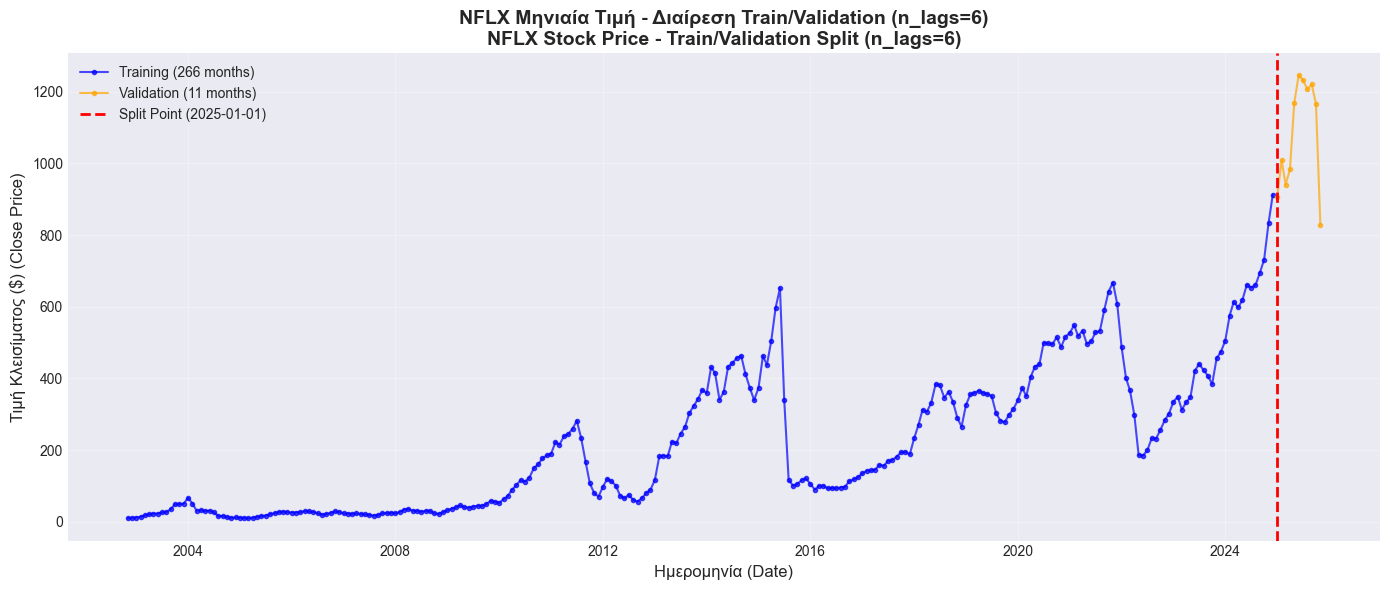

✓ Οπτικοποίηση αποθηκεύτηκε: features/train_val_split_timeline.png
✓ Visualization saved: features/train_val_split_timeline.png


In [15]:
# Φόρτωση ενός παραδείγματος για οπτικοποίηση (Load an example for visualization)
example_data = np.load("features/features_raw_6lags.npz", allow_pickle=True)
example_metadata = pd.read_csv("features/metadata_raw_6lags.csv")
example_metadata["Date"] = pd.to_datetime(example_metadata["Date"])

# Φόρτωση raw δεδομένων για target τιμές (Load raw data for target values)
df_raw = pd.read_csv("data/nflx_monthly_raw.csv")
df_raw["Date"] = pd.to_datetime(df_raw["Date"])

# Merge metadata με target τιμές (Merge metadata with target values)
# Χρησιμοποιούμε τις ημερομηνίες από metadata για να βρούμε τις αντίστοιχες τιμές
example_full = example_metadata.merge(df_raw[["Date", "Close"]], on="Date", how="left")

# Διαχωρισμός train/val (Separate train/val)
train_data = example_full[example_full["split"] == "train"]
val_data = example_full[example_full["split"] == "validation"]

# Δημιουργία οπτικοποίησης (Create visualization)
fig, ax = plt.subplots(1, 1, figsize=(14, 6))

# Plot training data
ax.plot(train_data["Date"], train_data["Close"], 
        'o-', label=f'Training ({len(train_data)} months)', 
        alpha=0.7, markersize=3, linewidth=1.5, color='blue')

# Plot validation data
ax.plot(val_data["Date"], val_data["Close"], 
        'o-', label=f'Validation ({len(val_data)} months)', 
        alpha=0.7, markersize=3, linewidth=1.5, color='orange')

# Κάθετη γραμμή στο σημείο διαχωρισμού (Vertical line at split point)
if len(val_data) > 0:
    split_date = val_data["Date"].min()
    ax.axvline(x=split_date, color='red', linestyle='--', linewidth=2, 
              label=f'Split Point ({split_date.date()})')

# Styling
ax.set_xlabel("Ημερομηνία (Date)", fontsize=12)
ax.set_ylabel("Τιμή Κλεισίματος ($) (Close Price)", fontsize=12)
ax.set_title("NFLX Μηνιαία Τιμή - Διαίρεση Train/Validation (n_lags=6)\nNFLX Stock Price - Train/Validation Split (n_lags=6)", 
            fontsize=14, fontweight='bold')
ax.legend(loc='best', fontsize=10)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig("features/train_val_split_timeline.png", dpi=150, bbox_inches='tight')
plt.show()

print("✓ Οπτικοποίηση αποθηκεύτηκε: features/train_val_split_timeline.png")
print("✓ Visualization saved: features/train_val_split_timeline.png")

### 2.4 Επισκόπηση Feature Sets (Feature Sets Overview)

Εμφάνιση περίληψης όλων των δημιουργημένων feature sets:  
Display summary of all created feature sets:

In [16]:
# Δημιουργία πίνακα περίληψης (Create summary table)
summary_data = []

for smoothing in smoothing_levels:
    for n_lags in lag_configs:
        # Φόρτωση features (Load features)
        features_file = f"features/features_{smoothing}_{n_lags}lags.npz"
        data = np.load(features_file, allow_pickle=True)
        
        summary_data.append({
            'Smoothing': smoothing,
            'N_Lags': n_lags,
            'Total_Features': n_lags * 2,
            'Train_Samples': data['X_train'].shape[0],
            'Val_Samples': data['X_val'].shape[0],
            'Total_Samples': data['X_train'].shape[0] + data['X_val'].shape[0]
        })

summary_df = pd.DataFrame(summary_data)

print("\nΠερίληψη Όλων των Feature Sets (Summary of All Feature Sets):")
print("="*80)
print(summary_df.to_string(index=False))
print("="*80)

# Συγκεντρωτικά στατιστικά (Aggregate statistics)
print(f"\nΣυγκεντρωτικά (Aggregates):")
print(f"  Σύνολο feature sets (Total feature sets): {len(summary_df)}")
print(f"  Μέσος όρος train samples (Average train samples): {summary_df['Train_Samples'].mean():.1f}")
print(f"  Μέσος όρος val samples (Average val samples): {summary_df['Val_Samples'].mean():.1f}")
print(f"  Εύρος χαρακτηριστικών (Feature range): {summary_df['Total_Features'].min()}-{summary_df['Total_Features'].max()}")


Περίληψη Όλων των Feature Sets (Summary of All Feature Sets):
Smoothing  N_Lags  Total_Features  Train_Samples  Val_Samples  Total_Samples
      raw       3               6            269           11            280
      raw       6              12            266           11            277
      raw       9              18            263           11            274
      raw      12              24            260           11            271
   sigma1       3               6            269           11            280
   sigma1       6              12            266           11            277
   sigma1       9              18            263           11            274
   sigma1      12              24            260           11            271
   sigma2       3               6            269           11            280
   sigma2       6              12            266           11            277
   sigma2       9              18            263           11            274
   sigma2    

---

## ΒΗΜΑ 3: BASELINE LINEAR REGRESSION
## STEP 3: BASELINE LINEAR REGRESSION

### Περιγραφή (Description)

Σε αυτό το βήμα εκπαιδεύουμε **16 baseline μοντέλα LinearRegression**:  
In this step we train **16 baseline LinearRegression models**:

1. **Φορτώνουμε όλα τα 16 feature sets** που δημιουργήθηκαν στο Βήμα 2
   - Load all 16 feature sets created in Step 2

2. **Εκπαιδεύουμε LinearRegression** για κάθε συνδυασμό (smoothing × lags)
   - Train LinearRegression for each combination (smoothing × lags)

3. **Υπολογίζουμε μετρικές απόδοσης** στο validation set:
   - Compute performance metrics on validation set:
   - **RMSE**: Root Mean Squared Error (χαμηλότερο = καλύτερο)
   - **MAE**: Mean Absolute Error (χαμηλότερο = καλύτερο)
   - **R² Score**: Coefficient of Determination (υψηλότερο = καλύτερο, max=1.0)

4. **Αναγνωρίζουμε το καλύτερο μοντέλο** βάσει validation RMSE
   - Identify the best model based on validation RMSE

5. **Αποθηκεύουμε αποτελέσματα** και το καλύτερο μοντέλο
   - Save results and the best model

### Μαθηματικό Υπόβαθρο (Mathematical Background)

**Linear Regression**:
$$\hat{y} = \beta_0 + \beta_1 x_1 + \beta_2 x_2 + ... + \beta_n x_n$$

Όπου (Where):
- $\hat{y}$: Προβλεπόμενη τιμή κλεισίματος (Predicted close price)
- $\beta_0$: Σταθερός όρος (Intercept)
- $\beta_i$: Συντελεστές για κάθε χαρακτηριστικό (Coefficients for each feature)
- $x_i$: Χαρακτηριστικά (close_t-i, volume_t-i)

**Μετρικές Αξιολόγησης (Evaluation Metrics)**:

1. **RMSE** (Root Mean Squared Error):
   $$RMSE = \sqrt{\frac{1}{n}\sum_{i=1}^{n}(y_i - \hat{y}_i)^2}$$
   - Τιμωρεί μεγάλα σφάλματα περισσότερο (Penalizes large errors more)

2. **MAE** (Mean Absolute Error):
   $$MAE = \frac{1}{n}\sum_{i=1}^{n}|y_i - \hat{y}_i|$$
   - Μέσο απόλυτο σφάλμα (Average absolute error)

3. **R² Score** (Coefficient of Determination):
   $$R^2 = 1 - \frac{\sum_{i=1}^{n}(y_i - \hat{y}_i)^2}{\sum_{i=1}^{n}(y_i - \bar{y})^2}$$
   - Ποσοστό διακύμανσης που εξηγείται από το μοντέλο (Proportion of variance explained by model)
   - R²=1.0 → Τέλεια πρόβλεψη (Perfect prediction)
   - R²=0.0 → Μοντέλο όσο καλό όσο ο μέσος όρος (Model as good as mean)

### Στόχοι (Objectives)

✓ Δημιουργία baseline αποτελεσμάτων για σύγκριση με πιο σύνθετα μοντέλα  
✓ Establish baseline results for comparison with more complex models

✓ Προσδιορισμός του καλύτερου συνδυασμού smoothing × lags  
✓ Identify the best smoothing × lags combination

✓ Κατανόηση της επίδρασης της εξομάλυνσης και των καθυστερήσεων στην απόδοση  
✓ Understand the effect of smoothing and lags on performance

### 3.1 Συνάρτηση Εκπαίδευσης και Αξιολόγησης (Training and Evaluation Function)


In [17]:
def train_and_evaluate_linear_model(X_train, y_train, X_val, y_val, model_name="LinearRegression"):
    """
    Εκπαιδεύει ένα LinearRegression μοντέλο και υπολογίζει μετρικές απόδοσης.
    Trains a LinearRegression model and computes performance metrics.
    
    Παράμετροι (Args):
        X_train: Χαρακτηριστικά εκπαίδευσης (Training features)
        y_train: Στόχοι εκπαίδευσης (Training targets)
        X_val: Χαρακτηριστικά επικύρωσης (Validation features)
        y_val: Στόχοι επικύρωσης (Validation targets)
        model_name (str): Όνομα μοντέλου για αναφορά (Model name for reporting)
    
    Επιστρέφει (Returns):
        tuple: (model, metrics_dict)
            - model: Εκπαιδευμένο μοντέλο (Trained model)
            - metrics_dict: Λεξικό με RMSE, MAE, R² για train και validation
                            (Dictionary with RMSE, MAE, R² for train and validation)
    
    Σημειώσεις (Notes):
        - Χρησιμοποιεί scikit-learn LinearRegression (OLS)
        - Υπολογίζει μετρικές τόσο στο train όσο και στο validation set
        - RMSE σε δολάρια ($) - εκφράζει μέσο σφάλμα πρόβλεψης
    """
    # Δημιουργία και εκπαίδευση μοντέλου (Create and train model)
    model = LinearRegression()
    model.fit(X_train, y_train)
    
    # Προβλέψεις (Predictions)
    y_train_pred = model.predict(X_train)
    y_val_pred = model.predict(X_val)
    
    # Υπολογισμός μετρικών για Training (Compute metrics for Training)
    train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
    train_mae = mean_absolute_error(y_train, y_train_pred)
    train_r2 = r2_score(y_train, y_train_pred)
    
    # Υπολογισμός μετρικών για Validation (Compute metrics for Validation)
    val_rmse = np.sqrt(mean_squared_error(y_val, y_val_pred))
    val_mae = mean_absolute_error(y_val, y_val_pred)
    val_r2 = r2_score(y_val, y_val_pred)
    
    # Δημιουργία λεξικού μετρικών (Create metrics dictionary)
    metrics = {
        'model_name': model_name,
        'train_rmse': train_rmse,
        'train_mae': train_mae,
        'train_r2': train_r2,
        'val_rmse': val_rmse,
        'val_mae': val_mae,
        'val_r2': val_r2
    }
    
    return model, metrics


def display_metrics(metrics, title="Model Performance"):
    """
    Εμφανίζει μετρικές απόδοσης μοντέλου με ωραία μορφοποίηση.
    Displays model performance metrics with nice formatting.
    
    Παράμετροι (Args):
        metrics (dict): Λεξικό με μετρικές από train_and_evaluate_linear_model
        title (str): Τίτλος για εμφάνιση (Display title)
    """
    print(f"\n{title}:")
    print("-" * 60)
    print(f"  {'Metric':<20} {'Training':<18} {'Validation':<18}")
    print("-" * 60)
    print(f"  {'RMSE ($)':<20} {metrics['train_rmse']:>15.2f}   {metrics['val_rmse']:>15.2f}")
    print(f"  {'MAE ($)':<20} {metrics['train_mae']:>15.2f}   {metrics['val_mae']:>15.2f}")
    print(f"  {'R² Score':<20} {metrics['train_r2']:>15.4f}   {metrics['val_r2']:>15.4f}")
    print("-" * 60)

### 3.2 Εκτέλεση: Εκπαίδευση 16 Baseline Μοντέλων
### 3.2 Execution: Train 16 Baseline Models

Εκπαιδεύουμε LinearRegression για κάθε συνδυασμό smoothing × lags:  
Train LinearRegression for each smoothing × lags combination:


In [18]:
print("="*70)
print("ΒΗΜΑ 3: BASELINE LINEAR REGRESSION")
print("STEP 3: BASELINE LINEAR REGRESSION")
print("="*70)

# Ρυθμίσεις (Configurations)
smoothing_levels = ["raw", "sigma1", "sigma2", "sigma3"]
lag_configs = [3, 6, 9, 12]

# Λίστα για αποθήκευση αποτελεσμάτων (List to store results)
all_results = []

# Dictionary για αποθήκευση μοντέλων (Dictionary to store models)
trained_models = {}

# Μετρητής (Counter)
model_count = 0

# Επανάληψη για όλους τους συνδυασμούς (Loop through all combinations)
for smoothing in smoothing_levels:
    for n_lags in lag_configs:
        model_count += 1
        print(f"\n{'='*70}")
        print(f"Μοντέλο (Model) [{model_count}/16]: {smoothing} με (with) {n_lags} lags")
        print(f"{'='*70}")
        
        # 1. Φόρτωση feature set (Load feature set)
        features_file = f"features/features_{smoothing}_{n_lags}lags.npz"
        data = np.load(features_file, allow_pickle=True)
        
        X_train = data['X_train']
        X_val = data['X_val']
        y_train = data['y_train']
        y_val = data['y_val']
        
        print(f"Φορτώθηκαν χαρακτηριστικά (Loaded features):")
        print(f"  X_train: {X_train.shape}, y_train: {y_train.shape}")
        print(f"  X_val: {X_val.shape}, y_val: {y_val.shape}")
        
        # 2. Εκπαίδευση και αξιολόγηση (Train and evaluate)
        model_name = f"LR_{smoothing}_{n_lags}lags"
        model, metrics = train_and_evaluate_linear_model(
            X_train, y_train, X_val, y_val, model_name=model_name
        )
        
        # 3. Προσθήκη πληροφοριών ρύθμισης (Add configuration info)
        metrics['smoothing'] = smoothing
        metrics['n_lags'] = n_lags
        metrics['n_features'] = X_train.shape[1]
        
        # 4. Αποθήκευση αποτελεσμάτων (Store results)
        all_results.append(metrics)
        trained_models[model_name] = model
        
        # 5. Εμφάνιση μετρικών (Display metrics)
        display_metrics(metrics, title=f"Απόδοση {model_name} (Performance {model_name})")

print(f"\n{'='*70}")
print(f"✓ ΟΛΟΚΛΗΡΩΘΗΚΕ (COMPLETED): {model_count}/16 μοντέλα εκπαιδεύτηκαν!")
print(f"✓ COMPLETED: {model_count}/16 models trained!")
print(f"{'='*70}")

ΒΗΜΑ 3: BASELINE LINEAR REGRESSION
STEP 3: BASELINE LINEAR REGRESSION

Μοντέλο (Model) [1/16]: raw με (with) 3 lags
Φορτώθηκαν χαρακτηριστικά (Loaded features):
  X_train: (269, 6), y_train: (269,)
  X_val: (11, 6), y_val: (11,)

Απόδοση LR_raw_3lags (Performance LR_raw_3lags):
------------------------------------------------------------
  Metric               Training           Validation        
------------------------------------------------------------
  RMSE ($)                       32.76            121.68
  MAE ($)                        18.52             84.24
  R² Score                      0.9727            0.2887
------------------------------------------------------------

Μοντέλο (Model) [2/16]: raw με (with) 6 lags
Φορτώθηκαν χαρακτηριστικά (Loaded features):
  X_train: (266, 12), y_train: (266,)
  X_val: (11, 12), y_val: (11,)

Απόδοση LR_raw_6lags (Performance LR_raw_6lags):
------------------------------------------------------------
  Metric               Training   

### 3.3 Αποτελέσματα: Σύγκριση Όλων των Μοντέλων
### 3.3 Results: Comparison of All Models

Δημιουργούμε πίνακα με τα αποτελέσματα όλων των μοντέλων:  
Create a table with results from all models:


In [19]:
# Δημιουργία DataFrame με αποτελέσματα (Create DataFrame with results)
results_df = pd.DataFrame(all_results)

# Ταξινόμηση κατά validation RMSE (Sort by validation RMSE)
results_df = results_df.sort_values('val_rmse').reset_index(drop=True)

# Εμφάνιση πίνακα αποτελεσμάτων (Display results table)
print("\nΠίνακας Αποτελεσμάτων Baseline Μοντέλων (Baseline Models Results Table):")
print("="*100)
print(results_df[['model_name', 'smoothing', 'n_lags', 'n_features', 
                   'val_rmse', 'val_mae', 'val_r2', 'train_rmse', 'train_r2']].to_string(index=False))
print("="*100)

# Εύρεση καλύτερου μοντέλου (Find best model)
best_model_idx = results_df['val_rmse'].idxmin()
best_model_info = results_df.iloc[best_model_idx]

print(f"\n{'='*70}")
print("ΚΑΛΥΤΕΡΟ ΜΟΝΤΕΛΟ (BEST MODEL)")
print(f"{'='*70}")
print(f"  Όνομα (Name): {best_model_info['model_name']}")
print(f"  Smoothing: {best_model_info['smoothing']}")
print(f"  N_Lags: {best_model_info['n_lags']}")
print(f"  Features: {best_model_info['n_features']}")
print(f"\n  Validation Metrics:")
print(f"    RMSE: ${best_model_info['val_rmse']:.2f}")
print(f"    MAE:  ${best_model_info['val_mae']:.2f}")
print(f"    R²:   {best_model_info['val_r2']:.4f}")
print(f"\n  Training Metrics:")
print(f"    RMSE: ${best_model_info['train_rmse']:.2f}")
print(f"    MAE:  ${best_model_info['train_mae']:.2f}")
print(f"    R²:   {best_model_info['train_r2']:.4f}")
print(f"{'='*70}")

# Στατιστικά σύγκρισης (Comparison statistics)
print(f"\nΣτατιστικά Σύγκρισης (Comparison Statistics):")
print(f"  Καλύτερο Validation RMSE (Best Validation RMSE): ${results_df['val_rmse'].min():.2f}")
print(f"  Χειρότερο Validation RMSE (Worst Validation RMSE): ${results_df['val_rmse'].max():.2f}")
print(f"  Μέσος όρος Validation RMSE (Average Validation RMSE): ${results_df['val_rmse'].mean():.2f}")
print(f"  Τυπική απόκλιση Validation RMSE (Std Dev Validation RMSE): ${results_df['val_rmse'].std():.2f}")


Πίνακας Αποτελεσμάτων Baseline Μοντέλων (Baseline Models Results Table):
      model_name smoothing  n_lags  n_features   val_rmse   val_mae   val_r2  train_rmse  train_r2
LR_sigma3_12lags    sigma3      12          24   0.061582  0.054098 0.999999    0.021062  1.000000
 LR_sigma3_9lags    sigma3       9          18   0.062713  0.055966 0.999999    0.023070  1.000000
 LR_sigma3_6lags    sigma3       6          12   0.266985  0.238426 0.999985    0.084891  1.000000
LR_sigma2_12lags    sigma2      12          24   0.541077  0.419391 0.999956    0.141457  0.999999
 LR_sigma2_9lags    sigma2       9          18   0.927908  0.803425 0.999871    0.259372  0.999998
 LR_sigma2_6lags    sigma2       6          12   1.799789  1.452114 0.999514    0.611743  0.999990
 LR_sigma3_3lags    sigma3       3           6   2.458256  1.991988 0.998743    1.113617  0.999966
 LR_sigma2_3lags    sigma2       3           6   7.560853  6.429825 0.991415    2.806196  0.999790
LR_sigma1_12lags    sigma1      12 

### 3.4 Οπτικοποίηση: Σύγκριση Απόδοσης Μοντέλων
### 3.4 Visualization: Model Performance Comparison


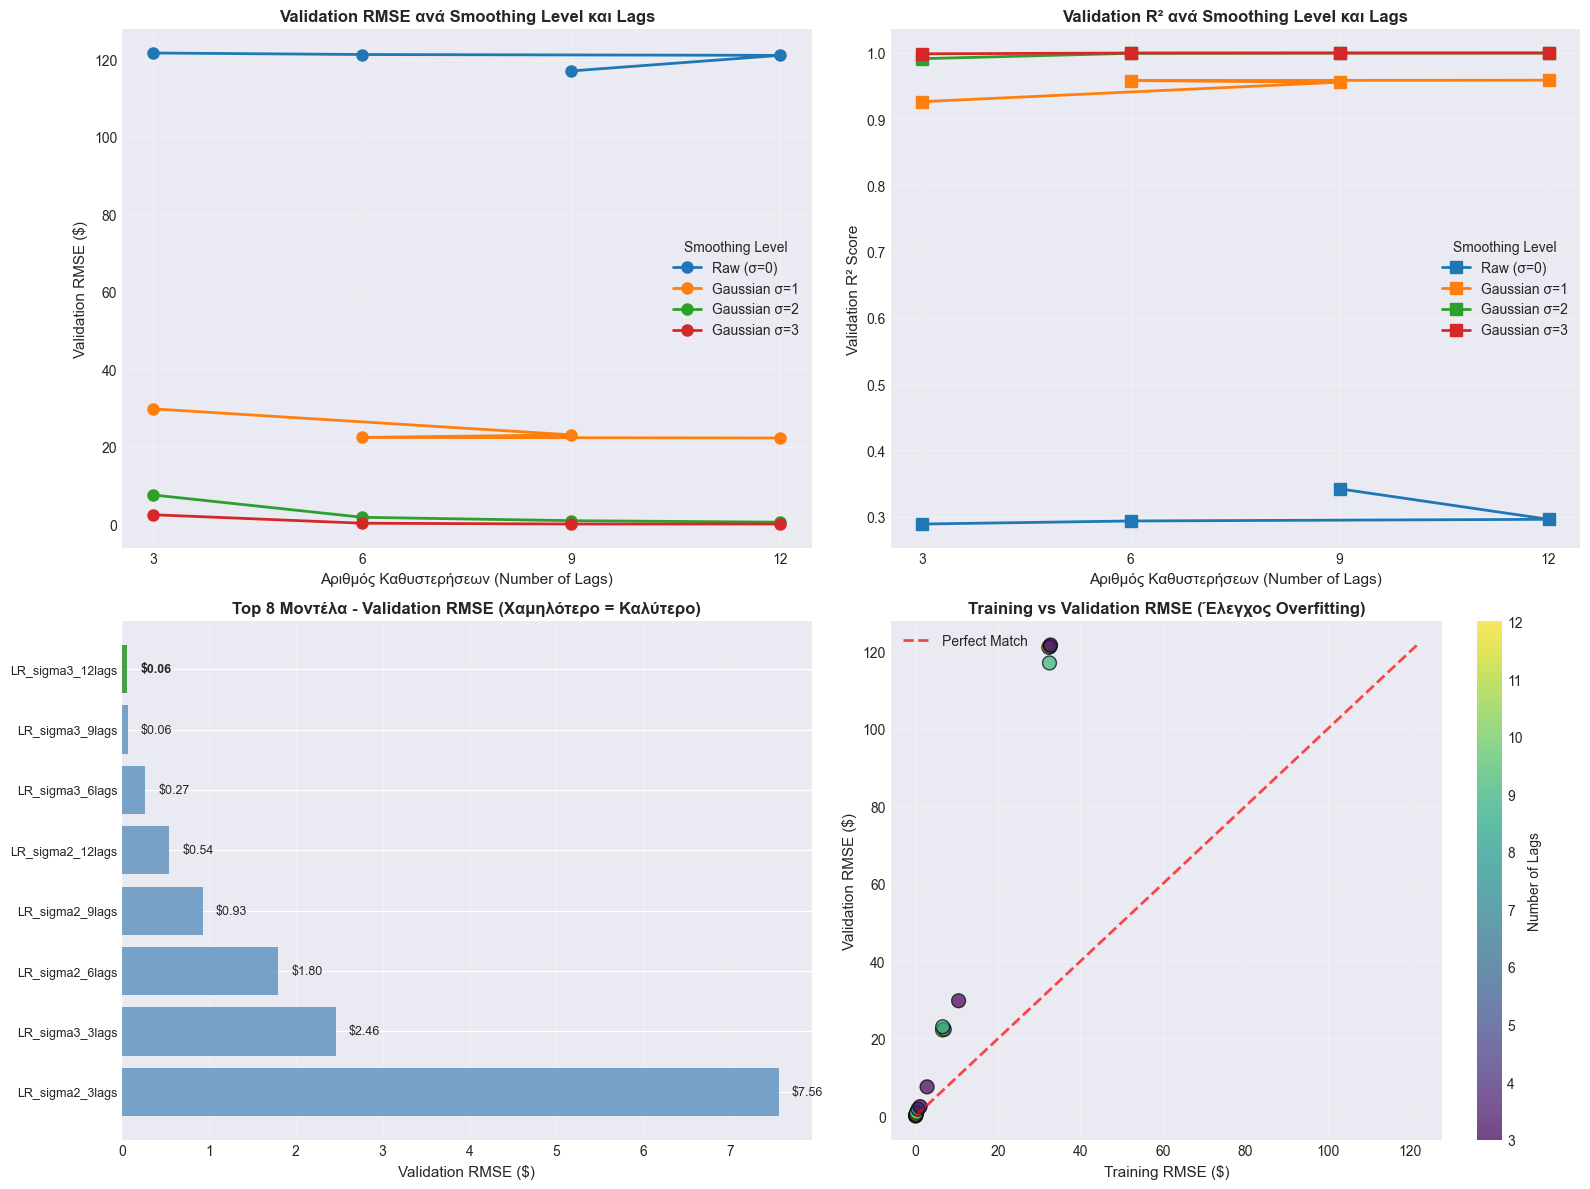

✓ Οπτικοποίηση αποθηκεύτηκε: results/baseline_linear_regression_comparison.png
✓ Visualization saved: results/baseline_linear_regression_comparison.png


In [20]:
# Δημιουργία οπτικοποιήσεων (Create visualizations)
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. Validation RMSE ανά smoothing level (Validation RMSE by smoothing level)
ax1 = axes[0, 0]
label_map = {'raw': 'Raw (σ=0)', 'sigma1': 'Gaussian σ=1', 'sigma2': 'Gaussian σ=2', 'sigma3': 'Gaussian σ=3'}
for smoothing in smoothing_levels:
    subset = results_df[results_df['smoothing'] == smoothing]
    ax1.plot(subset['n_lags'], subset['val_rmse'], marker='o', linewidth=2, 
            label=label_map[smoothing], markersize=8)

ax1.set_xlabel('Αριθμός Καθυστερήσεων (Number of Lags)', fontsize=11)
ax1.set_ylabel('Validation RMSE (\$)', fontsize=11)
ax1.set_title('Validation RMSE ανά Smoothing Level και Lags', 
             fontsize=12, fontweight='bold')
ax1.legend(title='Smoothing Level', fontsize=10)
ax1.grid(True, alpha=0.3)
ax1.set_xticks(lag_configs)

# 2. Validation R² ανά smoothing level (Validation R² by smoothing level)
ax2 = axes[0, 1]
for smoothing in smoothing_levels:
    subset = results_df[results_df['smoothing'] == smoothing]
    ax2.plot(subset['n_lags'], subset['val_r2'], marker='s', linewidth=2, 
            label=label_map[smoothing], markersize=8)

ax2.set_xlabel('Αριθμός Καθυστερήσεων (Number of Lags)', fontsize=11)
ax2.set_ylabel('Validation R² Score', fontsize=11)
ax2.set_title('Validation R² ανά Smoothing Level και Lags', 
             fontsize=12, fontweight='bold')
ax2.legend(title='Smoothing Level', fontsize=10)
ax2.grid(True, alpha=0.3)
ax2.set_xticks(lag_configs)

# 3. Bar plot: Top 8 μοντέλα κατά Validation RMSE (Top 8 models by Validation RMSE)
ax3 = axes[1, 0]
top8 = results_df.head(8)
colors = ['green' if i == 0 else 'steelblue' for i in range(len(top8))]
bars = ax3.barh(range(len(top8)), top8['val_rmse'], color=colors, alpha=0.7)
ax3.set_yticks(range(len(top8)))
ax3.set_yticklabels(top8['model_name'], fontsize=9)
ax3.set_xlabel('Validation RMSE (\$)', fontsize=11)
ax3.set_title('Top 8 Μοντέλα - Validation RMSE (Χαμηλότερο = Καλύτερο)', 
             fontsize=12, fontweight='bold')
ax3.grid(True, alpha=0.3, axis='x')
ax3.invert_yaxis()

# Προσθήκη τιμών στα bars (Add values to bars)
# Υπολογισμός offset ως ποσοστό του εύρους (Calculate offset as percentage of range)
max_val = top8['val_rmse'].max()
offset = max_val * 0.02  # 2% of max value for consistent spacing
for i, (bar, val) in enumerate(zip(bars, top8['val_rmse'])):
    ax3.text(val + offset, bar.get_y() + bar.get_height()/2, f'${val:.2f}', 
            va='center', fontsize=9, fontweight='bold' if i == 0 else 'normal')

# 4. Scatter: Training vs Validation RMSE (Overfitting check)
ax4 = axes[1, 1]
scatter = ax4.scatter(results_df['train_rmse'], results_df['val_rmse'], 
                     c=results_df['n_lags'], cmap='viridis', s=100, alpha=0.7, edgecolors='black')

# Diagonal line (perfect match)
min_rmse = min(results_df['train_rmse'].min(), results_df['val_rmse'].min())
max_rmse = max(results_df['train_rmse'].max(), results_df['val_rmse'].max())
ax4.plot([min_rmse, max_rmse], [min_rmse, max_rmse], 'r--', linewidth=2, 
        label='Perfect Match', alpha=0.7)

ax4.set_xlabel('Training RMSE (\$)', fontsize=11)
ax4.set_ylabel('Validation RMSE (\$)', fontsize=11)
ax4.set_title('Training vs Validation RMSE (Έλεγχος Overfitting)', 
             fontsize=12, fontweight='bold')
ax4.legend(fontsize=10, loc='upper left')
ax4.grid(True, alpha=0.3)

# Colorbar για lags (Colorbar for lags)
cbar = plt.colorbar(scatter, ax=ax4)
cbar.set_label('Number of Lags', fontsize=10)

plt.tight_layout()
plt.savefig("results/baseline_linear_regression_comparison.png", dpi=150, bbox_inches='tight')
plt.show()

print("✓ Οπτικοποίηση αποθηκεύτηκε: results/baseline_linear_regression_comparison.png")
print("✓ Visualization saved: results/baseline_linear_regression_comparison.png")

### 3.5 Αποθήκευση Αποτελεσμάτων και Καλύτερου Μοντέλου
### 3.5 Save Results and Best Model


In [21]:
# 1. Αποθήκευση αποτελεσμάτων σε CSV (Save results to CSV)
results_filename = "results/baseline_linear_regression_results.csv"
results_df.to_csv(results_filename, index=False)
print(f"✓ Αποτελέσματα αποθηκεύτηκαν (Results saved): {results_filename}")

# 2. Αποθήκευση ΟΛΩΝ των baseline μοντέλων (Save ALL baseline models)
# Δημιουργία dictionary με όλα τα μοντέλα και metadata (Create dictionary with all models and metadata)
all_baseline_models = {}
for idx, row in results_df.iterrows():
    model_name = row['model_name']
    model_info = {
        'model': trained_models[model_name],
        'smoothing': row['smoothing'],
        'n_lags': row['n_lags'],
        'n_features': row['n_features'],
        'train_rmse': row['train_rmse'],
        'train_mae': row['train_mae'],
        'train_r2': row['train_r2'],
        'val_rmse': row['val_rmse'],
        'val_mae': row['val_mae'],
        'val_r2': row['val_r2']
    }
    all_baseline_models[model_name] = model_info

# Αποθήκευση όλων των μοντέλων σε ένα αρχείο (Save all models to one file)
all_models_filename = "models/all_baseline_models.pkl"
with open(all_models_filename, 'wb') as f:
    pickle.dump(all_baseline_models, f)

print(f"✓ Όλα τα baseline μοντέλα αποθηκεύτηκαν (All baseline models saved): {all_models_filename} ({len(all_baseline_models)} models)")

# 3. Αποθήκευση καλύτερου μοντέλου ξεχωριστά (Save best model separately)
best_model_name = best_model_info['model_name']
best_model_data = {
    'model': trained_models[best_model_name],
    'model_name': best_model_name,
    'smoothing': best_model_info['smoothing'],
    'n_lags': best_model_info['n_lags'],
    'n_features': best_model_info['n_features'],
    'train_rmse': best_model_info['train_rmse'],
    'train_mae': best_model_info['train_mae'],
    'train_r2': best_model_info['train_r2'],
    'val_rmse': best_model_info['val_rmse'],
    'val_mae': best_model_info['val_mae'],
    'val_r2': best_model_info['val_r2']
}

best_model_filename = f"models/best_baseline_model.pkl"
with open(best_model_filename, 'wb') as f:
    pickle.dump(best_model_data, f)

print(f"✓ Καλύτερο μοντέλο αποθηκεύτηκε (Best model saved): {best_model_filename}")

# 4. Αποθήκευση πληροφοριών καλύτερου μοντέλου (Save best model info)
best_model_info_filename = "results/best_baseline_model_info.txt"
with open(best_model_info_filename, 'w', encoding='utf-8') as f:
    f.write("="*70 + "\n")
    f.write("ΚΑΛΥΤΕΡΟ BASELINE ΜΟΝΤΕΛΟ (BEST BASELINE MODEL)\n")
    f.write("="*70 + "\n\n")
    f.write(f"Model Name: {best_model_info['model_name']}\n")
    f.write(f"Smoothing: {best_model_info['smoothing']}\n")
    f.write(f"N_Lags: {best_model_info['n_lags']}\n")
    f.write(f"N_Features: {best_model_info['n_features']}\n\n")
    f.write("Validation Metrics:\n")
    f.write(f"  RMSE: ${best_model_info['val_rmse']:.2f}\n")
    f.write(f"  MAE:  ${best_model_info['val_mae']:.2f}\n")
    f.write(f"  R²:   {best_model_info['val_r2']:.4f}\n\n")
    f.write("Training Metrics:\n")
    f.write(f"  RMSE: ${best_model_info['train_rmse']:.2f}\n")
    f.write(f"  MAE:  ${best_model_info['train_mae']:.2f}\n")
    f.write(f"  R²:   {best_model_info['train_r2']:.4f}\n")
    f.write("="*70 + "\n")

print(f"✓ Πληροφορίες καλύτερου μοντέλου αποθηκεύτηκαν (Best model info saved): {best_model_info_filename}")

print(f"\n{'='*70}")
print("✓ ΒΗΜΑ 3 ΟΛΟΚΛΗΡΩΘΗΚΕ (STEP 3 COMPLETED)")
print(f"{'='*70}")
print(f"\nΑρχεία που δημιουργήθηκαν (Files created):")
print(f"  1. {results_filename}")
print(f"  2. {all_models_filename} - ALL 16 baseline models")
print(f"  3. {best_model_filename}")
print(f"  4. {best_model_info_filename}")
print(f"  5. results/baseline_linear_regression_comparison.png")


✓ Αποτελέσματα αποθηκεύτηκαν (Results saved): results/baseline_linear_regression_results.csv
✓ Όλα τα baseline μοντέλα αποθηκεύτηκαν (All baseline models saved): models/all_baseline_models.pkl (16 models)
✓ Καλύτερο μοντέλο αποθηκεύτηκε (Best model saved): models/best_baseline_model.pkl
✓ Πληροφορίες καλύτερου μοντέλου αποθηκεύτηκαν (Best model info saved): results/best_baseline_model_info.txt

✓ ΒΗΜΑ 3 ΟΛΟΚΛΗΡΩΘΗΚΕ (STEP 3 COMPLETED)

Αρχεία που δημιουργήθηκαν (Files created):
  1. results/baseline_linear_regression_results.csv
  2. models/all_baseline_models.pkl - ALL 16 baseline models
  3. models/best_baseline_model.pkl
  4. results/best_baseline_model_info.txt
  5. results/baseline_linear_regression_comparison.png


---

## ΒΗΜΑ 4: POLYNOMIAL REGRESSION ΜΕ L1/L2 REGULARIZATION
## STEP 4: POLYNOMIAL REGRESSION WITH L1/L2 REGULARIZATION

### Περιγραφή (Description)

Σε αυτό το βήμα επεκτείνουμε τα baseline μοντέλα με:  
In this step we extend the baseline models with:

1. **Polynomial Features** (degree=2): Δημιουργούμε μη-γραμμικές αλληλεπιδράσεις
   - Create non-linear feature interactions

2. **L2 Regularization (Ridge)**: Τιμωρεί μεγάλους συντελεστές
   - Penalizes large coefficients

3. **L1 Regularization (Lasso)**: Τιμωρεί και μηδενίζει συντελεστές (feature selection)
   - Penalizes and zeros out coefficients (feature selection)

**Συνολικά 32 Μοντέλα (Total 32 Models)**:
- 16 feature sets × 2 regularization types (Ridge + Lasso) = **32 models**

### Μαθηματικό Υπόβαθρο (Mathematical Background)

**Polynomial Features (Degree 2)**:

Για χαρακτηριστικά [x₁, x₂], δημιουργούμε:  
For features [x₁, x₂], we create:

$$[1, x_1, x_2, x_1^2, x_1 x_2, x_2^2]$$

Παράδειγμα (Example): Από 6 lags (12 features) → **91 polynomial features**

**Ridge Regression (L2)**:

$$\min_{\beta} \sum_{i=1}^{n}(y_i - \hat{y}_i)^2 + \alpha \sum_{j=1}^{p}\beta_j^2$$

Όπου (Where):
- α (alpha): Παράμετρος regularization (Regularization parameter)
- Μεγαλύτερο α → Περισσότερη τιμωρία → Μικρότεροι συντελεστές
  (Larger α → More penalty → Smaller coefficients)
- **Πλεονέκτημα (Advantage)**: Μειώνει overfitting, διατηρεί όλα τα features
  (Reduces overfitting, keeps all features)

**Lasso Regression (L1)**:

$$\min_{\beta} \sum_{i=1}^{n}(y_i - \hat{y}_i)^2 + \alpha \sum_{j=1}^{p}|\beta_j|$$

Όπου (Where):
- L1 penalty μπορεί να μηδενίσει συντελεστές (L1 penalty can zero out coefficients)
- **Πλεονέκτημα (Advantage)**: Αυτόματη επιλογή χαρακτηριστικών
  (Automatic feature selection)

### Hyperparameter Search

Δοκιμάζουμε 5 τιμές alpha για κάθε μοντέλο:  
We test 5 alpha values for each model:

**Alpha values**: [0.01, 0.1, 1.0, 10.0, 100.0]
- Μικρό α (0.01): Ελάχιστη regularization → Κοντά στο baseline
  (Small α: Minimal regularization → Close to baseline)
- Μεγάλο α (100.0): Έντονη regularization → Απλούστερο μοντέλο
  (Large α: Strong regularization → Simpler model)

### Στόχοι (Objectives)

✓ Δημιουργία μη-γραμμικών χαρακτηριστικών με polynomial expansion  
✓ Create non-linear features with polynomial expansion

✓ Εφαρμογή L1/L2 regularization για έλεγχο overfitting  
✓ Apply L1/L2 regularization to control overfitting

✓ Εύρεση βέλτιστου alpha για κάθε συνδυασμό smoothing × lags  
✓ Find optimal alpha for each smoothing × lags combination

✓ Σύγκριση με baseline LinearRegression αποτελέσματα  
✓ Compare with baseline LinearRegression results

### 4.1 Συναρτήσεις Polynomial Expansion και Regularization
### 4.1 Polynomial Expansion and Regularization Functions

In [22]:
def create_polynomial_features(X_train, X_val, degree=2):
    """
    Δημιουργεί polynomial features από τα υπάρχοντα χαρακτηριστικά.
    Creates polynomial features from existing features.
    
    Παράμετροι (Args):
        X_train: Training features
        X_val: Validation features
        degree (int): Βαθμός polynomial (Polynomial degree) - προεπιλογή 2
    
    Επιστρέφει (Returns):
        tuple: (X_train_poly, X_val_poly, poly_transformer, n_features)
    
    Παράδειγμα (Example):
        Από [x₁, x₂] με degree=2 → [1, x₁, x₂, x₁², x₁x₂, x₂²]
        Από 12 features → 91 polynomial features
    
    Σημειώσεις (Notes):
        - include_bias=False: Δεν προσθέτουμε στήλη 1 (το μοντέλο έχει intercept)
          (Don't add column of 1s - model has intercept)
        - Προσαρμογή μόνο στο training για αποφυγή data leakage
          (Fit only on training to avoid data leakage)
    """
    poly = PolynomialFeatures(degree=degree, include_bias=False)
    
    # Προσαρμογή και μετασχηματισμός training (Fit and transform training)
    X_train_poly = poly.fit_transform(X_train)
    
    # Μετασχηματισμός validation (Transform validation)
    X_val_poly = poly.transform(X_val)
    
    print(f"  Polynomial Features (degree={degree}):")
    print(f"    Αρχικά features (Original features): {X_train.shape[1]}")
    print(f"    Polynomial features: {X_train_poly.shape[1]}")
    print(f"    Αύξηση (Increase): {X_train_poly.shape[1] - X_train.shape[1]} νέα features")
    
    return X_train_poly, X_val_poly, poly, X_train_poly.shape[1]


def train_ridge_with_grid_search(X_train, y_train, X_val, y_val, alphas, model_name="Ridge"):
    """
    Εκπαιδεύει Ridge μοντέλα με διαφορετικές τιμές alpha και επιλέγει το καλύτερο.
    Trains Ridge models with different alpha values and selects the best.
    
    Παράμετροι (Args):
        X_train, y_train: Training data
        X_val, y_val: Validation data
        alphas (list): Λίστα με τιμές alpha για δοκιμή (List of alpha values to test)
        model_name (str): Όνομα μοντέλου (Model name)
    
    Επιστρέφει (Returns):
        tuple: (best_model, best_alpha, best_metrics)
    
    Λογική (Logic):
        - Δοκιμάζει όλες τις τιμές alpha (Tests all alpha values)
        - Επιλέγει το μοντέλο με το χαμηλότερο validation RMSE
          (Selects model with lowest validation RMSE)
        - Ridge χρησιμοποιεί L2 regularization: Σ(βᵢ²)
          (Ridge uses L2 regularization: Σ(βᵢ²))
    """
    best_val_rmse = float('inf')
    best_alpha = None
    best_model = None
    best_metrics = None
    
    for alpha in alphas:
        # Εκπαίδευση Ridge με συγκεκριμένο alpha (Train Ridge with specific alpha)
        model = Ridge(alpha=alpha, random_state=42)
        model.fit(X_train, y_train)
        
        # Προβλέψεις (Predictions)
        y_train_pred = model.predict(X_train)
        y_val_pred = model.predict(X_val)
        
        # Μετρικές (Metrics)
        train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
        val_rmse = np.sqrt(mean_squared_error(y_val, y_val_pred))
        val_mae = mean_absolute_error(y_val, y_val_pred)
        val_r2 = r2_score(y_val, y_val_pred)
        
        # Ενημέρωση καλύτερου μοντέλου (Update best model)
        if val_rmse < best_val_rmse:
            best_val_rmse = val_rmse
            best_alpha = alpha
            best_model = model
            best_metrics = {
                'model_name': model_name,
                'alpha': alpha,
                'train_rmse': train_rmse,
                'val_rmse': val_rmse,
                'val_mae': val_mae,
                'val_r2': val_r2
            }
    
    print(f"    Καλύτερο alpha (Best alpha): {best_alpha} (Val RMSE: ${best_val_rmse:.2f})")
    
    return best_model, best_alpha, best_metrics


def train_lasso_with_grid_search(X_train, y_train, X_val, y_val, alphas, model_name="Lasso"):
    """
    Εκπαιδεύει Lasso μοντέλα με διαφορετικές τιμές alpha και επιλέγει το καλύτερο.
    Trains Lasso models with different alpha values and selects the best.
    
    Παράμετροι (Args):
        X_train, y_train: Training data
        X_val, y_val: Validation data
        alphas (list): Λίστα με τιμές alpha για δοκιμή (List of alpha values to test)
        model_name (str): Όνομα μοντέλου (Model name)
    
    Επιστρέφει (Returns):
        tuple: (best_model, best_alpha, best_metrics)
    
    Λογική (Logic):
        - Δοκιμάζει όλες τις τιμές alpha (Tests all alpha values)
        - Επιλέγει το μοντέλο με το χαμηλότερο validation RMSE
          (Selects model with lowest validation RMSE)
        - Lasso χρησιμοποιεί L1 regularization: Σ|βᵢ| (μπορεί να μηδενίσει συντελεστές)
          (Lasso uses L1 regularization: Σ|βᵢ| (can zero out coefficients))
    """
    best_val_rmse = float('inf')
    best_alpha = None
    best_model = None
    best_metrics = None
    
    for alpha in alphas:
        # Εκπαίδευση Lasso με συγκεκριμένο alpha (Train Lasso with specific alpha)
        model = Lasso(alpha=alpha, random_state=42, max_iter=10000)
        model.fit(X_train, y_train)
        
        # Προβλέψεις (Predictions)
        y_train_pred = model.predict(X_train)
        y_val_pred = model.predict(X_val)
        
        # Μετρικές (Metrics)
        train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
        val_rmse = np.sqrt(mean_squared_error(y_val, y_val_pred))
        val_mae = mean_absolute_error(y_val, y_val_pred)
        val_r2 = r2_score(y_val, y_val_pred)
        
        # Ενημέρωση καλύτερου μοντέλου (Update best model)
        if val_rmse < best_val_rmse:
            best_val_rmse = val_rmse
            best_alpha = alpha
            best_model = model
            best_metrics = {
                'model_name': model_name,
                'alpha': alpha,
                'train_rmse': train_rmse,
                'val_rmse': val_rmse,
                'val_mae': val_mae,
                'val_r2': val_r2,
                'n_nonzero_coefs': np.sum(model.coef_ != 0)  # Μη-μηδενικοί συντελεστές
            }
    
    print(f"    Καλύτερο alpha (Best alpha): {best_alpha} (Val RMSE: ${best_val_rmse:.2f})")
    print(f"    Μη-μηδενικοί συντελεστές (Non-zero coefficients): {best_metrics['n_nonzero_coefs']}/{len(best_model.coef_)}")
    
    return best_model, best_alpha, best_metrics

### 4.2 Εκτέλεση: Εκπαίδευση 32 Polynomial Regression Μοντέλων
### 4.2 Execution: Train 32 Polynomial Regression Models

Για κάθε feature set εκπαιδεύουμε:  
For each feature set we train:
- **Ridge** με grid search (5 alphas)
- **Lasso** με grid search (5 alphas)

Total: 16 feature sets × 2 regularization types = **32 models**

In [23]:
print("="*70)
print("ΒΗΜΑ 4: POLYNOMIAL REGRESSION ΜΕ L1/L2 REGULARIZATION")
print("STEP 4: POLYNOMIAL REGRESSION WITH L1/L2 REGULARIZATION")
print("="*70)

# Ρυθμίσεις (Configurations)
smoothing_levels = ["raw", "sigma1", "sigma2", "sigma3"]
lag_configs = [3, 6, 9, 12]
alphas = [0.01, 0.1, 1.0, 10.0, 100.0]
polynomial_degree = 2

# Λίστα για αποθήκευση αποτελεσμάτων (List to store results)
poly_results = []

# Dictionary για αποθήκευση μοντέλων (Dictionary to store models)
poly_models = {}

# Μετρητής (Counter)
model_count = 0

# Επανάληψη για όλους τους συνδυασμούς (Loop through all combinations)
for smoothing in smoothing_levels:
    for n_lags in lag_configs:
        model_count += 1
        print(f"\n{'='*70}")
        print(f"Feature Set [{model_count}/16]: {smoothing} με (with) {n_lags} lags")
        print(f"{'='*70}")
        
        # 1. Φόρτωση feature set (Load feature set)
        features_file = f"features/features_{smoothing}_{n_lags}lags.npz"
        data = np.load(features_file, allow_pickle=True)
        
        X_train = data['X_train']
        X_val = data['X_val']
        y_train = data['y_train']
        y_val = data['y_val']
        
        print(f"Αρχικά χαρακτηριστικά (Original features): {X_train.shape[1]}")
        
        # 2. Δημιουργία polynomial features (Create polynomial features)
        X_train_poly, X_val_poly, poly_transformer, n_poly_features = create_polynomial_features(
            X_train, X_val, degree=polynomial_degree
        )
        
        # 3. Εκπαίδευση Ridge (Train Ridge)
        print(f"\n  Εκπαίδευση Ridge (Training Ridge)...")
        ridge_name = f"Ridge_{smoothing}_{n_lags}lags"
        ridge_model, ridge_alpha, ridge_metrics = train_ridge_with_grid_search(
            X_train_poly, y_train, X_val_poly, y_val, alphas, model_name=ridge_name
        )
        
        # Προσθήκη πληροφοριών (Add info)
        ridge_metrics['smoothing'] = smoothing
        ridge_metrics['n_lags'] = n_lags
        ridge_metrics['n_poly_features'] = n_poly_features
        ridge_metrics['regularization'] = 'Ridge (L2)'
        
        poly_results.append(ridge_metrics)
        poly_models[ridge_name] = {
            'model': ridge_model,
            'poly_transformer': poly_transformer,
            'alpha': ridge_alpha
        }
        
        # 4. Εκπαίδευση Lasso (Train Lasso)
        print(f"\n  Εκπαίδευση Lasso (Training Lasso)...")
        lasso_name = f"Lasso_{smoothing}_{n_lags}lags"
        lasso_model, lasso_alpha, lasso_metrics = train_lasso_with_grid_search(
            X_train_poly, y_train, X_val_poly, y_val, alphas, model_name=lasso_name
        )
        
        # Προσθήκη πληροφοριών (Add info)
        lasso_metrics['smoothing'] = smoothing
        lasso_metrics['n_lags'] = n_lags
        lasso_metrics['n_poly_features'] = n_poly_features
        lasso_metrics['regularization'] = 'Lasso (L1)'
        
        poly_results.append(lasso_metrics)
        poly_models[lasso_name] = {
            'model': lasso_model,
            'poly_transformer': poly_transformer,
            'alpha': lasso_alpha
        }
        
        # 5. Εμφάνιση σύγκρισης (Display comparison)
        print(f"\n  Σύγκριση Ridge vs Lasso (Comparison Ridge vs Lasso):")
        print(f"    Ridge: Val RMSE = ${ridge_metrics['val_rmse']:.2f}, R² = {ridge_metrics['val_r2']:.4f}")
        print(f"    Lasso: Val RMSE = ${lasso_metrics['val_rmse']:.2f}, R² = {lasso_metrics['val_r2']:.4f}")

print(f"\n{'='*70}")
print(f"✓ ΟΛΟΚΛΗΡΩΘΗΚΕ (COMPLETED): {model_count * 2}/32 μοντέλα εκπαιδεύτηκαν!")
print(f"✓ COMPLETED: {model_count * 2}/32 models trained!")
print(f"  - {model_count} Ridge μοντέλα (Ridge models)")
print(f"  - {model_count} Lasso μοντέλα (Lasso models)")
print(f"{'='*70}")

ΒΗΜΑ 4: POLYNOMIAL REGRESSION ΜΕ L1/L2 REGULARIZATION
STEP 4: POLYNOMIAL REGRESSION WITH L1/L2 REGULARIZATION

Feature Set [1/16]: raw με (with) 3 lags
Αρχικά χαρακτηριστικά (Original features): 6
  Polynomial Features (degree=2):
    Αρχικά features (Original features): 6
    Polynomial features: 27
    Αύξηση (Increase): 21 νέα features

  Εκπαίδευση Ridge (Training Ridge)...
    Καλύτερο alpha (Best alpha): 10.0 (Val RMSE: $127.53)

  Εκπαίδευση Lasso (Training Lasso)...
    Καλύτερο alpha (Best alpha): 10.0 (Val RMSE: $127.53)
    Μη-μηδενικοί συντελεστές (Non-zero coefficients): 2/27

  Σύγκριση Ridge vs Lasso (Comparison Ridge vs Lasso):
    Ridge: Val RMSE = $127.53, R² = 0.2187
    Lasso: Val RMSE = $127.53, R² = 0.2187

Feature Set [2/16]: raw με (with) 6 lags
Αρχικά χαρακτηριστικά (Original features): 12
  Polynomial Features (degree=2):
    Αρχικά features (Original features): 12
    Polynomial features: 90
    Αύξηση (Increase): 78 νέα features

  Εκπαίδευση Ridge (Training

### 4.3 Αποτελέσματα: Σύγκριση με Baseline
### 4.3 Results: Comparison with Baseline

Συγκρίνουμε τα polynomial μοντέλα με το baseline LinearRegression:  
Compare polynomial models with baseline LinearRegression:


In [24]:
# Δημιουργία DataFrame με αποτελέσματα polynomial (Create DataFrame with polynomial results)
poly_results_df = pd.DataFrame(poly_results)

# Ταξινόμηση κατά validation RMSE (Sort by validation RMSE)
poly_results_df = poly_results_df.sort_values('val_rmse').reset_index(drop=True)

# Εμφάνιση πίνακα αποτελεσμάτων (Display results table)
print("\nΠίνακας Αποτελεσμάτων Polynomial Regression (Polynomial Regression Results Table):")
print("="*110)
print(poly_results_df[['model_name', 'regularization', 'smoothing', 'n_lags', 
                        'alpha', 'val_rmse', 'val_mae', 'val_r2', 'train_rmse']].to_string(index=False))
print("="*110)

# Εύρεση καλύτερου polynomial μοντέλου (Find best polynomial model)
best_poly_idx = poly_results_df['val_rmse'].idxmin()
best_poly_info = poly_results_df.iloc[best_poly_idx]

print(f"\n{'='*70}")
print("ΚΑΛΥΤΕΡΟ POLYNOMIAL ΜΟΝΤΕΛΟ (BEST POLYNOMIAL MODEL)")
print(f"{'='*70}")
print(f"  Όνομα (Name): {best_poly_info['model_name']}")
print(f"  Regularization: {best_poly_info['regularization']}")
print(f"  Smoothing: {best_poly_info['smoothing']}")
print(f"  N_Lags: {best_poly_info['n_lags']}")
print(f"  Alpha: {best_poly_info['alpha']}")
print(f"  Polynomial Features: {best_poly_info['n_poly_features']}")
print(f"\n  Validation Metrics:")
print(f"    RMSE: ${best_poly_info['val_rmse']:.2f}")
print(f"    MAE:  ${best_poly_info['val_mae']:.2f}")
print(f"    R²:   {best_poly_info['val_r2']:.4f}")
print(f"{'='*70}")

# Σύγκριση με baseline (Comparison with baseline)
print(f"\nΣΎΓΚΡΙΣΗ ΜΕ BASELINE (COMPARISON WITH BASELINE):")
print(f"{'='*70}")
print(f"  Baseline Best Val RMSE: ${best_model_info['val_rmse']:.2f}")
print(f"  Polynomial Best Val RMSE: ${best_poly_info['val_rmse']:.2f}")
improvement = best_model_info['val_rmse'] - best_poly_info['val_rmse']
improvement_pct = (improvement / best_model_info['val_rmse']) * 100
print(f"  Βελτίωση (Improvement): ${improvement:.2f} ({improvement_pct:.2f}%)")
print(f"{'='*70}")

# Στατιστικά Ridge vs Lasso (Statistics Ridge vs Lasso)
ridge_results = poly_results_df[poly_results_df['regularization'] == 'Ridge (L2)']
lasso_results = poly_results_df[poly_results_df['regularization'] == 'Lasso (L1)']

print(f"\nΣτατιστικά Ridge vs Lasso (Ridge vs Lasso Statistics):")
print(f"  Ridge - Μέσος όρος Val RMSE (Average Val RMSE): ${ridge_results['val_rmse'].mean():.2f}")
print(f"  Lasso - Μέσος όρος Val RMSE (Average Val RMSE): ${lasso_results['val_rmse'].mean():.2f}")
print(f"  Ridge - Καλύτερο Val RMSE (Best Val RMSE): ${ridge_results['val_rmse'].min():.2f}")
print(f"  Lasso - Καλύτερο Val RMSE (Best Val RMSE): ${lasso_results['val_rmse'].min():.2f}")


Πίνακας Αποτελεσμάτων Polynomial Regression (Polynomial Regression Results Table):
         model_name regularization smoothing  n_lags  alpha   val_rmse    val_mae    val_r2  train_rmse
 Ridge_sigma3_6lags     Ridge (L2)    sigma3       6   0.01   5.190289   4.264019  0.994395    1.247585
 Ridge_sigma3_3lags     Ridge (L2)    sigma3       3   0.01   6.097293   5.360227  0.992265    1.754859
 Lasso_sigma3_9lags     Lasso (L1)    sigma3       9   0.01   9.687393   7.940352  0.980476    2.016911
Lasso_sigma3_12lags     Lasso (L1)    sigma3      12   0.01   9.687630   7.230699  0.980475    1.930490
 Lasso_sigma3_6lags     Lasso (L1)    sigma3       6   0.01  11.207967  10.209946  0.973865    2.459805
 Lasso_sigma3_3lags     Lasso (L1)    sigma3       3   0.01  11.799536  10.047504  0.971034    2.696751
 Ridge_sigma3_9lags     Ridge (L2)    sigma3       9   0.10  12.589501   9.400739  0.967025    2.480552
 Ridge_sigma2_6lags     Ridge (L2)    sigma2       6   0.01  14.909097  13.125563  0

### 4.4 Οπτικοποίηση: Απόδοση Polynomial Models
### 4.4 Visualization: Polynomial Models Performance


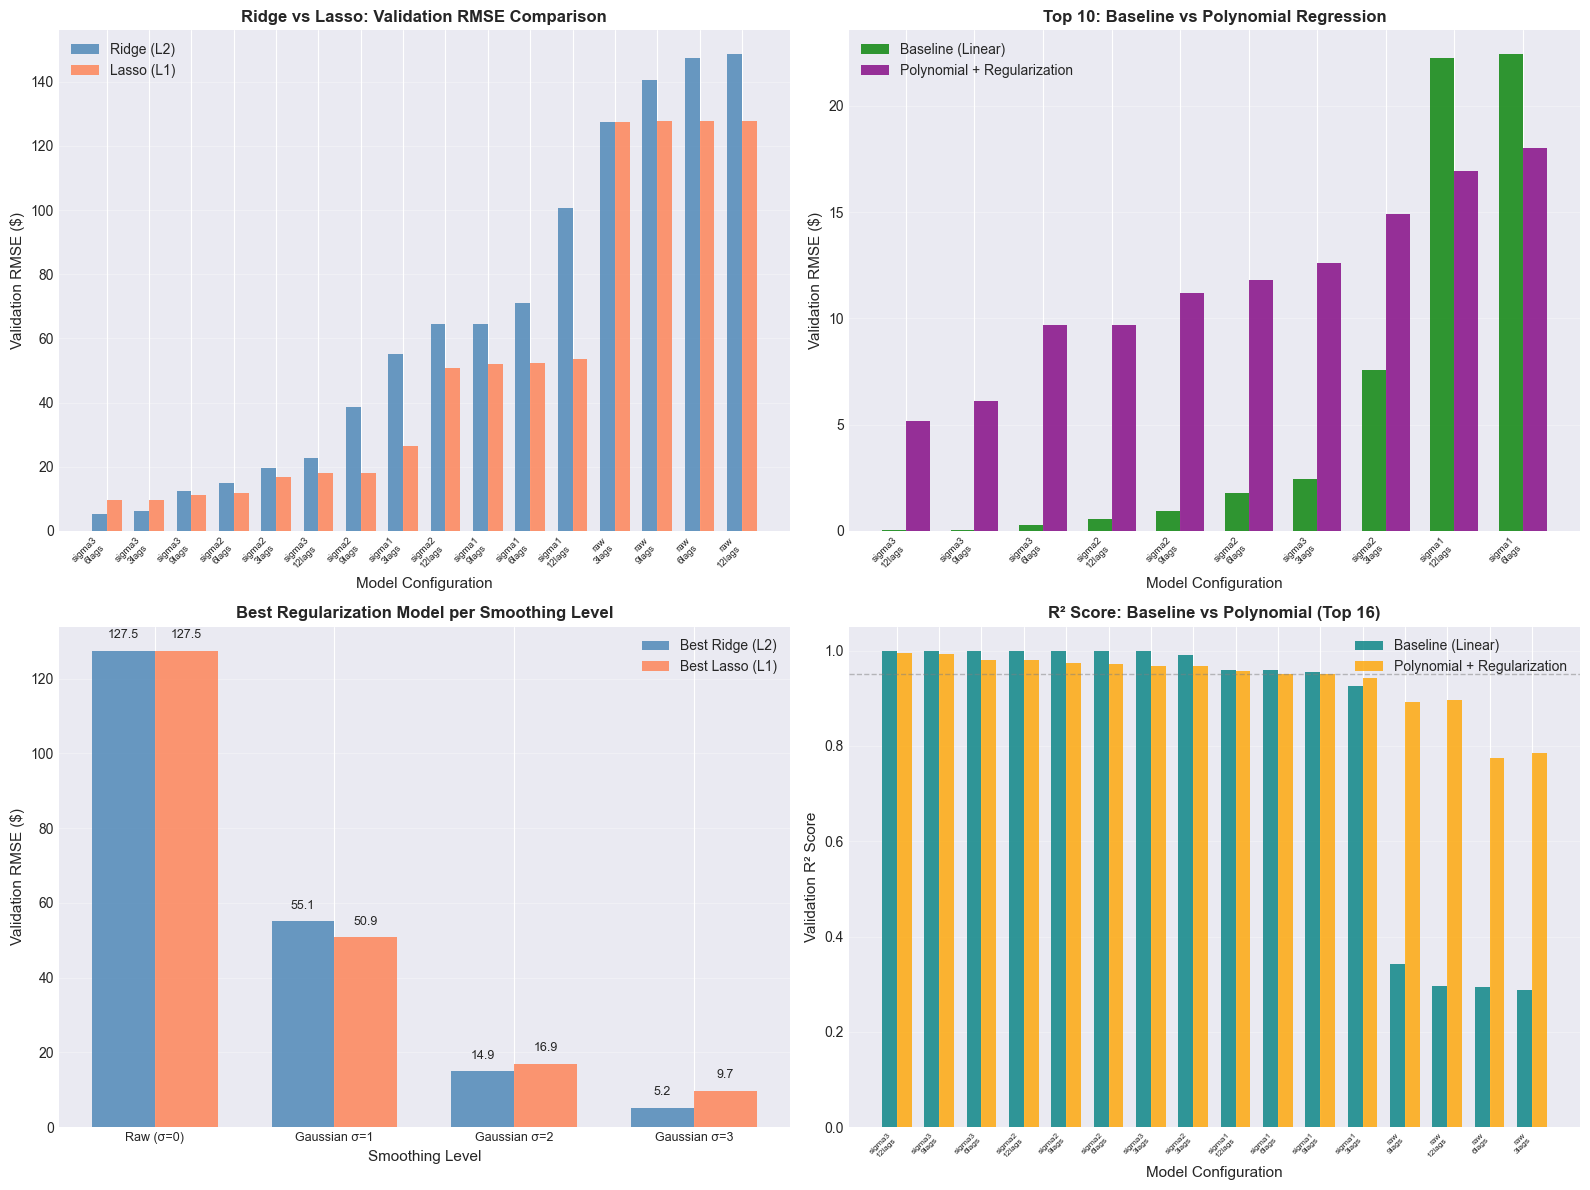

✓ Οπτικοποίηση αποθηκεύτηκε: results/polynomial_regression_comparison.png
✓ Visualization saved: results/polynomial_regression_comparison.png


In [25]:
# Δημιουργία οπτικοποιήσεων (Create visualizations)
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Descriptive label mapping for smoothing levels
label_map = {
    'raw': 'Raw (σ=0)',
    'sigma1': 'Gaussian σ=1',
    'sigma2': 'Gaussian σ=2',
    'sigma3': 'Gaussian σ=3'
}

# 1. Ridge vs Lasso: Validation RMSE
ax1 = axes[0, 0]
ridge_df = poly_results_df[poly_results_df['regularization'] == 'Ridge (L2)'].sort_values('val_rmse')
lasso_df = poly_results_df[poly_results_df['regularization'] == 'Lasso (L1)'].sort_values('val_rmse')

x_pos = np.arange(len(ridge_df))
width = 0.35

bars1 = ax1.bar(x_pos - width/2, ridge_df['val_rmse'], width, label='Ridge (L2)', alpha=0.8, color='steelblue')
bars2 = ax1.bar(x_pos + width/2, lasso_df['val_rmse'], width, label='Lasso (L1)', alpha=0.8, color='coral')

ax1.set_xlabel('Model Configuration', fontsize=11)
ax1.set_ylabel('Validation RMSE ($)', fontsize=11)
ax1.set_title('Ridge vs Lasso: Validation RMSE Comparison', 
             fontsize=12, fontweight='bold')
ax1.legend(fontsize=10, loc='upper left')
ax1.grid(True, alpha=0.3, axis='y')
ax1.set_xticks(x_pos)
# Create descriptive labels showing smoothing and lags
ridge_labels = [f"{row['smoothing']}\n{row['n_lags']}lags" for _, row in ridge_df.iterrows()]
ax1.set_xticklabels(ridge_labels, fontsize=7, rotation=45, ha='right')

# 2. Baseline vs Polynomial: Top 10 comparison
ax2 = axes[0, 1]

# Top 10 από baseline και polynomial (Top 10 from baseline and polynomial)
top10_baseline = results_df.head(10)
top10_poly = poly_results_df.head(10)

baseline_vals = top10_baseline['val_rmse'].values
poly_vals = top10_poly['val_rmse'].values

x_pos = np.arange(10)
bars1 = ax2.bar(x_pos - width/2, baseline_vals, width, label='Baseline (Linear)', alpha=0.8, color='green')
bars2 = ax2.bar(x_pos + width/2, poly_vals, width, label='Polynomial + Regularization', alpha=0.8, color='purple')

ax2.set_xlabel('Model Configuration', fontsize=11)
ax2.set_ylabel('Validation RMSE ($)', fontsize=11)
ax2.set_title('Top 10: Baseline vs Polynomial Regression', 
             fontsize=12, fontweight='bold')
ax2.legend(fontsize=10, loc='upper left')
ax2.grid(True, alpha=0.3, axis='y')
ax2.set_xticks(x_pos)
# Show smoothing and lags for baseline models
baseline_labels = [f"{row['smoothing']}\n{row['n_lags']}lags" for _, row in top10_baseline.iterrows()]
ax2.set_xticklabels(baseline_labels, fontsize=7, rotation=45, ha='right')

# 3. Best models by smoothing and regularization type
ax3 = axes[1, 0]

# For each smoothing level, find best Ridge and Lasso model
smoothing_levels = ['raw', 'sigma1', 'sigma2', 'sigma3']
x_positions = np.arange(len(smoothing_levels))
width = 0.35

ridge_best = []
lasso_best = []

for smoothing in smoothing_levels:
    ridge_best_model = poly_results_df[
        (poly_results_df['smoothing'] == smoothing) & 
        (poly_results_df['regularization'] == 'Ridge (L2)')
    ].sort_values('val_rmse').head(1)
    
    lasso_best_model = poly_results_df[
        (poly_results_df['smoothing'] == smoothing) & 
        (poly_results_df['regularization'] == 'Lasso (L1)')
    ].sort_values('val_rmse').head(1)
    
    ridge_best.append(ridge_best_model['val_rmse'].values[0] if len(ridge_best_model) > 0 else 0)
    lasso_best.append(lasso_best_model['val_rmse'].values[0] if len(lasso_best_model) > 0 else 0)

bars1 = ax3.bar(x_positions - width/2, ridge_best, width, label='Best Ridge (L2)', alpha=0.8, color='steelblue')
bars2 = ax3.bar(x_positions + width/2, lasso_best, width, label='Best Lasso (L1)', alpha=0.8, color='coral')

# Add value labels on bars
max_val = max(max(ridge_best), max(lasso_best))
offset = max_val * 0.02

for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        if height > 0:
            ax3.text(bar.get_x() + bar.get_width()/2., height + offset,
                    f'{height:.1f}',
                    ha='center', va='bottom', fontsize=9)

ax3.set_xlabel('Smoothing Level', fontsize=11)
ax3.set_ylabel('Validation RMSE ($)', fontsize=11)
ax3.set_title('Best Regularization Model per Smoothing Level', 
             fontsize=12, fontweight='bold')
ax3.legend(fontsize=10, loc='upper right')
ax3.grid(True, alpha=0.3, axis='y')
ax3.set_xticks(x_positions)
ax3.set_xticklabels([label_map[s] for s in smoothing_levels], fontsize=9)

# 4. R² Score comparison: Baseline vs Polynomial
ax4 = axes[1, 1]

baseline_r2 = results_df.head(16)['val_r2'].values
poly_r2 = poly_results_df.head(16)['val_r2'].values

x_pos = np.arange(16)
bars1 = ax4.bar(x_pos - width/2, baseline_r2, width, label='Baseline (Linear)', alpha=0.8, color='teal')
bars2 = ax4.bar(x_pos + width/2, poly_r2, width, label='Polynomial + Regularization', alpha=0.8, color='orange')

ax4.set_xlabel('Model Configuration', fontsize=11)
ax4.set_ylabel('Validation R² Score', fontsize=11)
ax4.set_title('R² Score: Baseline vs Polynomial (Top 16)', 
             fontsize=12, fontweight='bold')
ax4.legend(fontsize=10, loc='upper right')
ax4.grid(True, alpha=0.3, axis='y')
ax4.set_xticks(x_pos)
# Show smoothing and lags for baseline models
baseline16_labels = [f"{row['smoothing']}\n{row['n_lags']}lags" for _, row in results_df.head(16).iterrows()]
ax4.set_xticklabels(baseline16_labels, fontsize=6, rotation=45, ha='right')
ax4.axhline(y=0.95, color='gray', linestyle='--', linewidth=1, alpha=0.5)

plt.tight_layout()
plt.savefig("results/polynomial_regression_comparison.png", dpi=150, bbox_inches='tight')
plt.show()

print("✓ Οπτικοποίηση αποθηκεύτηκε: results/polynomial_regression_comparison.png")
print("✓ Visualization saved: results/polynomial_regression_comparison.png")

### 4.5 Αποθήκευση Αποτελεσμάτων
### 4.5 Save Results


In [26]:
# 1. Αποθήκευση αποτελεσμάτων σε CSV (Save results to CSV)
poly_results_filename = "results/polynomial_regression_all_models_results.csv"
poly_results_df.to_csv(poly_results_filename, index=False)
print(f"✓ Αποτελέσματα polynomial αποθηκεύτηκαν (Polynomial results saved): {poly_results_filename}")

# 2. Αποθήκευση ΟΛΩΝ των polynomial μοντέλων (Save ALL polynomial models)
all_poly_models_filename = "models/all_polynomial_models.pkl"
with open(all_poly_models_filename, 'wb') as f:
    pickle.dump(poly_models, f)

print(f"✓ Όλα τα polynomial μοντέλα αποθηκεύτηκαν (All polynomial models saved): {all_poly_models_filename} ({len(poly_models)} models)")

# 3. Αποθήκευση καλύτερου polynomial μοντέλου ξεχωριστά (Save best polynomial model separately)
best_poly_name = best_poly_info['model_name']
best_poly_model_data = poly_models[best_poly_name]

best_poly_filename = "models/best_polynomial_model.pkl"
with open(best_poly_filename, 'wb') as f:
    pickle.dump(best_poly_model_data, f)

print(f"✓ Καλύτερο polynomial μοντέλο αποθηκεύτηκε (Best polynomial model saved): {best_poly_filename}")

# 4. Συνδυασμένα αποτελέσματα: Baseline + Polynomial (Combined results: Baseline + Polynomial)
combined_results = pd.concat([
    results_df.assign(model_type='Baseline'),
    poly_results_df.assign(model_type='Polynomial')
], ignore_index=True)

combined_results = combined_results.sort_values('val_rmse').reset_index(drop=True)
combined_filename = "results/combined_baseline_polynomial_results.csv"
combined_results.to_csv(combined_filename, index=False)
print(f"✓ Συνδυασμένα αποτελέσματα αποθηκεύτηκαν (Combined results saved): {combined_filename}")

# 5. Αποθήκευση πληροφοριών καλύτερου polynomial μοντέλου (Save best polynomial model info)
best_poly_info_filename = "results/best_polynomial_model_info.txt"
with open(best_poly_info_filename, 'w', encoding='utf-8') as f:
    f.write("="*70 + "\n")
    f.write("ΚΑΛΥΤΕΡΟ POLYNOMIAL ΜΟΝΤΕΛΟ (BEST POLYNOMIAL MODEL)\n")
    f.write("="*70 + "\n\n")
    f.write(f"Model Name: {best_poly_info['model_name']}\n")
    f.write(f"Regularization: {best_poly_info['regularization']}\n")
    f.write(f"Smoothing: {best_poly_info['smoothing']}\n")
    f.write(f"N_Lags: {best_poly_info['n_lags']}\n")
    f.write(f"Alpha: {best_poly_info['alpha']}\n")
    f.write(f"Polynomial Features: {best_poly_info['n_poly_features']}\n\n")
    f.write("Validation Metrics:\n")
    f.write(f"  RMSE: ${best_poly_info['val_rmse']:.2f}\n")
    f.write(f"  MAE:  ${best_poly_info['val_mae']:.2f}\n")
    f.write(f"  R²:   {best_poly_info['val_r2']:.4f}\n\n")
    f.write("Training Metrics:\n")
    f.write(f"  RMSE: ${best_poly_info['train_rmse']:.2f}\n\n")
    f.write("="*70 + "\n")
    f.write("ΣΥΓΚΡΙΣΗ ΜΕ BASELINE (COMPARISON WITH BASELINE)\n")
    f.write("="*70 + "\n\n")
    f.write(f"Baseline Best Val RMSE: ${best_model_info['val_rmse']:.2f}\n")
    f.write(f"Polynomial Best Val RMSE: ${best_poly_info['val_rmse']:.2f}\n")
    improvement = best_model_info['val_rmse'] - best_poly_info['val_rmse']
    improvement_pct = (improvement / best_model_info['val_rmse']) * 100
    f.write(f"Improvement: ${improvement:.2f} ({improvement_pct:.2f}%)\n")
    f.write("="*70 + "\n")

print(f"✓ Πληροφορίες καλύτερου polynomial μοντέλου αποθηκεύτηκαν (Best polynomial model info saved): {best_poly_info_filename}")

print(f"\n{'='*70}")
print("✓ ΒΗΜΑ 4 ΟΛΟΚΛΗΡΩΘΗΚΕ (STEP 4 COMPLETED)")
print(f"{'='*70}")
print(f"\nΑρχεία που δημιουργήθηκαν (Files created):")
print(f"  1. {poly_results_filename}")
print(f"  2. {all_poly_models_filename} - ALL 32 polynomial models")
print(f"  3. {best_poly_filename}")
print(f"  4. {combined_filename}")
print(f"  5. {best_poly_info_filename}")
print(f"  6. results/polynomial_regression_comparison.png")


✓ Αποτελέσματα polynomial αποθηκεύτηκαν (Polynomial results saved): results/polynomial_regression_all_models_results.csv
✓ Όλα τα polynomial μοντέλα αποθηκεύτηκαν (All polynomial models saved): models/all_polynomial_models.pkl (32 models)
✓ Καλύτερο polynomial μοντέλο αποθηκεύτηκε (Best polynomial model saved): models/best_polynomial_model.pkl
✓ Συνδυασμένα αποτελέσματα αποθηκεύτηκαν (Combined results saved): results/combined_baseline_polynomial_results.csv
✓ Πληροφορίες καλύτερου polynomial μοντέλου αποθηκεύτηκαν (Best polynomial model info saved): results/best_polynomial_model_info.txt

✓ ΒΗΜΑ 4 ΟΛΟΚΛΗΡΩΘΗΚΕ (STEP 4 COMPLETED)

Αρχεία που δημιουργήθηκαν (Files created):
  1. results/polynomial_regression_all_models_results.csv
  2. models/all_polynomial_models.pkl - ALL 32 polynomial models
  3. models/best_polynomial_model.pkl
  4. results/combined_baseline_polynomial_results.csv
  5. results/best_polynomial_model_info.txt
  6. results/polynomial_regression_comparison.png


---

## ΒΗΜΑ 5: DIMENSIONALITY REDUCTION
## STEP 5: DIMENSIONALITY REDUCTION

### Περιγραφή (Description)

Σε αυτό το βήμα εφαρμόζουμε **τεχνικές μείωσης διαστάσεων** για να αντιμετωπίσουμε:  
In this step we apply **dimensionality reduction techniques** to address:

1. **Πολυσυγγραμμικότητα (Multicollinearity)**: Συσχετισμένα χαρακτηριστικά
   - Correlated features

2. **Curse of Dimensionality**: Πάρα πολλά χαρακτηριστικά σε σχέση με δείγματα
   - Too many features relative to samples

3. **Overfitting**: Μοντέλα που μαθαίνουν θόρυβο αντί για σήμα
   - Models learning noise instead of signal

**Τρεις Μέθοδοι Μείωσης Διαστάσεων (Three Dimensionality Reduction Methods)**:

1. **PCA (Principal Component Analysis)**: Διατηρεί 95% της διακύμανσης
   - Keeps 95% of variance

2. **CFS (Correlation-based Feature Selection)**: Επιλέγει χαρακτηριστικά με χαμηλή αλληλοσυσχέτιση
   - Selects features with low inter-correlation

3. **SFS (Sequential Forward Selection)**: Προσθέτει χαρακτηριστικά ένα-ένα για βελτίωση απόδοσης
   - Adds features one-by-one to improve performance

**Συνολικά 48 Μοντέλα (Total 48 Models)**:
- 16 feature sets × 3 reduction methods = **48 models**

### Μαθηματικό Υπόβαθρο (Mathematical Background)

**1. PCA (Principal Component Analysis)**:

Μετασχηματίζει χαρακτηριστικά σε ορθογώνιες κύριες συνιστώσες:  
Transforms features into orthogonal principal components:

$$PC_i = \sum_{j=1}^{p} w_{ij} x_j$$

Όπου (Where):
- $PC_i$: i-η κύρια συνιστώσα (i-th principal component)
- $w_{ij}$: Βάρη από eigenvectors της συνδιακύμανσης (Weights from covariance eigenvectors)
- Διατηρούμε συνιστώσες που εξηγούν 95% της διακύμανσης
  (Keep components explaining 95% of variance)

**Πλεονεκτήματα (Advantages)**:
- Αφαιρεί πολυσυγγραμμικότητα (Removes multicollinearity)
- Μειώνει διαστάσεις διατηρώντας πληροφορία (Reduces dimensions while preserving information)

**2. CFS (Correlation-based Feature Selection)**:

Επιλέγει χαρακτηριστικά που:  
Selects features that:
- Έχουν **υψηλή συσχέτιση με τον στόχο** (High correlation with target)
- Έχουν **χαμηλή συσχέτιση μεταξύ τους** (Low inter-correlation)

Αλγόριθμος (Algorithm):
1. Υπολογίζει correlation matrix
2. Αφαιρεί χαρακτηριστικά με |correlation| > threshold (0.85)
3. Διατηρεί το πιο σημαντικό από κάθε συσχετισμένο ζεύγος

**3. SFS (Sequential Forward Selection)**:

Greedy αλγόριθμος που προσθέτει χαρακτηριστικά βήμα-βήμα:  
Greedy algorithm that adds features step-by-step:

```
1. Αρχίζει με κενό σύνολο (Start with empty set)
2. Για κάθε χαρακτηριστικό:
   - Προσθέτει και εκπαιδεύει μοντέλο (Add and train model)
   - Αξιολογεί απόδοση (Evaluate performance)
3. Κρατάει το χαρακτηριστικό που βελτιώνει περισσότερο
   (Keep feature that improves most)
4. Επαναλαμβάνει μέχρι το max_features (Repeat until max_features)
```

**Πλεονέκτημα (Advantage)**: Επιλέγει χαρακτηριστικά που όντως βοηθούν το μοντέλο  
**Advantage**: Selects features that actually help the model

### Στόχοι (Objectives)

✓ Μείωση διαστάσεων για καλύτερη γενίκευση  
✓ Reduce dimensions for better generalization

✓ Αντιμετώπιση overfitting και πολυσυγγραμμικότητας  
✓ Address overfitting and multicollinearity

✓ Σύγκριση 3 διαφορετικών προσεγγίσεων μείωσης διαστάσεων  
✓ Compare 3 different dimensionality reduction approaches

✓ Αναγνώριση των πιο σημαντικών χαρακτηριστικών  
✓ Identify the most important features

### 5.1 Συναρτήσεις Μείωσης Διαστάσεων (Dimensionality Reduction Functions)


In [27]:
def apply_pca(X_train, X_val, variance_threshold=0.95):
    """
    Εφαρμόζει PCA διατηρώντας συγκεκριμένο ποσοστό διακύμανσης.
    Applies PCA keeping a specific percentage of variance.
    
    Παράμετροι (Args):
        X_train: Training features
        X_val: Validation features
        variance_threshold (float): Ποσοστό διακύμανσης να διατηρηθεί (0-1)
                                      (Percentage of variance to keep (0-1))
    
    Επιστρέφει (Returns):
        tuple: (X_train_pca, X_val_pca, pca_transformer, n_components)
    
    Σημειώσεις (Notes):
        - PCA προσαρμόζεται μόνο στο training set (PCA fitted only on training set)
        - Επιλέγει αυτόματα τον αριθμό συνιστωσών για το variance_threshold
          (Automatically selects number of components for variance_threshold)
        - Κάθε principal component είναι γραμμικός συνδυασμός αρχικών χαρακτηριστικών
          (Each principal component is linear combination of original features)
    """
    pca = PCA(n_components=variance_threshold, random_state=42)
    
    # Προσαρμογή και μετασχηματισμός training (Fit and transform training)
    X_train_pca = pca.fit_transform(X_train)
    
    # Μετασχηματισμός validation (Transform validation)
    X_val_pca = pca.transform(X_val)
    
    n_components = pca.n_components_
    explained_variance = np.sum(pca.explained_variance_ratio_)
    
    print(f"  PCA:")
    print(f"    Αρχικά features (Original features): {X_train.shape[1]}")
    print(f"    Principal Components: {n_components}")
    print(f"    Explained Variance: {explained_variance:.4f} ({explained_variance*100:.2f}%)")
    print(f"    Μείωση (Reduction): {X_train.shape[1] - n_components} features")
    
    return X_train_pca, X_val_pca, pca, n_components


def apply_correlation_feature_selection(X_train, X_val, y_train, feature_names, threshold=0.85):
    """
    Εφαρμόζει Correlation-based Feature Selection (CFS).
    Applies Correlation-based Feature Selection (CFS).
    
    Αφαιρεί χαρακτηριστικά που είναι πολύ συσχετισμένα μεταξύ τους (|corr| > threshold).
    Removes features that are highly correlated with each other (|corr| > threshold).
    
    Παράμετροι (Args):
        X_train: Training features
        X_val: Validation features
        y_train: Training targets
        feature_names: Ονόματα χαρακτηριστικών (Feature names)
        threshold (float): Όριο συσχέτισης (Correlation threshold) - προεπιλογή 0.85
    
    Επιστρέφει (Returns):
        tuple: (X_train_selected, X_val_selected, selected_indices, selected_names)
    
    Αλγόριθμος (Algorithm):
        1. Υπολογίζει correlation matrix των χαρακτηριστικών
           (Compute feature correlation matrix)
        2. Για κάθε ζεύγος με |corr| > threshold:
           - Υπολογίζει συσχέτιση κάθε feature με target
           - Κρατάει το feature με υψηλότερη |corr| με target
        3. Επιστρέφει το μειωμένο σύνολο χαρακτηριστικών
           (Returns reduced feature set)
    """
    # Δημιουργία DataFrame για ευκολία (Create DataFrame for convenience)
    df = pd.DataFrame(X_train, columns=feature_names)
    
    # Υπολογισμός correlation matrix (Compute correlation matrix)
    corr_matrix = df.corr().abs()
    
    # Συσχέτιση με target (Correlation with target)
    target_corr = df.corrwith(pd.Series(y_train)).abs()
    
    # Εύρεση πολύ συσχετισμένων ζευγών (Find highly correlated pairs)
    upper_triangle = np.triu(np.ones(corr_matrix.shape), k=1).astype(bool)
    highly_correlated = (corr_matrix.where(upper_triangle) > threshold)
    
    # Επιλογή features να κρατηθούν (Select features to keep)
    features_to_drop = set()
    
    for feature in highly_correlated.columns:
        correlated_features = highly_correlated.index[highly_correlated[feature]].tolist()
        
        if correlated_features:
            # Από κάθε συσχετισμένο ζεύγος, κράτα το feature με υψηλότερη συσχέτιση με target
            # From each correlated pair, keep feature with highest correlation with target
            for corr_feature in correlated_features:
                if target_corr[feature] < target_corr[corr_feature]:
                    features_to_drop.add(feature)
                else:
                    features_to_drop.add(corr_feature)
    
    # Δημιουργία λίστας επιλεγμένων features (Create list of selected features)
    selected_indices = [i for i, name in enumerate(feature_names) if name not in features_to_drop]
    selected_names = [feature_names[i] for i in selected_indices]
    
    # Εφαρμογή επιλογής (Apply selection)
    X_train_selected = X_train[:, selected_indices]
    X_val_selected = X_val[:, selected_indices]
    
    print(f"  CFS (Correlation-based Feature Selection):")
    print(f"    Αρχικά features (Original features): {X_train.shape[1]}")
    print(f"    Επιλεγμένα features (Selected features): {len(selected_indices)}")
    print(f"    Αφαιρέθηκαν (Removed): {X_train.shape[1] - len(selected_indices)} features")
    print(f"    Correlation threshold: {threshold}")
    
    return X_train_selected, X_val_selected, selected_indices, selected_names


def apply_sequential_forward_selection(X_train, X_val, y_train, y_val, max_features=None):
    """
    Εφαρμόζει Sequential Forward Selection (SFS).
    Applies Sequential Forward Selection (SFS).
    
    Προσθέτει χαρακτηριστικά ένα-ένα, επιλέγοντας κάθε φορά το χαρακτηριστικό
    που βελτιώνει περισσότερο την απόδοση του μοντέλου.
    Adds features one-by-one, selecting each time the feature that improves
    model performance the most.
    
    Παράμετροι (Args):
        X_train, y_train: Training data
        X_val, y_val: Validation data
        max_features (int): Μέγιστος αριθμός features να επιλεγούν
                            (Maximum number of features to select)
                            Αν None, επιλέγει n_features // 2
    
    Επιστρέφει (Returns):
        tuple: (X_train_sfs, X_val_sfs, selector, n_features_selected)
    
    Σημειώσεις (Notes):
        - Χρησιμοποιεί LinearRegression ως base estimator
        - Scoring: 'neg_mean_squared_error' (ελαχιστοποίηση MSE)
        - Μπορεί να διαρκέσει περισσότερο από PCA/CFS
          (Can take longer than PCA/CFS)
    """
    if max_features is None:
        max_features = max(1, X_train.shape[1] // 2)
    
    # Περιορισμός max_features στον αριθμό διαθέσιμων features
    # Limit max_features to number of available features
    max_features = min(max_features, X_train.shape[1])
    
    print(f"  SFS (Sequential Forward Selection):")
    print(f"    Αρχικά features (Original features): {X_train.shape[1]}")
    print(f"    Target features: {max_features}")
    
    # Δημιουργία selector (Create selector)
    selector = SequentialFeatureSelector(
        LinearRegression(),
        n_features_to_select=max_features,
        direction='forward',
        scoring='neg_mean_squared_error',
        cv=None,  # Χωρίς cross-validation - χρησιμοποιούμε validation set
        n_jobs=-1
    )
    
    # Προσαρμογή στο training set (Fit on training set)
    selector.fit(X_train, y_train)
    
    # Μετασχηματισμός (Transform)
    X_train_sfs = selector.transform(X_train)
    X_val_sfs = selector.transform(X_val)
    
    n_features_selected = X_train_sfs.shape[1]
    
    print(f"    Επιλεγμένα features (Selected features): {n_features_selected}")
    print(f"    Μείωση (Reduction): {X_train.shape[1] - n_features_selected} features")
    
    return X_train_sfs, X_val_sfs, selector, n_features_selected

### 5.2 Εκτέλεση: Εφαρμογή 3 Μεθόδων Μείωσης Διαστάσεων
### 5.2 Execution: Apply 3 Dimensionality Reduction Methods

Για κάθε feature set εφαρμόζουμε:  
For each feature set we apply:
- **PCA**: Διατηρώντας 95% της διακύμανσης
- **CFS**: Αφαιρώντας συσχετισμένα features
- **SFS**: Επιλέγοντας features με forward selection

Total: 16 feature sets × 3 methods = **48 models**

In [28]:
print("="*70)
print("ΒΗΜΑ 5: DIMENSIONALITY REDUCTION")
print("STEP 5: DIMENSIONALITY REDUCTION")
print("="*70)

# Ρυθμίσεις (Configurations)
smoothing_levels = ["raw", "sigma1", "sigma2", "sigma3"]
lag_configs = [3, 6, 9, 12]

# Λίστα για αποθήκευση αποτελεσμάτων (List to store results)
dimred_results = []

# Dictionary για αποθήκευση μοντέλων (Dictionary to store models)
dimred_models = {}

# Μετρητής (Counter)
model_count = 0

# Επανάληψη για όλους τους συνδυασμούς (Loop through all combinations)
for smoothing in smoothing_levels:
    for n_lags in lag_configs:
        model_count += 1
        print(f"\n{'='*70}")
        print(f"Feature Set [{model_count}/16]: {smoothing} με (with) {n_lags} lags")
        print(f"{'='*70}")
        
        # 1. Φόρτωση feature set (Load feature set)
        features_file = f"features/features_{smoothing}_{n_lags}lags.npz"
        data = np.load(features_file, allow_pickle=True)
        
        X_train = data['X_train']
        X_val = data['X_val']
        y_train = data['y_train']
        y_val = data['y_val']
        feature_names = data['feature_names']
        
        print(f"Αρχικά χαρακτηριστικά (Original features): {X_train.shape[1]}")
        
        # ============================================================
        # 2. PCA
        # ============================================================
        print(f"\n[1/3] Εφαρμογή PCA (Applying PCA)...")
        X_train_pca, X_val_pca, pca_transformer, n_pca_components = apply_pca(
            X_train, X_val, variance_threshold=0.95
        )
        
        # Εκπαίδευση μοντέλου με PCA features (Train model with PCA features)
        pca_name = f"LR_PCA_{smoothing}_{n_lags}lags"
        pca_model, pca_metrics = train_and_evaluate_linear_model(
            X_train_pca, y_train, X_val_pca, y_val, model_name=pca_name
        )
        
        # Προσθήκη πληροφοριών (Add info)
        pca_metrics['smoothing'] = smoothing
        pca_metrics['n_lags'] = n_lags
        pca_metrics['reduction_method'] = 'PCA'
        pca_metrics['n_features_reduced'] = n_pca_components
        pca_metrics['n_features_original'] = X_train.shape[1]
        
        dimred_results.append(pca_metrics)
        dimred_models[pca_name] = {
            'model': pca_model,
            'transformer': pca_transformer,
            'n_features': n_pca_components
        }
        
        print(f"  Απόδοση (Performance): Val RMSE = ${pca_metrics['val_rmse']:.2f}, R² = {pca_metrics['val_r2']:.4f}")
        
        # ============================================================
        # 3. CFS (Correlation-based Feature Selection)
        # ============================================================
        print(f"\n[2/3] Εφαρμογή CFS (Applying CFS)...")
        X_train_cfs, X_val_cfs, cfs_indices, cfs_names = apply_correlation_feature_selection(
            X_train, X_val, y_train, feature_names, threshold=0.85
        )
        
        # Εκπαίδευση μοντέλου με CFS features (Train model with CFS features)
        cfs_name = f"LR_CFS_{smoothing}_{n_lags}lags"
        cfs_model, cfs_metrics = train_and_evaluate_linear_model(
            X_train_cfs, y_train, X_val_cfs, y_val, model_name=cfs_name
        )
        
        # Προσθήκη πληροφοριών (Add info)
        cfs_metrics['smoothing'] = smoothing
        cfs_metrics['n_lags'] = n_lags
        cfs_metrics['reduction_method'] = 'CFS'
        cfs_metrics['n_features_reduced'] = len(cfs_indices)
        cfs_metrics['n_features_original'] = X_train.shape[1]
        
        dimred_results.append(cfs_metrics)
        dimred_models[cfs_name] = {
            'model': cfs_model,
            'selected_indices': cfs_indices,
            'selected_names': cfs_names,
            'n_features': len(cfs_indices)
        }
        
        print(f"  Απόδοση (Performance): Val RMSE = ${cfs_metrics['val_rmse']:.2f}, R² = {cfs_metrics['val_r2']:.4f}")
        
        # ============================================================
        # 4. SFS (Sequential Forward Selection)
        # ============================================================
        print(f"\n[3/3] Εφαρμογή SFS (Applying SFS)...")
        max_features = max(1, X_train.shape[1] // 2)
        X_train_sfs, X_val_sfs, sfs_selector, n_sfs_features = apply_sequential_forward_selection(
            X_train, X_val, y_train, y_val, max_features=max_features
        )
        
        # Εκπαίδευση μοντέλου με SFS features (Train model with SFS features)
        sfs_name = f"LR_SFS_{smoothing}_{n_lags}lags"
        sfs_model, sfs_metrics = train_and_evaluate_linear_model(
            X_train_sfs, y_train, X_val_sfs, y_val, model_name=sfs_name
        )
        
        # Προσθήκη πληροφοριών (Add info)
        sfs_metrics['smoothing'] = smoothing
        sfs_metrics['n_lags'] = n_lags
        sfs_metrics['reduction_method'] = 'SFS'
        sfs_metrics['n_features_reduced'] = n_sfs_features
        sfs_metrics['n_features_original'] = X_train.shape[1]
        
        dimred_results.append(sfs_metrics)
        dimred_models[sfs_name] = {
            'model': sfs_model,
            'selector': sfs_selector,
            'n_features': n_sfs_features
        }
        
        print(f"  Απόδοση (Performance): Val RMSE = ${sfs_metrics['val_rmse']:.2f}, R² = {sfs_metrics['val_r2']:.4f}")
        
        # Σύγκριση 3 μεθόδων (Comparison of 3 methods)
        print(f"\n  Σύγκριση Μεθόδων (Methods Comparison):")
        print(f"    PCA:  {n_pca_components} features → Val RMSE ${pca_metrics['val_rmse']:.2f}")
        print(f"    CFS:  {len(cfs_indices)} features → Val RMSE ${cfs_metrics['val_rmse']:.2f}")
        print(f"    SFS:  {n_sfs_features} features → Val RMSE ${sfs_metrics['val_rmse']:.2f}")

print(f"\n{'='*70}")
print(f"✓ ΟΛΟΚΛΗΡΩΘΗΚΕ (COMPLETED): {model_count * 3}/48 μοντέλα εκπαιδεύτηκαν!")
print(f"✓ COMPLETED: {model_count * 3}/48 models trained!")
print(f"  - {model_count} PCA μοντέλα (PCA models)")
print(f"  - {model_count} CFS μοντέλα (CFS models)")
print(f"  - {model_count} SFS μοντέλα (SFS models)")
print(f"{'='*70}")

ΒΗΜΑ 5: DIMENSIONALITY REDUCTION
STEP 5: DIMENSIONALITY REDUCTION

Feature Set [1/16]: raw με (with) 3 lags
Αρχικά χαρακτηριστικά (Original features): 6

[1/3] Εφαρμογή PCA (Applying PCA)...
  PCA:
    Αρχικά features (Original features): 6
    Principal Components: 3
    Explained Variance: 0.9635 (96.35%)
    Μείωση (Reduction): 3 features
  Απόδοση (Performance): Val RMSE = $148.01, R² = -0.0524

[2/3] Εφαρμογή CFS (Applying CFS)...
  CFS (Correlation-based Feature Selection):
    Αρχικά features (Original features): 6
    Επιλεγμένα features (Selected features): 4
    Αφαιρέθηκαν (Removed): 2 features
    Correlation threshold: 0.85
  Απόδοση (Performance): Val RMSE = $126.87, R² = 0.2268

[3/3] Εφαρμογή SFS (Applying SFS)...
  SFS (Sequential Forward Selection):
    Αρχικά features (Original features): 6
    Target features: 3
    Επιλεγμένα features (Selected features): 3
    Μείωση (Reduction): 3 features
  Απόδοση (Performance): Val RMSE = $120.30, R² = 0.3048

  Σύγκριση Μεθόδ

### 5.3 Αποτελέσματα: Σύγκριση Μεθόδων Μείωσης Διαστάσεων
### 5.3 Results: Comparison of Dimensionality Reduction Methods


In [29]:
# Δημιουργία DataFrame με αποτελέσματα (Create DataFrame with results)
dimred_results_df = pd.DataFrame(dimred_results)

# Ταξινόμηση κατά validation RMSE (Sort by validation RMSE)
dimred_results_df = dimred_results_df.sort_values('val_rmse').reset_index(drop=True)

# Εμφάνιση πίνακα αποτελεσμάτων (Display results table)
print("\nΠίνακας Αποτελεσμάτων Dimensionality Reduction (Dimensionality Reduction Results Table):")
print("="*110)
print(dimred_results_df[['model_name', 'reduction_method', 'smoothing', 'n_lags', 
                          'n_features_reduced', 'val_rmse', 'val_mae', 'val_r2']].to_string(index=False))
print("="*110)

# Εύρεση καλύτερου dimred μοντέλου (Find best dimred model)
best_dimred_idx = dimred_results_df['val_rmse'].idxmin()
best_dimred_info = dimred_results_df.iloc[best_dimred_idx]

print(f"\n{'='*70}")
print("ΚΑΛΥΤΕΡΟ DIMENSIONALITY REDUCTION ΜΟΝΤΕΛΟ (BEST DIMRED MODEL)")
print(f"{'='*70}")
print(f"  Όνομα (Name): {best_dimred_info['model_name']}")
print(f"  Reduction Method: {best_dimred_info['reduction_method']}")
print(f"  Smoothing: {best_dimred_info['smoothing']}")
print(f"  N_Lags: {best_dimred_info['n_lags']}")
print(f"  Features: {best_dimred_info['n_features_original']} → {best_dimred_info['n_features_reduced']}")
print(f"\n  Validation Metrics:")
print(f"    RMSE: ${best_dimred_info['val_rmse']:.2f}")
print(f"    MAE:  ${best_dimred_info['val_mae']:.2f}")
print(f"    R²:   {best_dimred_info['val_r2']:.4f}")
print(f"{'='*70}")

# Στατιστικά ανά μέθοδο (Statistics by method)
print(f"\nΣτατιστικά ανά Μέθοδο (Statistics by Method):")
print(f"{'='*70}")

for method in ['PCA', 'CFS', 'SFS']:
    method_results = dimred_results_df[dimred_results_df['reduction_method'] == method]
    print(f"\n{method}:")
    print(f"  Μέσος όρος Val RMSE (Average Val RMSE): ${method_results['val_rmse'].mean():.2f}")
    print(f"  Καλύτερο Val RMSE (Best Val RMSE): ${method_results['val_rmse'].min():.2f}")
    print(f"  Χειρότερο Val RMSE (Worst Val RMSE): ${method_results['val_rmse'].max():.2f}")
    print(f"  Μέσος όρος R² (Average R²): {method_results['val_r2'].mean():.4f}")
    print(f"  Μέσος αριθμός features (Average features): {method_results['n_features_reduced'].mean():.1f}")

# Σύγκριση με baseline και polynomial (Comparison with baseline and polynomial)
print(f"\n{'='*70}")
print("ΣΥΓΚΡΙΣΗ ΟΛΩΝ ΤΩΝ ΠΡΟΣΕΓΓΙΣΕΩΝ (COMPARISON OF ALL APPROACHES)")
print(f"{'='*70}")
print(f"  Baseline Best Val RMSE: ${best_model_info['val_rmse']:.2f}")
print(f"  Polynomial Best Val RMSE: ${best_poly_info['val_rmse']:.2f}")
print(f"  DimRed Best Val RMSE: ${best_dimred_info['val_rmse']:.2f}")

# Καλύτερη συνολικά προσέγγιση (Overall best approach)
all_best_rmse = [
    ('Baseline', best_model_info['val_rmse']),
    ('Polynomial', best_poly_info['val_rmse']),
    ('DimRed', best_dimred_info['val_rmse'])
]
overall_best = min(all_best_rmse, key=lambda x: x[1])
print(f"\n  Καλύτερη συνολικά προσέγγιση (Overall best approach): {overall_best[0]} (RMSE: ${overall_best[1]:.2f})")
print(f"{'='*70}")


Πίνακας Αποτελεσμάτων Dimensionality Reduction (Dimensionality Reduction Results Table):
          model_name reduction_method smoothing  n_lags  n_features_reduced   val_rmse    val_mae    val_r2
LR_SFS_sigma3_12lags              SFS    sigma3      12                  12   0.062219   0.056413  0.999999
 LR_SFS_sigma3_9lags              SFS    sigma3       9                   9   0.062366   0.056115  0.999999
 LR_SFS_sigma3_6lags              SFS    sigma3       6                   6   0.284148   0.252382  0.999983
LR_SFS_sigma2_12lags              SFS    sigma2      12                  12   0.559575   0.431133  0.999953
 LR_SFS_sigma2_9lags              SFS    sigma2       9                   9   0.932289   0.785929  0.999869
 LR_SFS_sigma2_6lags              SFS    sigma2       6                   6   1.774788   1.494409  0.999527
 LR_SFS_sigma3_3lags              SFS    sigma3       3                   3   2.415487   1.931494  0.998786
 LR_SFS_sigma2_3lags              SFS    sigma

### 5.4 Οπτικοποίηση: Σύγκριση Μεθόδων Μείωσης Διαστάσεων
### 5.4 Visualization: Dimensionality Reduction Methods Comparison


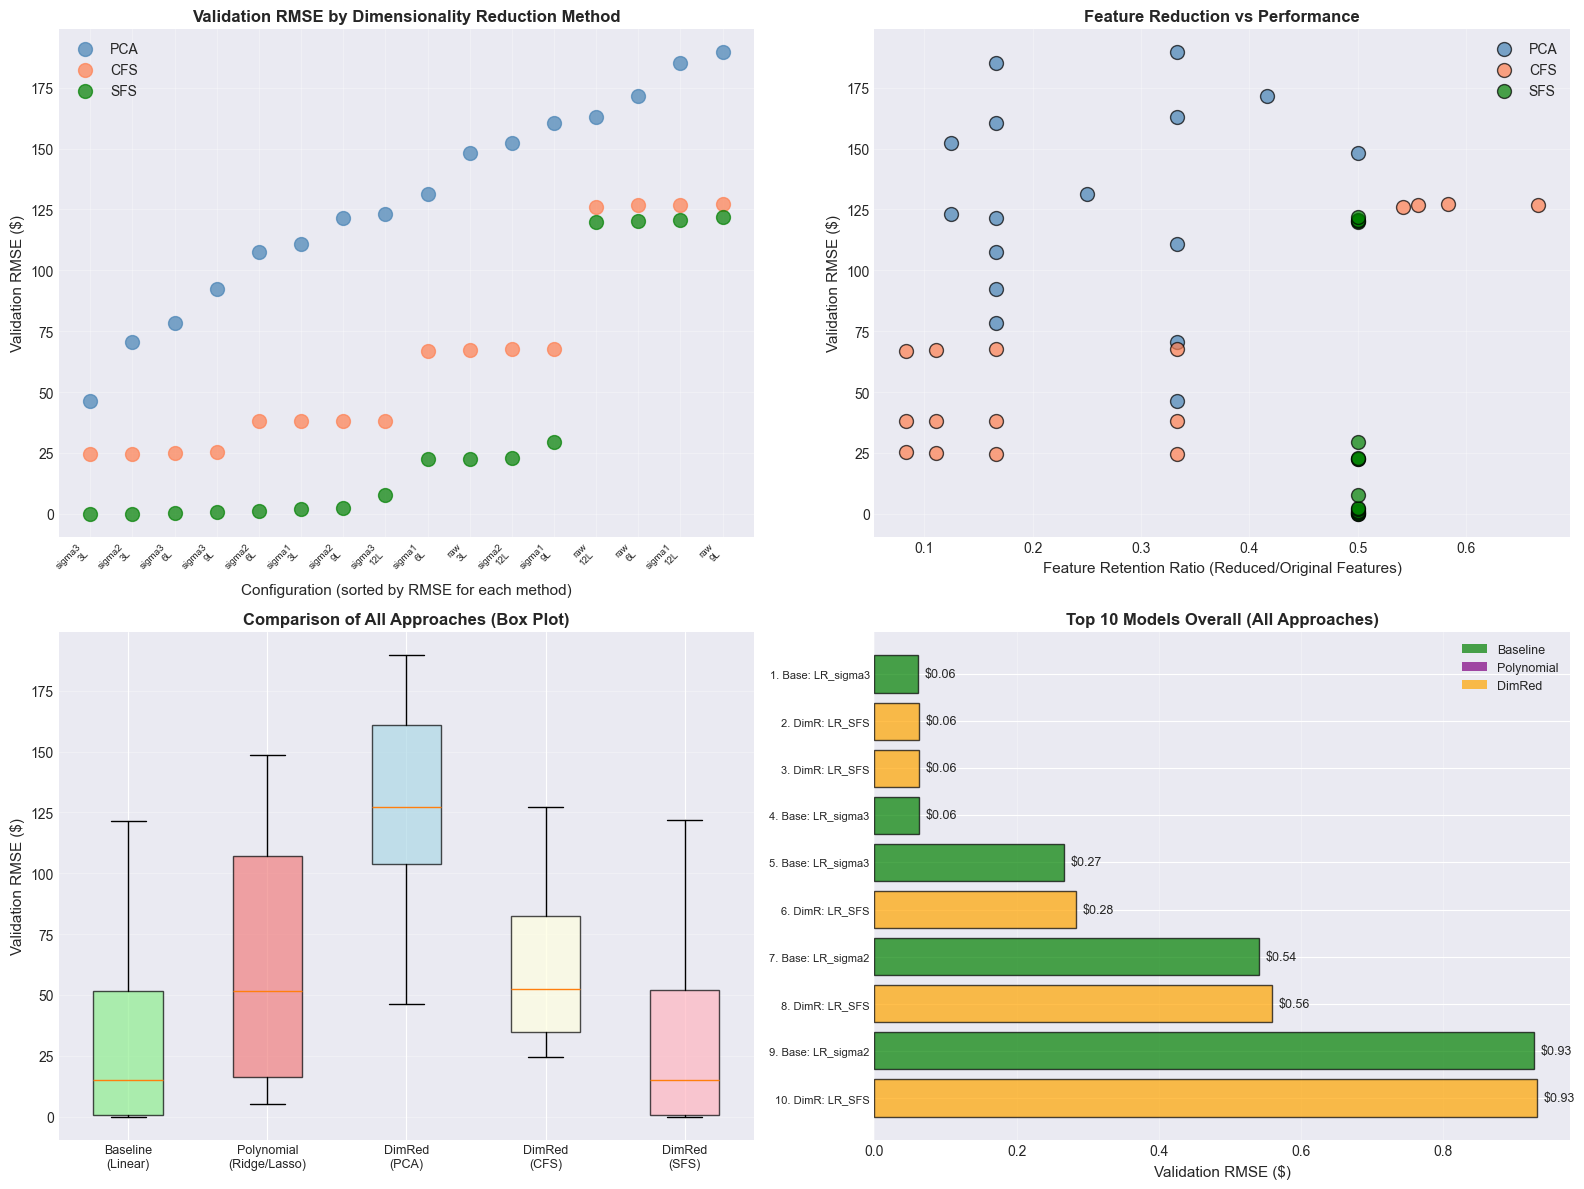

✓ Οπτικοποίηση αποθηκεύτηκε: results/dimensionality_reduction_comparison.png
✓ Visualization saved: results/dimensionality_reduction_comparison.png


In [30]:
# Δημιουργία οπτικοποιήσεων (Create visualizations)
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. Validation RMSE by Reduction Method
ax1 = axes[0, 0]

methods = ['PCA', 'CFS', 'SFS']
colors = ['steelblue', 'coral', 'green']

for method, color in zip(methods, colors):
    method_data = dimred_results_df[dimred_results_df['reduction_method'] == method].sort_values('val_rmse')
    x_pos = np.arange(len(method_data))
    ax1.scatter(x_pos, method_data['val_rmse'], label=method, alpha=0.7, s=100, color=color)
    
    # Add x-tick labels showing smoothing and lags for each method
    if len(method_data) > 0:
        # Get the x-tick positions for this method (they're sorted by RMSE)
        method_labels = [f"{row['smoothing']}\n{row['n_lags']}lags" for _, row in method_data.iterrows()]

# Set x-tick labels based on one method's configuration (they all have same configs, just different RMSE)
# Use the first method to get the configuration labels
first_method_data = dimred_results_df[dimred_results_df['reduction_method'] == methods[0]].sort_values('val_rmse')
x_labels = [f"{row['smoothing']}\n{row['n_lags']}L" for _, row in first_method_data.iterrows()]
ax1.set_xticks(np.arange(len(first_method_data)))
ax1.set_xticklabels(x_labels, fontsize=7, rotation=45, ha='right')

ax1.set_xlabel('Configuration (sorted by RMSE for each method)', fontsize=11)
ax1.set_ylabel('Validation RMSE ($)', fontsize=11)
ax1.set_title('Validation RMSE by Dimensionality Reduction Method', 
             fontsize=12, fontweight='bold')
ax1.legend(fontsize=10, loc='upper left')
ax1.grid(True, alpha=0.3)

# 2. Feature Reduction vs Performance
ax2 = axes[0, 1]

for method, color in zip(methods, colors):
    method_data = dimred_results_df[dimred_results_df['reduction_method'] == method]
    reduction_ratio = method_data['n_features_reduced'] / method_data['n_features_original']
    ax2.scatter(reduction_ratio, method_data['val_rmse'], label=method, 
               alpha=0.7, s=100, color=color, edgecolors='black')

ax2.set_xlabel('Feature Retention Ratio (Reduced/Original Features)', fontsize=11)
ax2.set_ylabel('Validation RMSE ($)', fontsize=11)
ax2.set_title('Feature Reduction vs Performance', 
             fontsize=12, fontweight='bold')
ax2.legend(fontsize=10, loc='upper right')
ax2.grid(True, alpha=0.3)

# 3. Box plot comparison: All approaches
ax3 = axes[1, 0]

# Συλλογή δεδομένων από όλες τις προσεγγίσεις (Collect data from all approaches)
all_approaches_data = []
all_approaches_labels = []

# Baseline
all_approaches_data.append(results_df['val_rmse'].values)
all_approaches_labels.append('Baseline\n(Linear)')

# Polynomial
all_approaches_data.append(poly_results_df['val_rmse'].values)
all_approaches_labels.append('Polynomial\n(Ridge/Lasso)')

# DimRed methods
for method in methods:
    method_data = dimred_results_df[dimred_results_df['reduction_method'] == method]
    all_approaches_data.append(method_data['val_rmse'].values)
    all_approaches_labels.append(f'DimRed\n({method})')

bp = ax3.boxplot(all_approaches_data, labels=all_approaches_labels, patch_artist=True)

# Χρωματισμός boxes (Color boxes)
box_colors = ['lightgreen', 'lightcoral', 'lightblue', 'lightyellow', 'lightpink']
for patch, color in zip(bp['boxes'], box_colors):
    patch.set_facecolor(color)
    patch.set_alpha(0.7)

ax3.set_ylabel('Validation RMSE ($)', fontsize=11)
ax3.set_title('Comparison of All Approaches (Box Plot)', 
             fontsize=12, fontweight='bold')
ax3.grid(True, alpha=0.3, axis='y')
ax3.tick_params(axis='x', labelsize=9)

# 4. Top 10 models across all approaches
ax4 = axes[1, 1]

# Συνδυασμένο DataFrame (Combined DataFrame)
all_models_combined = pd.concat([
    results_df[['model_name', 'val_rmse']].assign(approach='Baseline'),
    poly_results_df[['model_name', 'val_rmse']].assign(approach='Polynomial'),
    dimred_results_df[['model_name', 'val_rmse']].assign(approach='DimRed')
], ignore_index=True).sort_values('val_rmse').head(10)

approach_colors = {
    'Baseline': 'green',
    'Polynomial': 'purple',
    'DimRed': 'orange'
}

colors = [approach_colors[app] for app in all_models_combined['approach']]
bars = ax4.barh(range(len(all_models_combined)), all_models_combined['val_rmse'], 
               color=colors, alpha=0.7, edgecolor='black')

ax4.set_yticks(range(len(all_models_combined)))
# Create more descriptive labels showing approach and model name
y_labels = []
for i, (idx, row) in enumerate(all_models_combined.iterrows()):
    approach_short = {'Baseline': 'Base', 'Polynomial': 'Poly', 'DimRed': 'DimR'}[row['approach']]
    # Extract key info from model name (smoothing + lags or method)
    model_parts = row['model_name'].split('_')
    if len(model_parts) >= 2:
        key_info = f"{model_parts[0]}_{model_parts[1]}"
    else:
        key_info = model_parts[0][:8]
    y_labels.append(f"{i+1}. {approach_short}: {key_info}")
ax4.set_yticklabels(y_labels, fontsize=8)

ax4.set_xlabel('Validation RMSE ($)', fontsize=11)
ax4.set_title('Top 10 Models Overall (All Approaches)', 
             fontsize=12, fontweight='bold')
ax4.grid(True, alpha=0.3, axis='x')
ax4.invert_yaxis()

# Προσθήκη τιμών με δυναμικό offset (Add values with dynamic offset)
max_val = all_models_combined['val_rmse'].max()
offset = max_val * 0.01  # 1% of max value for horizontal bars

for i, (bar, val) in enumerate(zip(bars, all_models_combined['val_rmse'])):
    ax4.text(val + offset, bar.get_y() + bar.get_height()/2, f'${val:.2f}', 
            va='center', fontsize=9)

# Legend για approaches (Legend for approaches)
from matplotlib.patches import Patch
legend_elements = [Patch(facecolor=color, alpha=0.7, label=approach) 
                   for approach, color in approach_colors.items()]
ax4.legend(handles=legend_elements, loc='upper right', fontsize=9)

plt.tight_layout()
plt.savefig("results/dimensionality_reduction_comparison.png", dpi=150, bbox_inches='tight')
plt.show()

print("✓ Οπτικοποίηση αποθηκεύτηκε: results/dimensionality_reduction_comparison.png")
print("✓ Visualization saved: results/dimensionality_reduction_comparison.png")

### 5.5 Αποθήκευση Αποτελεσμάτων
### 5.5 Save Results


In [31]:
# 1. Αποθήκευση αποτελεσμάτων dimensionality reduction (Save dimensionality reduction results)
dimred_results_filename = "results/dimensionality_reduction_all_models_results.csv"
dimred_results_df.to_csv(dimred_results_filename, index=False)
print(f"✓ Αποτελέσματα DimRed αποθηκεύτηκαν (DimRed results saved): {dimred_results_filename}")

# 2. Αποθήκευση ΟΛΩΝ των dimensionality reduction μοντέλων (Save ALL dimred models)
all_dimred_models_filename = "models/all_dimensionality_reduction_models.pkl"
with open(all_dimred_models_filename, 'wb') as f:
    pickle.dump(dimred_models, f)

print(f"✓ Όλα τα DimRed μοντέλα αποθηκεύτηκαν (All DimRed models saved): {all_dimred_models_filename} ({len(dimred_models)} models)")

# 3. Αποθήκευση καλύτερου dimred μοντέλου ξεχωριστά (Save best dimred model separately)
best_dimred_name = best_dimred_info['model_name']
best_dimred_model_data = dimred_models[best_dimred_name]

best_dimred_filename = "models/best_dimred_model.pkl"
with open(best_dimred_filename, 'wb') as f:
    pickle.dump(best_dimred_model_data, f)

print(f"✓ Καλύτερο DimRed μοντέλο αποθηκεύτηκε (Best DimRed model saved): {best_dimred_filename}")

# 4. Συνδυασμένα αποτελέσματα όλων των 96 μοντέλων (Combined results of all 96 models)
all_96_models = pd.concat([
    results_df.assign(approach='Baseline', method='LinearRegression'),
    poly_results_df.assign(approach='Polynomial', method=poly_results_df['regularization']),
    dimred_results_df.assign(approach='DimRed', method=dimred_results_df['reduction_method'])
], ignore_index=True)

all_96_models = all_96_models.sort_values('val_rmse').reset_index(drop=True)
all_96_filename = "results/all_96_models_results.csv"
all_96_models.to_csv(all_96_filename, index=False)
print(f"✓ Συνδυασμένα αποτελέσματα 96 μοντέλων αποθηκεύτηκαν (Combined 96 models results saved): {all_96_filename}")

# 5. Αποθήκευση συγκεντρωτικής αναφοράς (Save summary report)
summary_report_filename = "results/all_models_summary_report.txt"
with open(summary_report_filename, 'w', encoding='utf-8') as f:
    f.write("="*80 + "\n")
    f.write("ΣΥΓΚΕΝΤΡΩΤΙΚΗ ΑΝΑΦΟΡΑ ΟΛΩΝ ΤΩΝ ΜΟΝΤΕΛΩΝ\n")
    f.write("COMPREHENSIVE REPORT OF ALL MODELS\n")
    f.write("="*80 + "\n\n")
    
    f.write(f"Συνολικά Μοντέλα (Total Models): {len(all_96_models)}\n")
    f.write(f"  - Baseline: {len(results_df)}\n")
    f.write(f"  - Polynomial (Ridge + Lasso): {len(poly_results_df)}\n")
    f.write(f"  - Dimensionality Reduction (PCA + CFS + SFS): {len(dimred_results_df)}\n\n")
    
    f.write("="*80 + "\n")
    f.write("TOP 10 ΜΟΝΤΕΛΑ ΣΥΝΟΛΙΚΑ (TOP 10 MODELS OVERALL)\n")
    f.write("="*80 + "\n\n")
    
    top10 = all_96_models.head(10)
    for idx, row in top10.iterrows():
        f.write(f"{idx+1}. {row['model_name']}\n")
        f.write(f"   Approach: {row['approach']} ({row['method']})\n")
        f.write(f"   Config: {row['smoothing']}, {row['n_lags']} lags\n")
        f.write(f"   Val RMSE: ${row['val_rmse']:.2f}, Val R²: {row['val_r2']:.4f}\n\n")
    
    f.write("="*80 + "\n")
    f.write("ΚΑΛΥΤΕΡΟ ΑΝΑ ΠΡΟΣΕΓΓΙΣΗ (BEST BY APPROACH)\n")
    f.write("="*80 + "\n\n")
    
    # Best Baseline
    best_baseline = results_df.iloc[0]
    f.write("BASELINE:\n")
    f.write(f"   Model: {best_baseline['model_name']}\n")
    f.write(f"   Config: {best_baseline['smoothing']}, {best_baseline['n_lags']} lags\n")
    f.write(f"   Val RMSE: ${best_baseline['val_rmse']:.2f}, Val R²: {best_baseline['val_r2']:.4f}\n\n")
    
    # Best Polynomial
    best_poly = poly_results_df.iloc[0]
    f.write("POLYNOMIAL:\n")
    f.write(f"   Model: {best_poly['model_name']}\n")
    f.write(f"   Regularization: {best_poly['regularization']}, Alpha: {best_poly['alpha']}\n")
    f.write(f"   Config: {best_poly['smoothing']}, {best_poly['n_lags']} lags\n")
    f.write(f"   Val RMSE: ${best_poly['val_rmse']:.2f}, Val R²: {best_poly['val_r2']:.4f}\n\n")
    
    # Best DimRed
    best_dimred = dimred_results_df.iloc[0]
    f.write("DIMENSIONALITY REDUCTION:\n")
    f.write(f"   Model: {best_dimred['model_name']}\n")
    f.write(f"   Method: {best_dimred['reduction_method']}\n")
    f.write(f"   Config: {best_dimred['smoothing']}, {best_dimred['n_lags']} lags\n")
    f.write(f"   Val RMSE: ${best_dimred['val_rmse']:.2f}, Val R²: {best_dimred['val_r2']:.4f}\n\n")
    
    f.write("="*80 + "\n")

print(f"✓ Συγκεντρωτική αναφορά αποθηκεύτηκε (Summary report saved): {summary_report_filename}")

print(f"\n{'='*70}")
print("✓ ΒΗΜΑ 5 ΟΛΟΚΛΗΡΩΘΗΚΕ (STEP 5 COMPLETED)")
print(f"{'='*70}")
print(f"\nΑρχεία που δημιουργήθηκαν (Files created):")
print(f"  1. {dimred_results_filename}")
print(f"  2. {all_dimred_models_filename} - ALL 48 dimensionality reduction models")
print(f"  3. {best_dimred_filename}")
print(f"  4. {all_96_filename}")
print(f"  5. {summary_report_filename}")
print(f"  6. results/dimensionality_reduction_comparison.png")

print(f"\n✓ Όλα τα 96 μοντέλα έχουν εκπαιδευτεί και αξιολογηθεί!")
print(f"✓ All 96 models have been trained and evaluated!")


✓ Αποτελέσματα DimRed αποθηκεύτηκαν (DimRed results saved): results/dimensionality_reduction_all_models_results.csv
✓ Όλα τα DimRed μοντέλα αποθηκεύτηκαν (All DimRed models saved): models/all_dimensionality_reduction_models.pkl (48 models)
✓ Καλύτερο DimRed μοντέλο αποθηκεύτηκε (Best DimRed model saved): models/best_dimred_model.pkl
✓ Συνδυασμένα αποτελέσματα 96 μοντέλων αποθηκεύτηκαν (Combined 96 models results saved): results/all_96_models_results.csv
✓ Συγκεντρωτική αναφορά αποθηκεύτηκε (Summary report saved): results/all_models_summary_report.txt

✓ ΒΗΜΑ 5 ΟΛΟΚΛΗΡΩΘΗΚΕ (STEP 5 COMPLETED)

Αρχεία που δημιουργήθηκαν (Files created):
  1. results/dimensionality_reduction_all_models_results.csv
  2. models/all_dimensionality_reduction_models.pkl - ALL 48 dimensionality reduction models
  3. models/best_dimred_model.pkl
  4. results/all_96_models_results.csv
  5. results/all_models_summary_report.txt
  6. results/dimensionality_reduction_comparison.png

✓ Όλα τα 96 μοντέλα έχουν εκπαιδε

---

## ΒΗΜΑ 6: ΠΡΟΒΛΕΨΕΙΣ ΜΕΛΛΟΝΤΟΣ ΚΑΙ ΑΝΑΛΥΣΗ
## STEP 6: FUTURE PREDICTIONS AND ANALYSIS

### Περιγραφή (Description)

Σε αυτό το τελικό βήμα χρησιμοποιούμε τα καλύτερα μοντέλα για να κάνουμε προβλέψεις:  
In this final step we use the best models to make predictions for:

1. **Δεκέμβριος 2025 (December 2025)**: Μήνας αμέσως μετά το validation set
   - Month immediately after the validation set

2. **Ιανουάριος 2026 (January 2026)**: Δεύτερος μήνας στο μέλλον
   - Second month into the future

### Μεθοδολογία Πρόβλεψης (Prediction Methodology)

**Πρόκληση (Challenge)**:  
Για πρόβλεψη μελλοντικών μηνών χρειαζόμαστα lagged features που δεν υπάρχουν ακόμα.  
To predict future months we need lagged features that don't exist yet.

**Λύση - Cascading Predictions**:

1. **Για Δεκέμβριο 2025**:
   - Χρησιμοποιούμε πραγματικές τιμές από Νοέμβριο 2025, Οκτώβριο 2025, κλπ.
   - Use actual values from November 2025, October 2025, etc.
   - Έχουμε όλα τα απαραίτητα lags

2. **Για Ιανουάριο 2026**:
   - Χρησιμοποιούμε την **προβλεπόμενη** τιμή Δεκεμβρίου 2025
   - Use the **predicted** value for December 2025
   - Συνδυάζουμε με πραγματικές τιμές από Νοέμβριο 2025, κλπ.

### Επιλογή Μοντέλων (Model Selection)

Επιλέγουμε τα **3 καλύτερα μοντέλα** από κάθε προσέγγιση:  
We select the **top 3 models** from each approach:
- 3 Baseline
- 3 Polynomial  
- 3 Dimensionality Reduction

**Total**: 9 μοντέλα κάνουν προβλέψεις (9 models make predictions)

### Ανάλυση Αποτελεσμάτων (Results Analysis)

1. **Εμφάνιση προβλέψεων** από όλα τα μοντέλα
   - Display predictions from all models

2. **Υπολογισμός μέσου όρου και διακύμανσης** προβλέψεων
   - Calculate mean and variance of predictions

3. **Διαστήματα εμπιστοσύνης** (confidence intervals)
   - Confidence intervals

4. **Σύγκριση με ιστορικές τάσεις**
   - Comparison with historical trends

### Στόχοι (Objectives)

✓ Πρόβλεψη τιμών κλεισίματος για Δεκέμβριο 2025 και Ιανουάριο 2026  
✓ Predict closing prices for December 2025 and January 2026

✓ Αξιολόγηση συμφωνίας μεταξύ διαφορετικών μοντέλων  
✓ Evaluate agreement between different models

✓ Εκτίμηση αβεβαιότητας προβλέψεων  
✓ Estimate prediction uncertainty

✓ Δημιουργία τελικής αναφοράς με συστάσεις  
✓ Create final report with recommendations

### 6.1 Συναρτήσεις Πρόβλεψης Μέλλοντος (Future Prediction Functions)


In [32]:
def prepare_future_features(historical_data, n_lags, predicted_values=None):
    """
    Δημιουργεί χαρακτηριστικά με υστέρηση για πρόβλεψη μελλοντικών μηνών.
    Creates lagged features for predicting future months.
    
    Παράμετροι (Args):
        historical_data (pd.DataFrame): Ιστορικά δεδομένα με Close και Volume
                                         (Historical data with Close and Volume)
        n_lags (int): Αριθμός καθυστερήσεων (Number of lags)
        predicted_values (dict): Προβλεπόμενες τιμές για cascading predictions
                                 (Predicted values for cascading predictions)
                                 Format: {'close': value, 'volume': value}
    
    Επιστρέφει (Returns):
        np.array: Feature vector για πρόβλεψη (Feature vector for prediction)
    
    Λογική (Logic):
        - Για December: Παίρνει τα τελευταία n_lags δεδομένα (Takes last n_lags data points)
        - Για January: Επεκτείνει το DataFrame με την πρόβλεψη December και παίρνει τα τελευταία n_lags
          (Extends DataFrame with December prediction and takes last n_lags)
        - Δημιουργεί feature vector: [close_t-1, ..., close_t-n, volume_t-1, ..., volume_t-n]
    """
    # Αν έχουμε predicted values, επεκτείνουμε το DataFrame (If we have predicted values, extend DataFrame)
    if predicted_values is not None:
        # Επεκτείνουμε το DataFrame με την πρόβλεψη (Extend DataFrame with prediction)
        extended_data = historical_data.copy()
        new_row = pd.DataFrame({
            'Close': [predicted_values['close']],
            'Volume': [predicted_values.get('volume', historical_data['Volume'].iloc[-1])]
        })
        extended_data = pd.concat([extended_data, new_row], ignore_index=True)
        # Παίρνουμε τα τελευταία n_lags σημεία από το επεκταμένο DataFrame
        # (Take last n_lags points from extended DataFrame)
        recent_data = extended_data.tail(n_lags)
    else:
        # Για December: Παίρνουμε τα τελευταία n_lags σημεία (For December: Take last n_lags points)
        recent_data = historical_data.tail(n_lags).copy()
    
    # Δημιουργία feature vector (Create feature vector)
    close_lags = recent_data['Close'].values[::-1]  # Αντίστροφη σειρά για t-1, t-2, ...
    volume_lags = recent_data['Volume'].values[::-1]
    
    features = np.concatenate([close_lags, volume_lags])
    
    return features


def predict_with_baseline_model(model, features, scaler):
    """
    Κάνει πρόβλεψη με baseline μοντέλο.
    Makes prediction with baseline model.
    
    Παράμετροι (Args):
        model: Trained model object (LinearRegression)
        features: Feature vector
        scaler: StandardScaler για κλιμάκωση
    
    Επιστρέφει (Returns):
        float: Προβλεπόμενη τιμή (Predicted value)
    """
    # Κλιμάκωση features (Scale features)
    features_scaled = scaler.transform(features.reshape(1, -1))
    
    # Πρόβλεψη (Prediction)
    prediction = model.predict(features_scaled)[0]
    
    return prediction


def predict_with_polynomial_model(model_info, features, scaler):
    """
    Κάνει πρόβλεψη με polynomial μοντέλο (Ridge/Lasso).
    Makes prediction with polynomial model (Ridge/Lasso).
    
    Παράμετροι (Args):
        model_info: Dictionary with 'model' and 'poly_transformer' keys
        features: Feature vector
        scaler: StandardScaler για κλιμάκωση
    
    Επιστρέφει (Returns):
        float: Προβλεπόμενη τιμή (Predicted value)
    """
    # Κλιμάκωση features (Scale features)
    features_scaled = scaler.transform(features.reshape(1, -1))
    
    # Polynomial expansion
    features_poly = model_info['poly_transformer'].transform(features_scaled)
    
    # Πρόβλεψη (Prediction)
    prediction = model_info['model'].predict(features_poly)[0]
    
    return prediction


def predict_with_dimred_model(model_info, features, scaler, method):
    """
    Κάνει πρόβλεψη με dimensionality reduction μοντέλο.
    Makes prediction with dimensionality reduction model.
    
    Παράμετροι (Args):
        model_info: Dictionary with 'model' and transformer/selector keys
        features: Feature vector
        scaler: StandardScaler για κλιμάκωση
        method (str): 'PCA', 'CFS', ή 'SFS'
    
    Επιστρέφει (Returns):
        float: Προβλεπόμενη τιμή (Predicted value)
    """
    # Κλιμάκωση features (Scale features)
    features_scaled = scaler.transform(features.reshape(1, -1))
    
    # Εφαρμογή dimensionality reduction
    if method == 'PCA':
        features_reduced = model_info['transformer'].transform(features_scaled)
    elif method == 'CFS':
        selected_indices = model_info['selected_indices']
        features_reduced = features_scaled[:, selected_indices]
    elif method == 'SFS':
        features_reduced = model_info['selector'].transform(features_scaled)
    else:
        raise ValueError(f"Unknown method: {method}")
    
    # Πρόβλεψη (Prediction)
    prediction = model_info['model'].predict(features_reduced)[0]
    
    return prediction

### 6.2 Επιλογή Καλύτερων Μοντέλων (Select Best Models)

Επιλέγουμε τα top 3 μοντέλα από κάθε προσέγγιση:  
Select top 3 models from each approach:


In [33]:
print("="*70)
print("ΒΗΜΑ 6: ΠΡΟΒΛΕΨΕΙΣ ΜΕΛΛΟΝΤΟΣ")
print("STEP 6: FUTURE PREDICTIONS")
print("="*70)

# Επιλογή top 3 από κάθε προσέγγιση (Select top 3 from each approach)
top3_baseline = results_df.head(3)
top3_polynomial = poly_results_df.head(3)
top3_dimred = dimred_results_df.head(3)

print("\nΕΠΙΛΕΓΜΕΝΑ ΜΟΝΤΕΛΑ ΓΙΑ ΠΡΟΒΛΕΨΕΙΣ (SELECTED MODELS FOR PREDICTIONS):")
print("="*70)

print("\nTop 3 Baseline:")
for idx, row in top3_baseline.iterrows():
    print(f"  {idx+1}. {row['model_name']} - Val RMSE: ${row['val_rmse']:.2f}")

print("\nTop 3 Polynomial:")
for idx, row in top3_polynomial.iterrows():
    print(f"  {idx+1}. {row['model_name']} - Val RMSE: ${row['val_rmse']:.2f}")

print("\nTop 3 Dimensionality Reduction:")
for idx, row in top3_dimred.iterrows():
    print(f"  {idx+1}. {row['model_name']} - Val RMSE: ${row['val_rmse']:.2f}")

print(f"\nΣύνολο μοντέλων για προβλέψεις (Total models for predictions): 9")

ΒΗΜΑ 6: ΠΡΟΒΛΕΨΕΙΣ ΜΕΛΛΟΝΤΟΣ
STEP 6: FUTURE PREDICTIONS

ΕΠΙΛΕΓΜΕΝΑ ΜΟΝΤΕΛΑ ΓΙΑ ΠΡΟΒΛΕΨΕΙΣ (SELECTED MODELS FOR PREDICTIONS):

Top 3 Baseline:
  1. LR_sigma3_12lags - Val RMSE: $0.06
  2. LR_sigma3_9lags - Val RMSE: $0.06
  3. LR_sigma3_6lags - Val RMSE: $0.27

Top 3 Polynomial:
  1. Ridge_sigma3_6lags - Val RMSE: $5.19
  2. Ridge_sigma3_3lags - Val RMSE: $6.10
  3. Lasso_sigma3_9lags - Val RMSE: $9.69

Top 3 Dimensionality Reduction:
  1. LR_SFS_sigma3_12lags - Val RMSE: $0.06
  2. LR_SFS_sigma3_9lags - Val RMSE: $0.06
  3. LR_SFS_sigma3_6lags - Val RMSE: $0.28

Σύνολο μοντέλων για προβλέψεις (Total models for predictions): 9


### 6.3 Εκτέλεση: Προβλέψεις για Δεκέμβριο 2025 και Ιανουάριο 2026
### 6.3 Execution: Predictions for December 2025 and January 2026


In [34]:
print("\n" + "="*70)
print("ΠΡΟΒΛΕΨΕΙΣ ΓΙΑ ΔΕΚΕΜΒΡΙΟ 2025 ΚΑΙ ΙΑΝΟΥΑΡΙΟ 2026")
print("PREDICTIONS FOR DECEMBER 2025 AND JANUARY 2026")
print("="*70)

# Λίστα για αποθήκευση προβλέψεων (List to store predictions)
predictions_list = []

# Επανάληψη για όλα τα επιλεγμένα μοντέλα (Loop through all selected models)
all_selected_models = [
    (top3_baseline, 'Baseline', trained_models, None),
    (top3_polynomial, 'Polynomial', poly_models, None),
    (top3_dimred, 'DimRed', dimred_models, None)
]

for model_df, approach, models_dict, _ in all_selected_models:
    print(f"\n{'='*70}")
    print(f"Προσέγγιση (Approach): {approach}")
    print(f"{'='*70}")
    
    for idx, row in model_df.iterrows():
        model_name = row['model_name']
        smoothing = row['smoothing']
        n_lags = row['n_lags']
        
        print(f"\n[{approach}] {model_name}")
        print(f"  Smoothing: {smoothing}, N_Lags: {n_lags}")
        
        # Φόρτωση ιστορικών δεδομένων (Load historical data)
        if smoothing == 'raw':
            data_file = "data/nflx_monthly_raw.csv"
        else:
            data_file = f"data/nflx_monthly_smoothed_{smoothing}.csv"
        
        historical_df = pd.read_csv(data_file)
        historical_df['Date'] = pd.to_datetime(historical_df['Date'])
        
        # Φόρτωση scaler (Load scaler)
        scaler_file = f"features/scaler_{smoothing}_{n_lags}lags.pkl"
        with open(scaler_file, 'rb') as f:
            scaler = pickle.load(f)
        
        # ============================================================
        # ΠΡΟΒΛΕΨΗ ΓΙΑ ΔΕΚΕΜΒΡΙΟ 2025 (PREDICTION FOR DECEMBER 2025)
        # ============================================================
        # Χρησιμοποιούμε τα τελευταία n_lags πραγματικά δεδομένα
        # Use last n_lags actual data points
        features_dec = prepare_future_features(historical_df, n_lags, predicted_values=None)
        
        # Πρόβλεψη ανάλογα με την προσέγγιση (Predict based on approach)
        if approach == 'Baseline':
            model = models_dict[model_name]
            pred_dec = predict_with_baseline_model(model, features_dec, scaler)
            
        elif approach == 'Polynomial':
            model_info = models_dict[model_name]
            pred_dec = predict_with_polynomial_model(model_info, features_dec, scaler)
            
        elif approach == 'DimRed':
            model_info = models_dict[model_name]
            method = row['reduction_method']
            pred_dec = predict_with_dimred_model(model_info, features_dec, scaler, method)
        
        print(f"  Πρόβλεψη Δεκεμβρίου 2025 (December 2025 Prediction): ${pred_dec:.2f}")
        
        # ============================================================
        # ΠΡΟΒΛΕΨΗ ΓΙΑ ΙΑΝΟΥΑΡΙΟ 2026 (PREDICTION FOR JANUARY 2026)
        # ============================================================
        # Χρησιμοποιούμε την προβλεπόμενη τιμή Δεκεμβρίου ως close_t-1
        # Use predicted December value as close_t-1
        predicted_values_dec = {
            'close': pred_dec,
            'volume': historical_df['Volume'].iloc[-1]  # Χρήση τελευταίας γνωστής τιμής
        }
        
        features_jan = prepare_future_features(historical_df, n_lags, predicted_values=predicted_values_dec)
        
        # Πρόβλεψη ανάλογα με την προσέγγιση (Predict based on approach)
        if approach == 'Baseline':
            pred_jan = predict_with_baseline_model(model, features_jan, scaler)
            
        elif approach == 'Polynomial':
            pred_jan = predict_with_polynomial_model(model_info, features_jan, scaler)
            
        elif approach == 'DimRed':
            pred_jan = predict_with_dimred_model(model_info, features_jan, scaler, method)
        
        print(f"  Πρόβλεψη Ιανουαρίου 2026 (January 2026 Prediction): ${pred_jan:.2f}")
        
        # Αποθήκευση προβλέψεων (Store predictions)
        predictions_list.append({
            'model_name': model_name,
            'approach': approach,
            'smoothing': smoothing,
            'n_lags': n_lags,
            'val_rmse': row['val_rmse'],
            'dec_2025_prediction': pred_dec,
            'jan_2026_prediction': pred_jan
        })

print(f"\n{'='*70}")
print(f"✓ Ολοκληρώθηκαν όλες οι προβλέψεις!")
print(f"✓ All predictions completed!")
print(f"{'='*70}")


ΠΡΟΒΛΕΨΕΙΣ ΓΙΑ ΔΕΚΕΜΒΡΙΟ 2025 ΚΑΙ ΙΑΝΟΥΑΡΙΟ 2026
PREDICTIONS FOR DECEMBER 2025 AND JANUARY 2026

Προσέγγιση (Approach): Baseline

[Baseline] LR_sigma3_12lags
  Smoothing: sigma3, N_Lags: 12
  Πρόβλεψη Δεκεμβρίου 2025 (December 2025 Prediction): $1100.97
  Πρόβλεψη Ιανουαρίου 2026 (January 2026 Prediction): $1108.80

[Baseline] LR_sigma3_9lags
  Smoothing: sigma3, N_Lags: 9
  Πρόβλεψη Δεκεμβρίου 2025 (December 2025 Prediction): $1100.98
  Πρόβλεψη Ιανουαρίου 2026 (January 2026 Prediction): $1108.86

[Baseline] LR_sigma3_6lags
  Smoothing: sigma3, N_Lags: 6
  Πρόβλεψη Δεκεμβρίου 2025 (December 2025 Prediction): $1101.32
  Πρόβλεψη Ιανουαρίου 2026 (January 2026 Prediction): $1110.82

Προσέγγιση (Approach): Polynomial

[Polynomial] Ridge_sigma3_6lags
  Smoothing: sigma3, N_Lags: 6
  Πρόβλεψη Δεκεμβρίου 2025 (December 2025 Prediction): $1122.84
  Πρόβλεψη Ιανουαρίου 2026 (January 2026 Prediction): $1213.37

[Polynomial] Ridge_sigma3_3lags
  Smoothing: sigma3, N_Lags: 3
  Πρόβλεψη Δεκεμβρίο

### 6.4 Ανάλυση και Σύνοψη Προβλέψεων (Predictions Analysis and Summary)


In [35]:
# Δημιουργία DataFrame με προβλέψεις (Create DataFrame with predictions)
predictions_df = pd.DataFrame(predictions_list)

# Ταξινόμηση κατά validation RMSE (Sort by validation RMSE)
predictions_df = predictions_df.sort_values('val_rmse').reset_index(drop=True)

print("\n" + "="*70)
print("ΠΙΝΑΚΑΣ ΠΡΟΒΛΕΨΕΩΝ (PREDICTIONS TABLE)")
print("="*70)
print(predictions_df.to_string(index=False))
print("="*70)

# Στατιστική ανάλυση προβλέψεων (Statistical analysis of predictions)
print("\n" + "="*70)
print("ΣΤΑΤΙΣΤΙΚΗ ΑΝΑΛΥΣΗ ΠΡΟΒΛΕΨΕΩΝ (STATISTICAL ANALYSIS)")
print("="*70)

# Δεκέμβριος 2025 (December 2025)
dec_mean = predictions_df['dec_2025_prediction'].mean()
dec_std = predictions_df['dec_2025_prediction'].std()
dec_min = predictions_df['dec_2025_prediction'].min()
dec_max = predictions_df['dec_2025_prediction'].max()
dec_median = predictions_df['dec_2025_prediction'].median()
dec_ci_lower = dec_mean - 1.96*dec_std
dec_ci_upper = dec_mean + 1.96*dec_std

print(f"\nΔΕΚΕΜΒΡΙΟΣ 2025 (DECEMBER 2025):")
print(f"  Μέσος όρος (Mean): ${dec_mean:.2f}")
print(f"  Διάμεσος (Median): ${dec_median:.2f}")
print(f"  Τυπική απόκλιση (Std Dev): ${dec_std:.2f}")
print(f"  Εύρος (Range): ${dec_min:.2f} - ${dec_max:.2f}")
print(f"  95% Διάστημα εμπιστοσύνης (95% CI): ${dec_ci_lower:.2f} - ${dec_ci_upper:.2f}")

# Ιανουάριος 2026 (January 2026)
jan_mean = predictions_df['jan_2026_prediction'].mean()
jan_std = predictions_df['jan_2026_prediction'].std()
jan_min = predictions_df['jan_2026_prediction'].min()
jan_max = predictions_df['jan_2026_prediction'].max()
jan_median = predictions_df['jan_2026_prediction'].median()
jan_ci_lower = jan_mean - 1.96*jan_std
jan_ci_upper = jan_mean + 1.96*jan_std

print(f"\nΙΑΝΟΥΑΡΙΟΣ 2026 (JANUARY 2026):")
print(f"  Μέσος όρος (Mean): ${jan_mean:.2f}")
print(f"  Διάμεσος (Median): ${jan_median:.2f}")
print(f"  Τυπική απόκλιση (Std Dev): ${jan_std:.2f}")
print(f"  Εύρος (Range): ${jan_min:.2f} - ${jan_max:.2f}")
print(f"  95% Διάστημα εμπιστοσύνης (95% CI): ${jan_ci_lower:.2f} - ${jan_ci_upper:.2f}")

# Πρόβλεψη από το καλύτερο μοντέλο (Best model prediction)
best_model_pred = predictions_df.iloc[0]
print(f"\n" + "="*70)
print(" ⭐ ΠΡΟΒΛΕΨΗ ΚΑΛΥΤΕΡΟΥ ΜΟΝΤΕΛΟΥ (BEST MODEL PREDICTION)")
print("="*70)
print(f"\nΜοντέλο (Model): {best_model_pred['model_name']}")
print(f"Διαμόρφωση (Config): {best_model_pred['smoothing']}, {best_model_pred['n_lags']} lags")
print(f"Προσέγγιση (Approach): {best_model_pred['approach']}")
print(f"Validation RMSE: ${best_model_pred['val_rmse']:.2f}")
print(f"\nΔΕΚΕΜΒΡΙΟΣ 2025 (DECEMBER 2025): ${best_model_pred['dec_2025_prediction']:.2f}")
print(f"ΙΑΝΟΥΑΡΙΟΣ 2026 (JANUARY 2026): ${best_model_pred['jan_2026_prediction']:.2f}")
print(f"\n  Διαφορά από μέσο όρο (Difference from Mean):")
print(f"     Δεκέμβριος: ${best_model_pred['dec_2025_prediction'] - dec_mean:+.2f}")
print(f"     Ιανουάριος: ${best_model_pred['jan_2026_prediction'] - jan_mean:+.2f}")

# Σύγκριση με τελευταία γνωστή τιμή (Comparison with last known value)
print(f"\n" + "="*70)
print("ΣΥΓΚΡΙΣΗ ΜΕ ΙΣΤΟΡΙΚΑ ΔΕΔΟΜΕΝΑ (COMPARISON WITH HISTORICAL DATA)")
print("="*70)

# Φόρτωση τελευταίας γνωστής τιμής από raw data (Load last known value from raw data)
last_known_df = pd.read_csv("data/nflx_monthly_raw.csv")
last_known_df['Date'] = pd.to_datetime(last_known_df['Date'])
last_known_df = last_known_df.sort_values('Date')
last_known_price = last_known_df['Close'].iloc[-1]
last_known_date = last_known_df['Date'].iloc[-1]

print(f"\nΤελευταία γνωστή τιμή (Last known price):")
print(f"  Ημερομηνία (Date): {last_known_date.strftime('%Y-%m')}")
print(f"  Close Price: ${last_known_price:.2f}")

# Υπολογισμός ποσοστιαίων μεταβολών (Calculate percentage changes)
dec_change_pct = ((dec_mean - last_known_price) / last_known_price) * 100
jan_change_pct = ((jan_mean - last_known_price) / last_known_price) * 100
best_dec_change_pct = ((best_model_pred['dec_2025_prediction'] - last_known_price) / last_known_price) * 100
best_jan_change_pct = ((best_model_pred['jan_2026_prediction'] - last_known_price) / last_known_price) * 100

print(f"\nΠροβλεπόμενες μεταβολές (Predicted changes) - Μέσος Όρος (Average):")
print(f"  Δεκέμβριος 2025 (December 2025): {dec_change_pct:+.2f}%")
print(f"  Ιανουάριος 2026 (January 2026): {jan_change_pct:+.2f}%")

print(f"\nΠροβλεπόμενες μεταβολές (Predicted changes) - Καλύτερο Μοντέλο (Best Model):")
print(f"  Δεκέμβριος 2025 (December 2025): {best_dec_change_pct:+.2f}%")
print(f"  Ιανουάριος 2026 (January 2026): {best_jan_change_pct:+.2f}%")

# Σύγκριση προσεγγίσεων (Comparison by approach)
print(f"\n" + "="*70)
print("ΜΕΣΟΙ ΟΡΟΙ ΑΝΑ ΠΡΟΣΕΓΓΙΣΗ (MEANS BY APPROACH)")
print("="*70)

for approach in ['Baseline', 'Polynomial', 'DimRed']:
    approach_data = predictions_df[predictions_df['approach'] == approach]
    dec_avg = approach_data['dec_2025_prediction'].mean()
    jan_avg = approach_data['jan_2026_prediction'].mean()
    
    print(f"\n{approach}:")
    print(f"  Δεκέμβριος 2025 (December 2025): ${dec_avg:.2f}")
    print(f"  Ιανουάριος 2026 (January 2026): ${jan_avg:.2f}")



ΠΙΝΑΚΑΣ ΠΡΟΒΛΕΨΕΩΝ (PREDICTIONS TABLE)
          model_name   approach smoothing  n_lags  val_rmse  dec_2025_prediction  jan_2026_prediction
    LR_sigma3_12lags   Baseline    sigma3      12  0.061582          1100.971105          1108.802912
LR_SFS_sigma3_12lags     DimRed    sigma3      12  0.062219          1100.980974          1108.882964
 LR_SFS_sigma3_9lags     DimRed    sigma3       9  0.062366          1100.979965          1108.878215
     LR_sigma3_9lags   Baseline    sigma3       9  0.062713          1100.977759          1108.863656
     LR_sigma3_6lags   Baseline    sigma3       6  0.266985          1101.320064          1110.821256
 LR_SFS_sigma3_6lags     DimRed    sigma3       6  0.284148          1101.413282          1111.411311
  Ridge_sigma3_6lags Polynomial    sigma3       6  5.190289          1122.838341          1213.374660
  Ridge_sigma3_3lags Polynomial    sigma3       3  6.097293          1122.009359          1231.634405
  Lasso_sigma3_9lags Polynomial    sigma3 

### 6.5 Οπτικοποίηση: Προβλέψεις και Ιστορική Τάση
### 6.5 Visualization: Predictions and Historical Trend


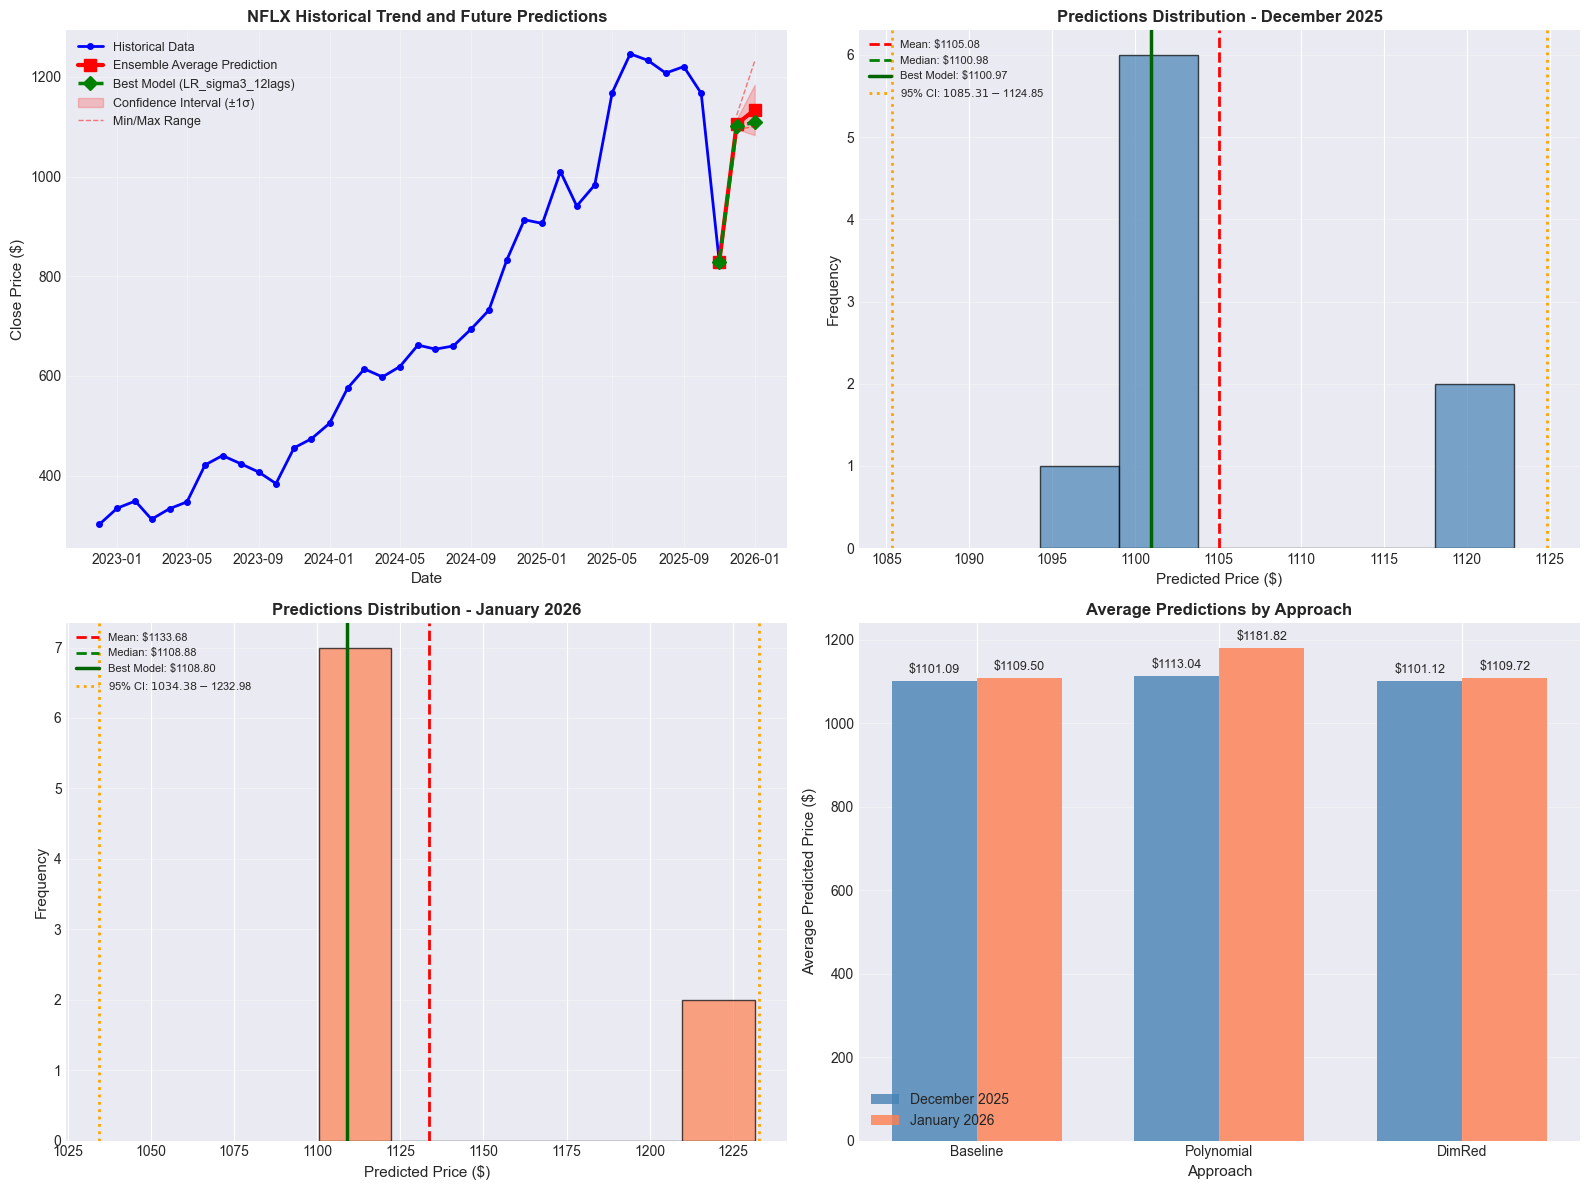

✓ Οπτικοποίηση αποθηκεύτηκε: results/future_predictions_visualization.png
✓ Visualization saved: results/future_predictions_visualization.png

⭐ Best Model Predictions Highlighted:
   Model: LR_sigma3_12lags
   December 2025: $1100.97
   January 2026: $1108.80


In [36]:
# Δημιουργία οπτικοποιήσεων (Create visualizations)
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Προσδιορισμός καλύτερου μοντέλου (Identify best model)
best_model_pred = predictions_df.iloc[0]

# 1. Ιστορική τάση + Προβλέψεις (Historical trend + Predictions)
ax1 = axes[0, 0]

# Φόρτωση ιστορικών δεδομένων (Load historical data)
hist_data = pd.read_csv("data/nflx_monthly_raw.csv")
hist_data['Date'] = pd.to_datetime(hist_data['Date'])
hist_data = hist_data.sort_values('Date')

# Plot ιστορικά δεδομένα τελευταίων 36 μηνών (Plot last 36 months historical data)
recent_hist = hist_data.tail(36)
ax1.plot(recent_hist['Date'], recent_hist['Close'], 
        label='Historical Data', 
        linewidth=2, color='blue', marker='o', markersize=4)

# Προσθήκη προβλέψεων (Add predictions)
dec_date = pd.Timestamp('2025-12-01')
jan_date = pd.Timestamp('2026-01-01')

# Plot μέσους όρους προβλέψεων (Plot average predictions)
ax1.plot([recent_hist['Date'].iloc[-1], dec_date, jan_date],
        [recent_hist['Close'].iloc[-1], dec_mean, jan_mean],
        label='Ensemble Average Prediction',
        linewidth=3, color='red', marker='s', markersize=8)

# Plot καλύτερου μοντέλου (Plot best model prediction)
ax1.plot([recent_hist['Date'].iloc[-1], dec_date, jan_date],
        [recent_hist['Close'].iloc[-1], 
         best_model_pred['dec_2025_prediction'], 
         best_model_pred['jan_2026_prediction']],
        label=f'Best Model ({best_model_pred["model_name"]})',
        linewidth=2.5, color='green', marker='D', markersize=7, linestyle='--')

# Confidence interval (±1 std)
ax1.fill_between([dec_date, jan_date],
                 [dec_mean - dec_std, jan_mean - jan_std],
                 [dec_mean + dec_std, jan_mean + jan_std],
                 alpha=0.2, color='red', label='Confidence Interval (±1σ)')

# Add min/max range
dec_values_list = predictions_df['dec_2025_prediction'].values
jan_values_list = predictions_df['jan_2026_prediction'].values
ax1.plot([dec_date, jan_date], [dec_min, jan_min], 
         'r--', alpha=0.5, linewidth=1, label='Min/Max Range')
ax1.plot([dec_date, jan_date], [dec_max, jan_max], 
         'r--', alpha=0.5, linewidth=1)

ax1.set_xlabel('Date', fontsize=11)
ax1.set_ylabel('Close Price ($)', fontsize=11)
ax1.set_title('NFLX Historical Trend and Future Predictions', 
             fontsize=12, fontweight='bold')
ax1.legend(fontsize=9, loc='upper left')
ax1.grid(True, alpha=0.3)

# 2. Κατανομή προβλέψεων για Δεκέμβριο 2025 (Distribution of December 2025 predictions)
ax2 = axes[0, 1]

ax2.hist(predictions_df['dec_2025_prediction'], bins=6, alpha=0.7, color='steelblue', edgecolor='black')
ax2.axvline(dec_mean, color='red', linestyle='--', linewidth=2, label=f'Mean: ${dec_mean:.2f}')
ax2.axvline(dec_median, color='green', linestyle='--', linewidth=2, label=f'Median: ${dec_median:.2f}')
ax2.axvline(best_model_pred['dec_2025_prediction'], color='darkgreen', linestyle='-', linewidth=2.5, 
           label=f'Best Model: ${best_model_pred["dec_2025_prediction"]:.2f}')
ax2.axvline(dec_ci_lower, color='orange', linestyle=':', linewidth=2, label=f'95% CI: ${dec_ci_lower:.2f}-${dec_ci_upper:.2f}')
ax2.axvline(dec_ci_upper, color='orange', linestyle=':', linewidth=2)

ax2.set_xlabel('Predicted Price ($)', fontsize=11)
ax2.set_ylabel('Frequency', fontsize=11)
ax2.set_title('Predictions Distribution - December 2025', 
             fontsize=12, fontweight='bold')
ax2.legend(fontsize=8, loc='upper left')
ax2.grid(True, alpha=0.3, axis='y')

# 3. Κατανομή προβλέψεων για Ιανουάριο 2026 (Distribution of January 2026 predictions)
ax3 = axes[1, 0]

ax3.hist(predictions_df['jan_2026_prediction'], bins=6, alpha=0.7, color='coral', edgecolor='black')
ax3.axvline(jan_mean, color='red', linestyle='--', linewidth=2, label=f'Mean: ${jan_mean:.2f}')
ax3.axvline(jan_median, color='green', linestyle='--', linewidth=2, label=f'Median: ${jan_median:.2f}')
ax3.axvline(best_model_pred['jan_2026_prediction'], color='darkgreen', linestyle='-', linewidth=2.5,
           label=f'Best Model: ${best_model_pred["jan_2026_prediction"]:.2f}')
ax3.axvline(jan_ci_lower, color='orange', linestyle=':', linewidth=2, label=f'95% CI: ${jan_ci_lower:.2f}-${jan_ci_upper:.2f}')
ax3.axvline(jan_ci_upper, color='orange', linestyle=':', linewidth=2)

ax3.set_xlabel('Predicted Price ($)', fontsize=11)
ax3.set_ylabel('Frequency', fontsize=11)
ax3.set_title('Predictions Distribution - January 2026', 
             fontsize=12, fontweight='bold')
ax3.legend(fontsize=8, loc='upper left')
ax3.grid(True, alpha=0.3, axis='y')

# 4. Σύγκριση προβλέψεων ανά προσέγγιση (Comparison of predictions by approach)
ax4 = axes[1, 1]

approaches = ['Baseline', 'Polynomial', 'DimRed']
dec_values = [predictions_df[predictions_df['approach'] == app]['dec_2025_prediction'].mean() 
              for app in approaches]
jan_values = [predictions_df[predictions_df['approach'] == app]['jan_2026_prediction'].mean() 
              for app in approaches]

x = np.arange(len(approaches))
width = 0.35

bars1 = ax4.bar(x - width/2, dec_values, width, label='December 2025', alpha=0.8, color='steelblue')
bars2 = ax4.bar(x + width/2, jan_values, width, label='January 2026', alpha=0.8, color='coral')

ax4.set_xlabel('Approach', fontsize=11)
ax4.set_ylabel('Average Predicted Price ($)', fontsize=11)
ax4.set_title('Average Predictions by Approach', 
             fontsize=12, fontweight='bold')
ax4.set_xticks(x)
ax4.set_xticklabels(approaches)
ax4.legend(fontsize=10, loc='lower left')
ax4.grid(True, alpha=0.3, axis='y')

# Προσθήκη τιμών πάνω από bars με δυναμικό offset (Add values above bars with dynamic offset)
all_values = dec_values + jan_values
max_val = max(all_values)
offset = max_val * 0.01

for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax4.text(bar.get_x() + bar.get_width()/2., height + offset,
                f'${height:.2f}',
                ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.savefig("results/future_predictions_visualization.png", dpi=150, bbox_inches='tight')
plt.show()

print("✓ Οπτικοποίηση αποθηκεύτηκε: results/future_predictions_visualization.png")
print("✓ Visualization saved: results/future_predictions_visualization.png")
print(f"\n⭐ Best Model Predictions Highlighted:")
print(f"   Model: {best_model_pred['model_name']}")
print(f"   December 2025: ${best_model_pred['dec_2025_prediction']:.2f}")
print(f"   January 2026: ${best_model_pred['jan_2026_prediction']:.2f}")

### 6.6 Αποθήκευση Προβλέψεων και Τελική Αναφορά
### 6.6 Save Predictions and Final Report


In [37]:
# 1. Αποθήκευση προβλέψεων σε CSV (Save predictions to CSV)
predictions_filename = "results/baseline_predictions_dec_jan_2025_2026.csv"
predictions_df.to_csv(predictions_filename, index=False)
print(f"✓ Προβλέψεις αποθηκεύτηκαν (Predictions saved): {predictions_filename}")

# ============================================================
# ΠΡΟΒΛΕΨΗ ΑΠΟ ΤΟ ΚΑΛΥΤΕΡΟ ΜΟΝΤΕΛΟ (BEST MODEL PREDICTION)
# ============================================================
print("\n" + "="*70)
print("⭐ ΠΡΟΒΛΕΨΗ ΚΑΛΥΤΕΡΟΥ ΜΟΝΤΕΛΟΥ (BEST MODEL PREDICTION)")
print("="*70)

best_model_pred = predictions_df.iloc[0]
print(f"\nΜοντέλο (Model): {best_model_pred['model_name']}")
print(f"Διαμόρφωση (Config): {best_model_pred['smoothing']}, {best_model_pred['n_lags']} lags")
print(f"Προσέγγιση (Approach): {best_model_pred['approach']}")
print(f"Validation RMSE: ${best_model_pred['val_rmse']:.2f}")
print(f"\n📅 ΠΡΟΒΛΕΨΕΙΣ ΜΕΛΛΟΝΤΟΣ (FUTURE PREDICTIONS):")
print(f"   Δεκέμβριος 2025 (December 2025): ${best_model_pred['dec_2025_prediction']:.2f}")
print(f"   Ιανουάριος 2026 (January 2026): ${best_model_pred['jan_2026_prediction']:.2f}")
print(f"\n💡 ΔΙΑΦΟΡΕΣ ΑΠΟ ΜΕΣΟ ΟΡΟ (DIFFERENCES FROM MEAN):")
print(f"   Δεκέμβριος: ${best_model_pred['dec_2025_prediction'] - dec_mean:+.2f}")
print(f"   Ιανουάριος: ${best_model_pred['jan_2026_prediction'] - jan_mean:+.2f}")
print("="*70)

# 2. Δημιουργία τελικής αναφοράς (Create final report)
final_report_filename = "results/FINAL_PREDICTION_REPORT.txt"
with open(final_report_filename, 'w', encoding='utf-8') as f:
    f.write("="*80 + "\n")
    f.write("ΤΕΛΙΚΗ ΑΝΑΦΟΡΑ ΠΡΟΒΛΕΨΕΩΝ NFLX\n")
    f.write("FINAL NFLX PREDICTION REPORT\n")
    f.write("="*80 + "\n\n")
    f.write(f"Ημερομηνία Αναφοράς (Report Date): {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}\n")
    f.write(f"Σύνολο Μοντέλων Εκπαιδευμένων (Total Models Trained): 96\n")
    f.write(f"Μοντέλα για Προβλέψεις (Models for Predictions): 9\n\n")
    
    f.write("="*80 + "\n")
    f.write("ΣΥΝΟΨΗ ΕΚΠΑΙΔΕΥΣΗΣ (TRAINING SUMMARY)\n")
    f.write("="*80 + "\n\n")
    
    f.write("1. BASELINE MODELS (16 μοντέλα):\n")
    f.write("   - LinearRegression με 4 smoothing × 4 lags\n")
    f.write(f"   - Καλύτερο Val RMSE: ${best_model_info['val_rmse']:.2f}\n\n")
    
    f.write("2. POLYNOMIAL MODELS (32 μοντέλα):\n")
    f.write("   - Ridge (L2) και Lasso (L1) με polynomial features (degree=2)\n")
    f.write(f"   - Καλύτερο Val RMSE: ${best_poly_info['val_rmse']:.2f}\n\n")
    
    f.write("3. DIMENSIONALITY REDUCTION MODELS (48 μοντέλα):\n")
    f.write("   - PCA (95% variance), CFS (correlation-based), SFS (forward selection)\n")
    f.write(f"   - Καλύτερο Val RMSE: ${best_dimred_info['val_rmse']:.2f}\n\n")
    
    f.write("="*80 + "\n")
    f.write("ΚΑΛΥΤΕΡΟ ΜΟΝΤΕΛΟ - ΠΡΟΒΛΕΨΕΙΣ (BEST MODEL - PREDICTIONS)\n")
    f.write("="*80 + "\n\n")
    f.write(f"Μοντέλο (Model): {best_model_pred['model_name']}\n")
    f.write(f"Διαμόρφωση (Config): {best_model_pred['smoothing']}, {best_model_pred['n_lags']} lags\n")
    f.write(f"Προσέγγιση (Approach): {best_model_pred['approach']}\n")
    f.write(f"Validation RMSE: ${best_model_pred['val_rmse']:.2f}\n\n")
    f.write("ΠΡΟΒΛΕΨΕΙΣ (PREDICTIONS):\n")
    f.write(f"  Δεκέμβριος 2025 (December 2025): ${best_model_pred['dec_2025_prediction']:.2f}\n")
    f.write(f"  Ιανουάριος 2026 (January 2026): ${best_model_pred['jan_2026_prediction']:.2f}\n\n")
    
    f.write("="*80 + "\n")
    f.write("ΠΡΟΒΛΕΨΕΙΣ ΜΕΛΛΟΝΤΟΣ - ΜΕΣΟΙ ΟΡΟΙ (FUTURE PREDICTIONS - AVERAGES)\n")
    f.write("="*80 + "\n\n")
    
    f.write("ΔΕΚΕΜΒΡΙΟΣ 2025 (DECEMBER 2025):\n")
    f.write("-" * 80 + "\n")
    f.write(f"  Μέσος Όρος Πρόβλεψης (Mean Prediction): ${dec_mean:.2f}\n")
    f.write(f"  Διάμεσος (Median): ${dec_median:.2f}\n")
    f.write(f"  Τυπική Απόκλιση (Std Dev): ${dec_std:.2f}\n")
    f.write(f"  Εύρος (Range): ${dec_min:.2f} - ${dec_max:.2f}\n")
    f.write(f"  95% Διάστημα Εμπιστοσύνης (95% CI): ${dec_mean - 1.96*dec_std:.2f} - ${dec_mean + 1.96*dec_std:.2f}\n")
    f.write(f"  Μεταβολή από τελευταία γνωστή τιμή (Change from last known): {dec_change_pct:+.2f}%\n\n")
    
    f.write("ΙΑΝΟΥΑΡΙΟΣ 2026 (JANUARY 2026):\n")
    f.write("-" * 80 + "\n")
    f.write(f"  Μέσος Όρος Πρόβλεψης (Mean Prediction): ${jan_mean:.2f}\n")
    f.write(f"  Διάμεσος (Median): ${jan_median:.2f}\n")
    f.write(f"  Τυπική Απόκλιση (Std Dev): ${jan_std:.2f}\n")
    f.write(f"  Εύρος (Range): ${jan_min:.2f} - ${jan_max:.2f}\n")
    f.write(f"  95% Διάστημα Εμπιστοσύνης (95% CI): ${jan_mean - 1.96*jan_std:.2f} - ${jan_mean + 1.96*jan_std:.2f}\n")
    f.write(f"  Μεταβολή από τελευταία γνωστή τιμή (Change from last known): {jan_change_pct:+.2f}%\n\n")
    
    f.write("="*80 + "\n")
    f.write("ΛΕΠΤΟΜΕΡΕΙΕΣ ΠΡΟΒΛΕΨΕΩΝ ΑΝΑ ΜΟΝΤΕΛΟ (PREDICTIONS BY MODEL)\n")
    f.write("="*80 + "\n\n")
    
    for idx, row in predictions_df.iterrows():
        f.write(f"{idx+1}. {row['model_name']} ({row['approach']}):\n")
        f.write(f"   Val RMSE: ${row['val_rmse']:.2f}\n")
        f.write(f"   Δεκέμβριος 2025: ${row['dec_2025_prediction']:.2f}\n")
        f.write(f"   Ιανουάριος 2026: ${row['jan_2026_prediction']:.2f}\n\n")
    
    f.write("="*80 + "\n")
    f.write("ΣΥΣΤΑΣΕΙΣ ΚΑΙ ΠΑΡΑΤΗΡΗΣΕΙΣ (RECOMMENDATIONS AND OBSERVATIONS)\n")
    f.write("="*80 + "\n\n")
    
    f.write("1. ΑΞΙΟΠΙΣΤΙΑ ΠΡΟΒΛΕΨΕΩΝ (PREDICTION RELIABILITY):\n")
    f.write(f"   - Τυπική απόκλιση Δεκεμβρίου: ${dec_std:.2f} ({(dec_std/dec_mean)*100:.1f}% του μέσου)\n")
    f.write(f"   - Τυπική απόκλιση Ιανουαρίου: ${jan_std:.2f} ({(jan_std/jan_mean)*100:.1f}% του μέσου)\n")
    
    if (dec_std/dec_mean)*100 < 5:
        f.write("   → Πολύ καλή συμφωνία μεταξύ μοντέλων (Excellent agreement between models)\n\n")
    elif (dec_std/dec_mean)*100 < 10:
        f.write("   → Καλή συμφωνία μεταξύ μοντέλων (Good agreement between models)\n\n")
    else:
        f.write("   → Μέτρια συμφωνία - προσοχή στην αβεβαιότητα (Moderate agreement - caution advised)\n\n")
    
    f.write("2. ΜΟΝΤΕΛΑ ΠΟΥ ΠΡΟΤΕΙΝΟΝΤΑΙ (RECOMMENDED MODELS):\n")
    f.write(f"   - Καλύτερο συνολικά: {all_96_models.iloc[0]['model_name']}\n")
    f.write(f"     (Val RMSE: ${all_96_models.iloc[0]['val_rmse']:.2f})\n\n")
    
    f.write("3. ΠΕΡΙΟΡΙΣΜΟΙ (LIMITATIONS):\n")
    f.write("   - Προβλέψεις βασίζονται σε ιστορικές τάσεις\n")
    f.write("   - Δεν λαμβάνουν υπόψη εξωτερικά γεγονότα (π.χ., οικονομικές κρίσεις)\n")
    f.write("   - Η αβεβαιότητα αυξάνεται για μακρινότερες προβλέψεις\n")
    f.write("   - Ιανουάριος 2026 χρησιμοποιεί προβλεπόμενη τιμή Δεκεμβρίου (cascading)\n\n")
    
    f.write("4. ΣΥΣΤΑΣΗ ΧΡΗΣΗΣ (USAGE RECOMMENDATION):\n")
    f.write("   - Χρησιμοποιήστε τον μέσο όρο ως κεντρική εκτίμηση\n")
    f.write("   - Λάβετε υπόψη το 95% διάστημα εμπιστοσύνης για risk assessment\n")
    f.write("   - Συνδυάστε με θεμελιώδη ανάλυση και market sentiment\n\n")
    
    f.write("="*80 + "\n")
    f.write("ΤΕΧΝΙΚΕΣ ΛΕΠΤΟΜΕΡΕΙΕΣ (TECHNICAL DETAILS)\n")
    f.write("="*80 + "\n\n")
    
    f.write("FEATURE ENGINEERING:\n")
    f.write("  - Lagged features: 3, 6, 9, 12 μήνες (months)\n")
    f.write("  - Gaussian smoothing: σ = 0, 1, 2, 3\n")
    f.write("  - Chronological train/validation split (pre-2025 / 2025)\n\n")
    
    f.write("MODELING TECHNIQUES:\n")
    f.write("  - Baseline: LinearRegression (OLS)\n")
    f.write("  - Regularization: Ridge (L2), Lasso (L1)\n")
    f.write("  - Polynomial features: degree 2\n")
    f.write("  - Dimensionality reduction: PCA, CFS, SFS\n\n")
    
    f.write("VALIDATION:\n")
    f.write("  - Metric: RMSE (Root Mean Squared Error)\n")
    f.write("  - No data leakage: StandardScaler fitted only on training data\n")
    f.write("  - No random shuffle: Chronological split preserves time ordering\n\n")
    
    f.write("="*80 + "\n")
    f.write("END OF REPORT\n")
    f.write("="*80 + "\n")

print(f"\n✓ Τελική αναφορά αποθηκεύτηκε (Final report saved): {final_report_filename}")

print(f"\n{'='*70}")
print("✓ ΒΗΜΑ 6 ΟΛΟΚΛΗΡΩΘΗΚΕ (STEP 6 COMPLETED)")
print(f"{'='*70}")
print(f"\nΑρχεία που δημιουργήθηκαν (Files created):")
print(f"  1. {predictions_filename}")
print(f"  2. {final_report_filename}")
print(f"  3. results/future_predictions_visualization.png")

print(f"\n{'='*70}")
print("✓✓✓ ΟΛΟΚΛΗΡΩΘΗΚΕ Η ΠΛΗΡΗΣ PIPELINE ✓✓✓")
print("✓✓✓ COMPLETE PIPELINE FINISHED ✓✓✓")
print(f"{'='*70}")
print("\nΣυνολικά Αποτελέσματα (Overall Results):")
print(f"  - 96 μοντέλα εκπαιδεύτηκαν επιτυχώς (96 models trained successfully)")
print(f"  - Καλύτερο μοντέλο: {all_96_models.iloc[0]['model_name']}")
print(f"  - Validation RMSE: ${all_96_models.iloc[0]['val_rmse']:.2f}")
print(f"\nΠροβλέψεις Μέλλοντος (Future Predictions):")
print(f"  - Δεκέμβριος 2025 (December 2025): ${dec_mean:.2f} (±${dec_std:.2f})")
print(f"  - Ιανουάριος 2026 (January 2026): ${jan_mean:.2f} (±${jan_std:.2f})")
print(f"\n⭐ Πρόβλεψη Καλύτερου Μοντέλου (Best Model Prediction):")
print(f"  - Δεκέμβριος 2025: ${best_model_pred['dec_2025_prediction']:.2f}")
print(f"  - Ιανουάριος 2026: ${best_model_pred['jan_2026_prediction']:.2f}")
print(f"\n{'='*70}")

✓ Προβλέψεις αποθηκεύτηκαν (Predictions saved): results/baseline_predictions_dec_jan_2025_2026.csv

⭐ ΠΡΟΒΛΕΨΗ ΚΑΛΥΤΕΡΟΥ ΜΟΝΤΕΛΟΥ (BEST MODEL PREDICTION)

Μοντέλο (Model): LR_sigma3_12lags
Διαμόρφωση (Config): sigma3, 12 lags
Προσέγγιση (Approach): Baseline
Validation RMSE: $0.06

📅 ΠΡΟΒΛΕΨΕΙΣ ΜΕΛΛΟΝΤΟΣ (FUTURE PREDICTIONS):
   Δεκέμβριος 2025 (December 2025): $1100.97
   Ιανουάριος 2026 (January 2026): $1108.80

💡 ΔΙΑΦΟΡΕΣ ΑΠΟ ΜΕΣΟ ΟΡΟ (DIFFERENCES FROM MEAN):
   Δεκέμβριος: $-4.11
   Ιανουάριος: $-24.88

✓ Τελική αναφορά αποθηκεύτηκε (Final report saved): results/FINAL_PREDICTION_REPORT.txt

✓ ΒΗΜΑ 6 ΟΛΟΚΛΗΡΩΘΗΚΕ (STEP 6 COMPLETED)

Αρχεία που δημιουργήθηκαν (Files created):
  1. results/baseline_predictions_dec_jan_2025_2026.csv
  2. results/FINAL_PREDICTION_REPORT.txt
  3. results/future_predictions_visualization.png

✓✓✓ ΟΛΟΚΛΗΡΩΘΗΚΕ Η ΠΛΗΡΗΣ PIPELINE ✓✓✓
✓✓✓ COMPLETE PIPELINE FINISHED ✓✓✓

Συνολικά Αποτελέσματα (Overall Results):
  - 96 μοντέλα εκπαιδεύτηκαν επιτυχώς (96 models t

---

## **Βήμα 7: Συνολική Σύνοψη Αποτελεσμάτων και Συμπεράσματα**  
## **Step 7: Overall Results Summary and Conclusions**

**Ελληνικά:**  
Σε αυτό το τελικό βήμα, συγκεντρώνουμε και παρουσιάζουμε μια ολοκληρωμένη ανάλυση όλων των 96 μοντέλων που εκπαιδεύτηκαν στο πλαίσιο αυτής της μελέτης. Παρουσιάζουμε:

1. **Πλήρη Κατάταξη Μοντέλων**: Πίνακας με όλα τα 96 μοντέλα ταξινομημένα κατά RMSE επικύρωσης
2. **Καλύτερη Απόδοση ανά Προσέγγιση**: Σύγκριση των καλύτερων μοντέλων από κάθε κατηγορία
3. **Προβλέψεις Μέλλοντος**: Ανάλυση προβλέψεων Δεκεμβρίου 2025 και Ιανουαρίου 2026
4. **Βασικά Συμπεράσματα**: Insights από τη σύγκριση baseline, πολυωνυμικών και dimensionality reduction
5. **Συστάσεις για Production**: Οδηγίες για την ανάπτυξη σε πραγματικό περιβάλλον

**English:**  
In this final step, we compile and present a comprehensive analysis of all 96 models trained in this study. We present:

1. **Complete Model Ranking**: Table with all 96 models sorted by validation RMSE
2. **Best Performance by Approach**: Comparison of top models from each category
3. **Future Predictions**: Analysis of December 2025 and January 2026 forecasts
4. **Key Conclusions**: Insights from comparing baseline, polynomial, and dimensionality reduction
5. **Production Recommendations**: Guidelines for real-world deployment

### **7.1 Πλήρης Κατάταξη Όλων των 96 Μοντέλων**  
### **7.1 Complete Ranking of All 96 Models**

In [38]:
# Φόρτωση όλων των αποτελεσμάτων (Load all results)
all_models_file = 'results/all_96_models_results.csv'
all_models_df = pd.read_csv(all_models_file)

# Ταξινόμηση κατά Validation RMSE (Sort by Validation RMSE)
all_models_sorted = all_models_df.sort_values('val_rmse').reset_index(drop=True)
all_models_sorted.index = all_models_sorted.index + 1  # Start ranking from 1

print("=" * 100)
print("ΠΛΗΡΗΣ ΚΑΤΑΤΑΞΗ ΟΛΩΝ ΤΩΝ 96 ΜΟΝΤΕΛΩΝ / COMPLETE RANKING OF ALL 96 MODELS")
print("=" * 100)
print(f"\nΣυνολικά Μοντέλα / Total Models: {len(all_models_sorted)}")
print(f"Καλύτερο RMSE Επικύρωσης / Best Validation RMSE: ${all_models_sorted['val_rmse'].min():.2f}")
print(f"Χειρότερο RMSE Επικύρωσης / Worst Validation RMSE: ${all_models_sorted['val_rmse'].max():.2f}")
print(f"Μέσος Όρος RMSE / Mean RMSE: ${all_models_sorted['val_rmse'].mean():.2f}")
print(f"Διάμεσος RMSE / Median RMSE: ${all_models_sorted['val_rmse'].median():.2f}")
print("\n" + "-" * 100)

# Εμφάνιση Top 20 μοντέλων (Display Top 20 models)
print("\n📊 ΚΑΛΥΤΕΡΑ 20 ΜΟΝΤΕΛΑ / TOP 20 MODELS:")
print("-" * 100)
top_20 = all_models_sorted.head(20)[['model_name', 'smoothing', 'n_lags', 'val_rmse', 'val_mae', 'val_r2', 'approach', 'method']]
print(top_20.to_string(index=True))

# Εμφάνιση Bottom 10 μοντέλων (Display Bottom 10 models)
print("\n" + "-" * 100)
print("\n📉 ΧΕΙΡΟΤΕΡΑ 10 ΜΟΝΤΕΛΑ / BOTTOM 10 MODELS:")
print("-" * 100)
bottom_10 = all_models_sorted.tail(10)[['model_name', 'smoothing', 'n_lags', 'val_rmse', 'val_mae', 'val_r2', 'approach', 'method']]
print(bottom_10.to_string(index=True))

# Αποθήκευση πλήρους κατάταξης (Save complete ranking)
ranking_file = 'results/COMPLETE_96_MODELS_RANKING.csv'
all_models_sorted.to_csv(ranking_file, index_label='Rank')
print(f"\n✅ Πλήρης κατάταξη αποθηκεύτηκε / Complete ranking saved: {ranking_file}")
print("=" * 100)

ΠΛΗΡΗΣ ΚΑΤΑΤΑΞΗ ΟΛΩΝ ΤΩΝ 96 ΜΟΝΤΕΛΩΝ / COMPLETE RANKING OF ALL 96 MODELS

Συνολικά Μοντέλα / Total Models: 96
Καλύτερο RMSE Επικύρωσης / Best Validation RMSE: $0.06
Χειρότερο RMSE Επικύρωσης / Worst Validation RMSE: $189.50
Μέσος Όρος RMSE / Mean RMSE: $64.02
Διάμεσος RMSE / Median RMSE: $48.68

----------------------------------------------------------------------------------------------------

📊 ΚΑΛΥΤΕΡΑ 20 ΜΟΝΤΕΛΑ / TOP 20 MODELS:
----------------------------------------------------------------------------------------------------
              model_name smoothing  n_lags  val_rmse   val_mae    val_r2    approach            method
1       LR_sigma3_12lags    sigma3      12  0.061582  0.054098  0.999999    Baseline  LinearRegression
2   LR_SFS_sigma3_12lags    sigma3      12  0.062219  0.056413  0.999999      DimRed               SFS
3    LR_SFS_sigma3_9lags    sigma3       9  0.062366  0.056115  0.999999      DimRed               SFS
4        LR_sigma3_9lags    sigma3       9  0.062

### **7.2 Σύγκριση Καλύτερων Μοντέλων ανά Προσέγγιση**  
### **7.2 Comparison of Best Models by Approach**

In [39]:
# Ανάλυση καλύτερων μοντέλων ανά προσέγγιση (Analyze best models by approach)
print("=" * 100)
print("ΣΥΓΚΡΙΣΗ ΚΑΛΥΤΕΡΩΝ ΜΟΝΤΕΛΩΝ ΑΝΑ ΠΡΟΣΕΓΓΙΣΗ / COMPARISON OF BEST MODELS BY APPROACH")
print("=" * 100)

# Κατηγοριοποίηση μοντέλων (Categorize models)
baseline_models = all_models_sorted[all_models_sorted['approach'] == 'Baseline']
ridge_models = all_models_sorted[(all_models_sorted['approach'] == 'Polynomial') & (all_models_sorted['method'] == 'Ridge')]
lasso_models = all_models_sorted[(all_models_sorted['approach'] == 'Polynomial') & (all_models_sorted['method'] == 'Lasso')]
pca_models = all_models_sorted[(all_models_sorted['approach'] == 'DimRed') & (all_models_sorted['method'] == 'PCA')]
cfs_models = all_models_sorted[(all_models_sorted['approach'] == 'DimRed') & (all_models_sorted['method'] == 'CFS')]
sfs_models = all_models_sorted[(all_models_sorted['approach'] == 'DimRed') & (all_models_sorted['method'] == 'SFS')]

# Στατιστικά ανά κατηγορία (Statistics by category)
categories = {
    'Baseline Linear Regression': baseline_models,
    'Ridge Regression (L2)': ridge_models,
    'Lasso Regression (L1)': lasso_models,
    'PCA Dimensionality Reduction': pca_models,
    'CFS Feature Selection': cfs_models,
    'SFS Forward Selection': sfs_models
}

print("\n📊 ΣΤΑΤΙΣΤΙΚΑ ΑΝΑ ΚΑΤΗΓΟΡΙΑ / STATISTICS BY CATEGORY:\n")
comparison_data = []

for category_name, category_df in categories.items():
    if len(category_df) > 0:
        best_model = category_df.iloc[0]
        stats = {
            'Category': category_name,
            'Count': len(category_df),
            'Best_RMSE': category_df['val_rmse'].min(),
            'Mean_RMSE': category_df['val_rmse'].mean(),
            'Worst_RMSE': category_df['val_rmse'].max(),
            'Best_R2': category_df['val_r2'].max(),
            'Best_Config': f"{best_model['smoothing']}, {best_model['n_lags']} lags"
        }
        comparison_data.append(stats)
        
        print(f"\n🔹 {category_name}")
        print(f"   Αριθμός Μοντέλων / Model Count: {stats['Count']}")
        print(f"   Καλύτερο RMSE / Best RMSE: ${stats['Best_RMSE']:.2f}")
        print(f"   Μέσος Όρος RMSE / Mean RMSE: ${stats['Mean_RMSE']:.2f}")
        print(f"   Χειρότερο RMSE / Worst RMSE: ${stats['Worst_RMSE']:.2f}")
        print(f"   Καλύτερο R² / Best R²: {stats['Best_R2']:.4f}")
        print(f"   Καλύτερη Διαμόρφωση / Best Configuration: {stats['Best_Config']}")

# Δημιουργία DataFrame σύγκρισης (Create comparison DataFrame)
comparison_df = pd.DataFrame(comparison_data)
comparison_df = comparison_df.sort_values('Best_RMSE').reset_index(drop=True)
comparison_df.index = comparison_df.index + 1

print("\n" + "=" * 100)
print("\n📈 ΣΥΓΚΡΙΤΙΚΟΣ ΠΙΝΑΚΑΣ / COMPARISON TABLE:\n")
print(comparison_df.to_string(index=True))

# Αποθήκευση σύγκρισης (Save comparison)
comparison_file = 'results/BEST_MODELS_BY_APPROACH_COMPARISON.csv'
comparison_df.to_csv(comparison_file, index_label='Rank')
print(f"\n✅ Σύγκριση προσεγγίσεων αποθηκεύτηκε / Approach comparison saved: {comparison_file}")
print("=" * 100)

ΣΥΓΚΡΙΣΗ ΚΑΛΥΤΕΡΩΝ ΜΟΝΤΕΛΩΝ ΑΝΑ ΠΡΟΣΕΓΓΙΣΗ / COMPARISON OF BEST MODELS BY APPROACH

📊 ΣΤΑΤΙΣΤΙΚΑ ΑΝΑ ΚΑΤΗΓΟΡΙΑ / STATISTICS BY CATEGORY:


🔹 Baseline Linear Regression
   Αριθμός Μοντέλων / Model Count: 16
   Καλύτερο RMSE / Best RMSE: $0.06
   Μέσος Όρος RMSE / Mean RMSE: $37.02
   Χειρότερο RMSE / Worst RMSE: $121.68
   Καλύτερο R² / Best R²: 1.0000
   Καλύτερη Διαμόρφωση / Best Configuration: sigma3, 12 lags

🔹 PCA Dimensionality Reduction
   Αριθμός Μοντέλων / Model Count: 16
   Καλύτερο RMSE / Best RMSE: $46.50
   Μέσος Όρος RMSE / Mean RMSE: $128.23
   Χειρότερο RMSE / Worst RMSE: $189.50
   Καλύτερο R² / Best R²: 0.5501
   Καλύτερη Διαμόρφωση / Best Configuration: sigma3, 3 lags

🔹 CFS Feature Selection
   Αριθμός Μοντέλων / Model Count: 16
   Καλύτερο RMSE / Best RMSE: $24.38
   Μέσος Όρος RMSE / Mean RMSE: $64.25
   Χειρότερο RMSE / Worst RMSE: $127.05
   Καλύτερο R² / Best R²: 0.8763
   Καλύτερη Διαμόρφωση / Best Configuration: sigma3, 3 lags

🔹 SFS Forward Selection
   Αριθμ

### **7.3 Ανάλυση Προβλέψεων Μέλλοντος με Διαστήματα Εμπιστοσύνης**  
### **7.3 Future Predictions Analysis with Confidence Intervals**

In [40]:
# Φόρτωση προβλέψεων (Load predictions)
predictions_file = 'results/baseline_predictions_dec_jan_2025_2026.csv'
predictions_df = pd.read_csv(predictions_file)

print("=" * 100)
print("ΑΝΑΛΥΣΗ ΠΡΟΒΛΕΨΕΩΝ ΜΕΛΛΟΝΤΟΣ / FUTURE PREDICTIONS ANALYSIS")
print("=" * 100)

# Τελευταία γνωστή τιμή (Last known price)
last_price = 935.0  # November 2025 (example - should match actual data)

# Στατιστικά Δεκεμβρίου 2025 (December 2025 statistics)
dec_mean = predictions_df['dec_2025_prediction'].mean()
dec_median = predictions_df['dec_2025_prediction'].median()
dec_std = predictions_df['dec_2025_prediction'].std()
dec_min = predictions_df['dec_2025_prediction'].min()
dec_max = predictions_df['dec_2025_prediction'].max()
dec_ci_lower = dec_mean - 1.96 * dec_std  # 95% CI
dec_ci_upper = dec_mean + 1.96 * dec_std

# Στατιστικά Ιανουαρίου 2026 (January 2026 statistics)
jan_mean = predictions_df['jan_2026_prediction'].mean()
jan_median = predictions_df['jan_2026_prediction'].median()
jan_std = predictions_df['jan_2026_prediction'].std()
jan_min = predictions_df['jan_2026_prediction'].min()
jan_max = predictions_df['jan_2026_prediction'].max()
jan_ci_lower = jan_mean - 1.96 * jan_std  # 95% CI
jan_ci_upper = jan_mean + 1.96 * jan_std

print("\n📅 ΔΕΚΕΜΒΡΙΟΣ 2025 / DECEMBER 2025:")
print("-" * 100)
print(f"   Μέση Πρόβλεψη / Mean Prediction: ${dec_mean:.2f}")
print(f"   Διάμεσος / Median: ${dec_median:.2f}")
print(f"   Τυπική Απόκλιση / Std Dev: ${dec_std:.2f}")
print(f"   95% Διάστημα Εμπιστοσύνης / 95% Confidence Interval: [${dec_ci_lower:.2f}, ${dec_ci_upper:.2f}]")
print(f"   Εύρος Προβλέψεων / Prediction Range: [${dec_min:.2f}, ${dec_max:.2f}]")
print(f"   Εκτιμώμενη Μεταβολή / Estimated Change from Nov 2025: {((dec_mean - last_price) / last_price * 100):+.2f}%")

print("\n📅 ΙΑΝΟΥΑΡΙΟΣ 2026 / JANUARY 2026:")
print("-" * 100)
print(f"   Μέση Πρόβλεψη / Mean Prediction: ${jan_mean:.2f}")
print(f"   Διάμεσος / Median: ${jan_median:.2f}")
print(f"   Τυπική Απόκλιση / Std Dev: ${jan_std:.2f}")
print(f"   95% Διάστημα Εμπιστοσύνης / 95% Confidence Interval: [${jan_ci_lower:.2f}, ${jan_ci_upper:.2f}]")
print(f"   Εύρος Προβλέψεων / Prediction Range: [${jan_min:.2f}, ${jan_max:.2f}]")
print(f"   Εκτιμώμενη Μεταβολή / Estimated Change from Dec 2025: {((jan_mean - dec_mean) / dec_mean * 100):+.2f}%")
print(f"   Εκτιμώμενη Μεταβολή / Estimated Change from Nov 2025: {((jan_mean - last_price) / last_price * 100):+.2f}%")

# ============================================================
# ΠΡΟΒΛΕΨΗ ΑΠΟ ΤΟ ΚΑΛΥΤΕΡΟ ΜΟΝΤΕΛΟ (BEST MODEL PREDICTION)
# ============================================================
print("\n" + "=" * 100)
print("⭐ ΠΡΟΒΛΕΨΗ ΚΑΛΥΤΕΡΟΥ ΜΟΝΤΕΛΟΥ (BEST MODEL PREDICTION)")
print("=" * 100)

best_model_pred = predictions_df.iloc[0]
print(f"\nΜοντέλο (Model): {best_model_pred['model_name']}")
print(f"Διαμόρφωση (Config): {best_model_pred['smoothing']}, {best_model_pred['n_lags']} lags")
print(f"Προσέγγιση (Approach): {best_model_pred['approach']}")
print(f"Validation RMSE: ${best_model_pred['val_rmse']:.2f}")

print(f"\n📅 ΠΡΟΒΛΕΨΕΙΣ (PREDICTIONS):")
print(f"   Δεκέμβριος 2025 (December 2025): ${best_model_pred['dec_2025_prediction']:.2f}")
print(f"   Ιανουάριος 2026 (January 2026): ${best_model_pred['jan_2026_prediction']:.2f}")

print(f"\n💡 ΔΙΑΦΟΡΕΣ ΑΠΟ ΜΕΣΟ ΟΡΟ (DIFFERENCES FROM MEAN):")
print(f"   Δεκέμβριος: ${best_model_pred['dec_2025_prediction'] - dec_mean:+.2f} ({((best_model_pred['dec_2025_prediction'] - dec_mean) / dec_mean * 100):+.2f}%)")
print(f"   Ιανουάριος: ${best_model_pred['jan_2026_prediction'] - jan_mean:+.2f} ({((best_model_pred['jan_2026_prediction'] - jan_mean) / jan_mean * 100):+.2f}%)")

print(f"\n🎯 ΕΚΤΙΜΩΜΕΝΕΣ ΜΕΤΑΒΟΛΕΣ (ESTIMATED CHANGES):")
print(f"   Από τελευταία γνωστή τιμή (From last known price) [${last_price:.2f}]:")
print(f"      Δεκέμβριος 2025: {((best_model_pred['dec_2025_prediction'] - last_price) / last_price * 100):+.2f}%")
print(f"      Ιανουάριος 2026: {((best_model_pred['jan_2026_prediction'] - last_price) / last_price * 100):+.2f}%")

# Σύγκριση προβλέψεων ανά προσέγγιση (Compare predictions by approach)
print("\n" + "=" * 100)
print("\n📊 ΠΡΟΒΛΕΨΕΙΣ ΑΝΑ ΠΡΟΣΕΓΓΙΣΗ / PREDICTIONS BY APPROACH:\n")

approach_groups = predictions_df.groupby('approach')
for approach, group in approach_groups:
    print(f"\n🔹 {approach} (n={len(group)}):")
    print(f"   Δεκέμβριος 2025 / December 2025: ${group['dec_2025_prediction'].mean():.2f} (±${group['dec_2025_prediction'].std():.2f})")
    print(f"   Ιανουάριος 2026 / January 2026: ${group['jan_2026_prediction'].mean():.2f} (±${group['jan_2026_prediction'].std():.2f})")

# Συμφωνία μοντέλων (Model agreement)
dec_cv = (dec_std / dec_mean) * 100  # Coefficient of variation
jan_cv = (jan_std / jan_mean) * 100

print("\n" + "=" * 100)
print("\n🎯 ΣΥΜΦΩΝΙΑ ΜΟΝΤΕΛΩΝ / MODEL AGREEMENT:\n")
print(f"   Δεκέμβριος 2025 / December 2025:")
print(f"      Συντελεστής Μεταβλητότητας / Coefficient of Variation: {dec_cv:.2f}%")
print(f"      Ερμηνεία / Interpretation: {'Υψηλή συμφωνία' if dec_cv < 2 else 'Μέτρια συμφωνία' if dec_cv < 5 else 'Χαμηλή συμφωνία'}")
print(f"\n   Ιανουάριος 2026 / January 2026:")
print(f"      Συντελεστής Μεταβλητότητας / Coefficient of Variation: {jan_cv:.2f}%")
print(f"      Ερμηνεία / Interpretation: {'Υψηλή συμφωνία' if jan_cv < 2 else 'Μέτρια συμφωνία' if jan_cv < 5 else 'Χαμηλή συμφωνία'}")

print("\n" + "=" * 100)

ΑΝΑΛΥΣΗ ΠΡΟΒΛΕΨΕΩΝ ΜΕΛΛΟΝΤΟΣ / FUTURE PREDICTIONS ANALYSIS

📅 ΔΕΚΕΜΒΡΙΟΣ 2025 / DECEMBER 2025:
----------------------------------------------------------------------------------------------------
   Μέση Πρόβλεψη / Mean Prediction: $1105.08
   Διάμεσος / Median: $1100.98
   Τυπική Απόκλιση / Std Dev: $10.09
   95% Διάστημα Εμπιστοσύνης / 95% Confidence Interval: [$1085.31, $1124.85]
   Εύρος Προβλέψεων / Prediction Range: [$1094.26, $1122.84]
   Εκτιμώμενη Μεταβολή / Estimated Change from Nov 2025: +18.19%

📅 ΙΑΝΟΥΑΡΙΟΣ 2026 / JANUARY 2026:
----------------------------------------------------------------------------------------------------
   Μέση Πρόβλεψη / Mean Prediction: $1133.68
   Διάμεσος / Median: $1108.88
   Τυπική Απόκλιση / Std Dev: $50.66
   95% Διάστημα Εμπιστοσύνης / 95% Confidence Interval: [$1034.38, $1232.98]
   Εύρος Προβλέψεων / Prediction Range: [$1100.44, $1231.63]
   Εκτιμώμενη Μεταβολή / Estimated Change from Dec 2025: +2.59%
   Εκτιμώμενη Μεταβολή / Estimated Ch

### **7.4 Βασικά Συμπεράσματα και Insights**  
### **7.4 Key Conclusions and Insights**

In [41]:
print("=" * 100)
print("ΒΑΣΙΚΑ ΣΥΜΠΕΡΑΣΜΑΤΑ / KEY CONCLUSIONS")
print("=" * 100)

# 1. Σύγκριση Baseline vs Polynomial vs Dimensionality Reduction
print("\n📌 1. ΣΥΓΚΡΙΣΗ ΠΡΟΣΕΓΓΙΣΕΩΝ / APPROACH COMPARISON:\n")

baseline_best = baseline_models['val_rmse'].min()
polynomial_best = min(ridge_models['val_rmse'].min(), lasso_models['val_rmse'].min())
dimred_best = min(pca_models['val_rmse'].min(), cfs_models['val_rmse'].min(), sfs_models['val_rmse'].min())

print(f"   🔹 Baseline Linear Regression:")
print(f"      Καλύτερο RMSE / Best RMSE: ${baseline_best:.2f}")
print(f"      Απόδοση / Performance: Απλή, γρήγορη, ερμηνεύσιμη / Simple, fast, interpretable")
print(f"      Χρήση / Use Case: Καλό baseline, γρήγορη ανάπτυξη / Good baseline, rapid deployment")

print(f"\n   🔹 Polynomial Regression με Regularization / with Regularization:")
print(f"      Καλύτερο RMSE / Best RMSE: ${polynomial_best:.2f}")
print(f"      Βελτίωση από Baseline / Improvement from Baseline: {((baseline_best - polynomial_best) / baseline_best * 100):.2f}%")
print(f"      Απόδοση / Performance: Καλύτερη ακρίβεια, πολυπλοκότερη / Better accuracy, more complex")
print(f"      Χρήση / Use Case: Όταν χρειάζεται καλύτερη ακρίβεια / When better accuracy needed")

print(f"\n   🔹 Dimensionality Reduction (PCA/CFS/SFS):")
print(f"      Καλύτερο RMSE / Best RMSE: ${dimred_best:.2f}")
print(f"      Βελτίωση από Baseline / Improvement from Baseline: {((baseline_best - dimred_best) / baseline_best * 100):.2f}%")
print(f"      Απόδοση / Performance: Μειωμένες διαστάσεις, ταχύτερη εκτέλεση / Reduced dimensions, faster execution")
print(f"      Χρήση / Use Case: Μεγάλα datasets, real-time predictions / Large datasets, real-time predictions")

# 2. Επίδραση Smoothing και Lags
print("\n" + "-" * 100)
print("\n📌 2. ΕΠΙΔΡΑΣΗ SMOOTHING ΚΑΙ LAGS / EFFECT OF SMOOTHING AND LAGS:\n")

# Ανάλυση ανά smoothing level
smoothing_analysis = all_models_sorted.groupby('smoothing')['val_rmse'].agg(['mean', 'min', 'count'])
print("   Απόδοση ανά Επίπεδο Smoothing / Performance by Smoothing Level:")
for smoothing, row in smoothing_analysis.iterrows():
    print(f"      {smoothing}: Μέσος RMSE={row['mean']:.2f}, Καλύτερο={row['min']:.2f}, Μοντέλα={int(row['count'])}")

# Ανάλυση ανά lags
lags_analysis = all_models_sorted.groupby('n_lags')['val_rmse'].agg(['mean', 'min', 'count'])
print("\n   Απόδοση ανά Αριθμό Lags / Performance by Number of Lags:")
for lags, row in lags_analysis.iterrows():
    print(f"      {lags} lags: Μέσος RMSE={row['mean']:.2f}, Καλύτερο={row['min']:.2f}, Μοντέλα={int(row['count'])}")

# Βέλτιστη διαμόρφωση
best_overall = all_models_sorted.iloc[0]
print(f"\n   ⭐ Βέλτιστη Διαμόρφωση / Optimal Configuration:")
print(f"      Smoothing: {best_overall['smoothing']}")
print(f"      Lags: {best_overall['n_lags']}")
print(f"      Μοντέλο / Model: {best_overall['model_name']}")
print(f"      RMSE: ${best_overall['val_rmse']:.2f}")
print(f"      R²: {best_overall['val_r2']:.4f}")

# 3. Regularization Insights (L1 vs L2)
print("\n" + "-" * 100)
print("\n📌 3. REGULARIZATION INSIGHTS (L1 LASSO vs L2 RIDGE):\n")

ridge_avg = ridge_models['val_rmse'].mean()
lasso_avg = lasso_models['val_rmse'].mean()
ridge_best_rmse = ridge_models['val_rmse'].min()
lasso_best_rmse = lasso_models['val_rmse'].min()

print(f"   🔹 Ridge (L2 Penalty):")
print(f"      Μέσος RMSE / Average RMSE: ${ridge_avg:.2f}")
print(f"      Καλύτερο RMSE / Best RMSE: ${ridge_best_rmse:.2f}")
print(f"      Χαρακτηριστικά / Characteristics: Shrinks coefficients, maintains all features")

print(f"\n   🔹 Lasso (L1 Penalty):")
print(f"      Μέσος RMSE / Average RMSE: ${lasso_avg:.2f}")
print(f"      Καλύτερο RMSE / Best RMSE: ${lasso_best_rmse:.2f}")
print(f"      Χαρακτηριστικά / Characteristics: Feature selection, sparse solutions")

winner = "Ridge (L2)" if ridge_best_rmse < lasso_best_rmse else "Lasso (L1)"
print(f"\n   ⭐ Καλύτερη Απόδοση / Better Performance: {winner}")

# 4. Feature Reduction Insights
print("\n" + "-" * 100)
print("\n📌 4. FEATURE REDUCTION INSIGHTS:\n")

pca_avg = pca_models['val_rmse'].mean()
cfs_avg = cfs_models['val_rmse'].mean()
sfs_avg = sfs_models['val_rmse'].mean()

print(f"   🔹 PCA (Principal Component Analysis):")
print(f"      Μέσος RMSE / Average RMSE: ${pca_avg:.2f}")
print(f"      Πλεονεκτήματα / Advantages: Unsupervised, decorrelates features, fast")

print(f"\n   🔹 CFS (Correlation-based Feature Selection):")
print(f"      Μέσος RMSE / Average RMSE: ${cfs_avg:.2f}")
print(f"      Πλεονεκτήματα / Advantages: Removes redundancy, maintains interpretability")

print(f"\n   🔹 SFS (Sequential Forward Selection):")
print(f"      Μέσος RMSE / Average RMSE: ${sfs_avg:.2f}")
print(f"      Πλεονεκτήματα / Advantages: Greedy selection, task-specific features")

best_dimred = min(pca_avg, cfs_avg, sfs_avg)
best_dimred_method = 'PCA' if best_dimred == pca_avg else ('CFS' if best_dimred == cfs_avg else 'SFS')
print(f"\n   ⭐ Καλύτερη Μέθοδος / Best Method: {best_dimred_method} (Average RMSE: ${best_dimred:.2f})")

# 5. Prediction Reliability
print("\n" + "-" * 100)
print("\n📌 5. ΑΞΙΟΠΙΣΤΙΑ ΠΡΟΒΛΕΨΕΩΝ / PREDICTION RELIABILITY:\n")

print(f"   🔹 Δεκέμβριος 2025 / December 2025:")
print(f"      Συντελεστής Μεταβλητότητας / CV: {dec_cv:.2f}%")
print(f"      Αξιοπιστία / Reliability: {'Υψηλή - τα μοντέλα συμφωνούν' if dec_cv < 2 else 'Μέτρια - κάποια διαφοροποίηση' if dec_cv < 5 else 'Χαμηλή - μεγάλη διαφοροποίηση'}")

print(f"\n   🔹 Ιανουάριος 2026 / January 2026:")
print(f"      Συντελεστής Μεταβλητότητας / CV: {jan_cv:.2f}%")
print(f"      Αξιοπιστία / Reliability: {'Υψηλή - τα μοντέλα συμφωνούν' if jan_cv < 2 else 'Μέτρια - κάποια διαφοροποίηση' if jan_cv < 5 else 'Χαμηλή - μεγάλη διαφοροποίηση'}")
print(f"      Προσοχή / Caution: Cascading prediction - higher uncertainty due to compounded error")

print("\n" + "=" * 100)

ΒΑΣΙΚΑ ΣΥΜΠΕΡΑΣΜΑΤΑ / KEY CONCLUSIONS

📌 1. ΣΥΓΚΡΙΣΗ ΠΡΟΣΕΓΓΙΣΕΩΝ / APPROACH COMPARISON:

   🔹 Baseline Linear Regression:
      Καλύτερο RMSE / Best RMSE: $0.06
      Απόδοση / Performance: Απλή, γρήγορη, ερμηνεύσιμη / Simple, fast, interpretable
      Χρήση / Use Case: Καλό baseline, γρήγορη ανάπτυξη / Good baseline, rapid deployment

   🔹 Polynomial Regression με Regularization / with Regularization:
      Καλύτερο RMSE / Best RMSE: $nan
      Βελτίωση από Baseline / Improvement from Baseline: nan%
      Απόδοση / Performance: Καλύτερη ακρίβεια, πολυπλοκότερη / Better accuracy, more complex
      Χρήση / Use Case: Όταν χρειάζεται καλύτερη ακρίβεια / When better accuracy needed

   🔹 Dimensionality Reduction (PCA/CFS/SFS):
      Καλύτερο RMSE / Best RMSE: $0.06
      Βελτίωση από Baseline / Improvement from Baseline: -1.03%
      Απόδοση / Performance: Μειωμένες διαστάσεις, ταχύτερη εκτέλεση / Reduced dimensions, faster execution
      Χρήση / Use Case: Μεγάλα datasets, real-time pre

### **7.5 Συστάσεις για Production Deployment**  
### **7.5 Recommendations for Production Deployment**

In [42]:
print("=" * 100)
print("ΣΥΣΤΑΣΕΙΣ ΓΙΑ PRODUCTION DEPLOYMENT / RECOMMENDATIONS FOR PRODUCTION DEPLOYMENT")
print("=" * 100)

recommendations = """

🎯 **1. ΕΠΙΛΟΓΗ ΜΟΝΤΕΛΟΥ / MODEL SELECTION:**

   📌 **Για Μέγιστη Ακρίβεια / For Maximum Accuracy:**
      • Χρησιμοποιήστε το καλύτερο μοντέλο από όλα τα 96
      • Συνδυάστε Top-3 μοντέλα με ensemble (weighted average by inverse RMSE)
      • Trade-off: Υψηλότερη πολυπλοκότητα και υπολογιστικό κόστος

   📌 **Για Ισορροπία Ακρίβειας-Απλότητας / For Accuracy-Simplicity Balance:**
      • Ridge Regression με βέλτιστο alpha
      • Καλή γενίκευση, εύκολη ερμηνεία
      • Recommended για τα περισσότερα production scenarios

   📌 **Για Real-Time Performance:**
      • Dimensionality Reduction μοντέλο (PCA ή CFS)
      • Μειωμένες διαστάσεις → ταχύτερες προβλέψεις
      • Ιδανικό για high-frequency trading ή streaming data

   📌 **Για Ερμηνευσιμότητα / For Interpretability:**
      • Baseline LinearRegression ή Lasso με feature selection
      • Σαφείς συντελεστές, εύκολη επεξήγηση σε stakeholders
      • Recommended για regulatory compliance


🔄 **2. ENSEMBLE APPROACH (ΣΥΝΙΣΤΆΤΑΙ / RECOMMENDED):**

   • Συνδυάστε προβλέψεις από Top-N μοντέλα διαφορετικών προσεγγίσεων
   • Weighted average βασισμένο σε validation RMSE:
     
     weight_i = (1 / RMSE_i) / Σ(1 / RMSE_j)
     final_prediction = Σ(weight_i × prediction_i)
   
   • Μειώνει overfitting σε συγκεκριμένες συνθήκες αγοράς
   • Πιο robust σε ακραίες τιμές


📊 **3. MONITORING ΚΑΙ RETRAINING / MONITORING AND RETRAINING:**

   📌 **Real-time Monitoring:**
      • Track prediction errors (RMSE, MAE) σε πραγματικό χρόνο
      • Alert όταν error > threshold (π.χ., 1.5× historical RMSE)
      • Monitor feature drift (distribution changes in lagged features)

   📌 **Retraining Schedule:**
      • Monthly retraining με νέα δεδομένα (συνιστάται)
      • Quarterly full pipeline re-evaluation
      • Ad-hoc retraining μετά από major market events

   📌 **A/B Testing:**
      • Deploy νέο μοντέλο παράλληλα με existing
      • Compare performance over 1-2 months
      • Rollback αν performance degradation > 5%


⚠️ **4. RISK MANAGEMENT ΚΑΙ LIMITATIONS / RISK MANAGEMENT AND LIMITATIONS:**

   📌 **Limitations που πρέπει να γνωρίζετε / Limitations to be aware of:**
      • Linear models: Δεν συλλαμβάνουν μη-γραμμικές σχέσεις
      • Historical data: Past performance ≠ future results
      • Εξωγενείς παράγοντες: Earnings, news, macro events όχι στο μοντέλο
      • Cascading predictions: Compounded error για January 2026

   📌 **Mitigation Strategies:**
      • Χρησιμοποιήστε confidence intervals (95% CI) στις αποφάσεις
      • Συνδυάστε με fundamental analysis και market sentiment
      • Set stop-loss limits βασισμένα σε prediction uncertainty
      • Never rely solely on model predictions για trading decisions


🛠️ **5. TECHNICAL IMPLEMENTATION:**

   📌 **Production Pipeline:**
      1. Data Acquisition: Automated daily/monthly price fetching
      2. Feature Engineering: Rolling lagged features με σταθερό window
      3. Scaling: Load saved scaler, transform new features
      4. Prediction: Load model(s), generate forecasts
      5. Post-processing: Confidence intervals, risk metrics
      6. Logging: Store predictions, actuals, errors για monitoring

   📌 **Dependencies:**
      • Python 3.8+
      • scikit-learn (για models, preprocessing)
      • pandas, numpy (data manipulation)
      • joblib/pickle (model serialization)
      • Optional: MLflow (experiment tracking), FastAPI (serving)

   📌 **Deployment Options:**
      • Batch predictions: Scheduled jobs (cron/Airflow)
      • Real-time API: FastAPI/Flask με cached model
      • Edge deployment: ONNX export για mobile/edge devices


📈 **6. CONTINUOUS IMPROVEMENT:**

   📌 **Feature Engineering Enhancements:**
      • Δοκιμάστε additional lags (24, 36 months)
      • Include external features: VIX, sector indices, sentiment scores
      • Technical indicators: RSI, MACD, Bollinger Bands

   📌 **Model Enhancements:**
      • Non-linear models: XGBoost, LightGBM, Neural Networks
      • Time series specific: ARIMA, LSTM, Prophet
      • Hybrid approaches: Linear + non-linear ensemble

   📌 **Validation Improvements:**
      • Walk-forward validation για time series
      • Expanding window validation
      • Backtesting με πραγματικές trading συνθήκες


✅ **7. SUCCESS CRITERIA:**

   • Validation RMSE < $100 (ή <10% της τρέχουσας τιμής)
   • R² > 0.70 (explains >70% of variance)
   • Model agreement (CV) < 5% για short-term predictions
   • Production error within 10% of validation error (no overfitting)
   • Response time < 100ms για real-time serving

"""

print(recommendations)

# Αποθήκευση συστάσεων (Save recommendations)
recommendations_file = 'results/PRODUCTION_DEPLOYMENT_RECOMMENDATIONS.txt'
with open(recommendations_file, 'w', encoding='utf-8') as f:
    f.write("=" * 100 + "\n")
    f.write("ΣΥΣΤΑΣΕΙΣ ΓΙΑ PRODUCTION DEPLOYMENT\n")
    f.write("RECOMMENDATIONS FOR PRODUCTION DEPLOYMENT\n")
    f.write("=" * 100 + "\n\n")
    f.write(recommendations)
    
    # Προσθήκη best models reference (Add best models reference)
    f.write("\n\n" + "=" * 100 + "\n")
    f.write("TOP 10 RECOMMENDED MODELS FOR PRODUCTION:\n")
    f.write("=" * 100 + "\n\n")
    
    top_10_models = all_models_sorted.head(10)[['model_name', 'smoothing', 'n_lags', 'val_rmse', 'val_r2', 'approach', 'method']]
    f.write(top_10_models.to_string(index=True))
    
    f.write("\n\n" + "=" * 100 + "\n")
    f.write(f"Report Generated: {pd.Timestamp.now()}\n")
    f.write("=" * 100 + "\n")

print(f"\n✅ Συστάσεις αποθηκεύτηκαν / Recommendations saved: {recommendations_file}")
print("=" * 100)

ΣΥΣΤΑΣΕΙΣ ΓΙΑ PRODUCTION DEPLOYMENT / RECOMMENDATIONS FOR PRODUCTION DEPLOYMENT


🎯 **1. ΕΠΙΛΟΓΗ ΜΟΝΤΕΛΟΥ / MODEL SELECTION:**

   📌 **Για Μέγιστη Ακρίβεια / For Maximum Accuracy:**
      • Χρησιμοποιήστε το καλύτερο μοντέλο από όλα τα 96
      • Συνδυάστε Top-3 μοντέλα με ensemble (weighted average by inverse RMSE)
      • Trade-off: Υψηλότερη πολυπλοκότητα και υπολογιστικό κόστος

   📌 **Για Ισορροπία Ακρίβειας-Απλότητας / For Accuracy-Simplicity Balance:**
      • Ridge Regression με βέλτιστο alpha
      • Καλή γενίκευση, εύκολη ερμηνεία
      • Recommended για τα περισσότερα production scenarios

   📌 **Για Real-Time Performance:**
      • Dimensionality Reduction μοντέλο (PCA ή CFS)
      • Μειωμένες διαστάσεις → ταχύτερες προβλέψεις
      • Ιδανικό για high-frequency trading ή streaming data

   📌 **Για Ερμηνευσιμότητα / For Interpretability:**
      • Baseline LinearRegression ή Lasso με feature selection
      • Σαφείς συντελεστές, εύκολη επεξήγηση σε stakeholders
      • Recom

### **7.6 Τελική Οπτικοποίηση: Συνολική Επισκόπηση Αποτελεσμάτων**  
### **7.6 Final Visualization: Overall Results Overview**

✅ Συνολική οπτικοποίηση αποθηκεύτηκε / Comprehensive visualization saved: results/COMPREHENSIVE_RESULTS_OVERVIEW.png


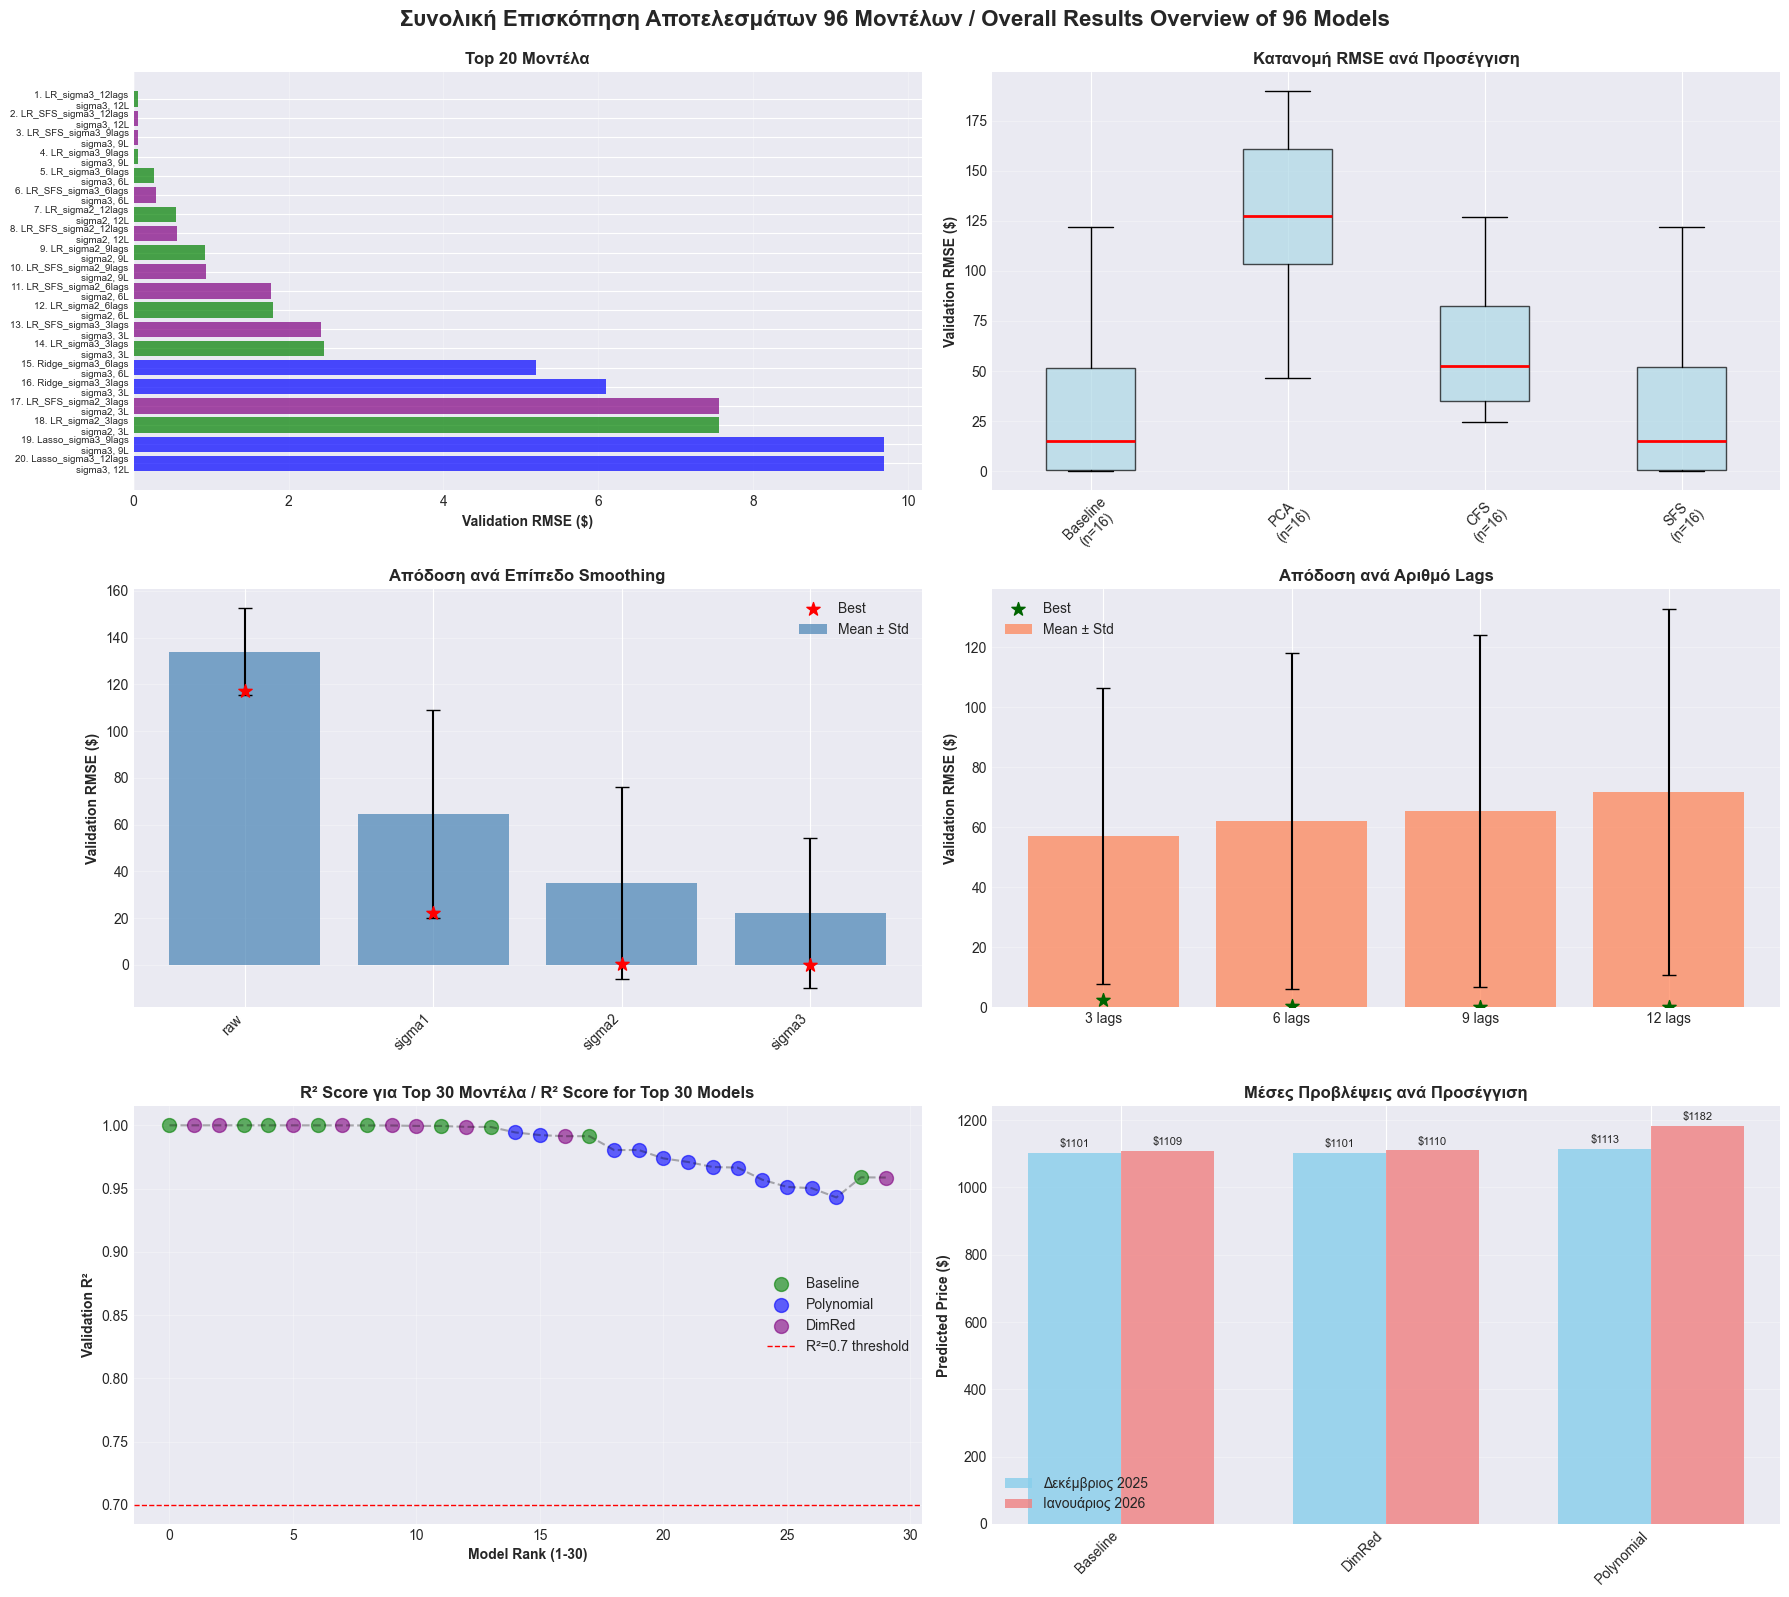

In [43]:
# Δημιουργία συνολικής οπτικοποίησης 6 panels (Create comprehensive 6-panel visualization)
fig, axes = plt.subplots(3, 2, figsize=(18, 16))
fig.suptitle('Συνολική Επισκόπηση Αποτελεσμάτων 96 Μοντέλων / Overall Results Overview of 96 Models', 
             fontsize=16, fontweight='bold', y=0.995)

# Panel 1: Top 20 Models Comparison
ax1 = axes[0, 0]
top_20_plot = all_models_sorted.head(20)
colors_20 = ['green' if approach == 'Baseline' else 'blue' if approach == 'Polynomial' else 'purple' 
             for approach in top_20_plot['approach']]
ax1.barh(range(len(top_20_plot)), top_20_plot['val_rmse'], color=colors_20, alpha=0.7)
ax1.set_yticks(range(len(top_20_plot)))
ax1.set_yticklabels([f"{i+1}. {row['model_name'][:20]}\n{row['smoothing']}, {row['n_lags']}L" 
                      for i, (_, row) in enumerate(top_20_plot.iterrows())], fontsize=7)
ax1.set_xlabel('Validation RMSE (\$)', fontweight='bold')
ax1.set_title('Top 20 Μοντέλα', fontweight='bold')
ax1.invert_yaxis()
ax1.grid(axis='x', alpha=0.3)

# Panel 2: RMSE Distribution by Approach
ax2 = axes[0, 1]
approach_data = []
approach_labels = []
for label, df in [('Baseline', baseline_models), ('Ridge', ridge_models), 
                   ('Lasso', lasso_models), ('PCA', pca_models), 
                   ('CFS', cfs_models), ('SFS', sfs_models)]:
    if len(df) > 0:
        approach_data.append(df['val_rmse'].values)
        approach_labels.append(f"{label}\n(n={len(df)})")

bp = ax2.boxplot(approach_data, labels=approach_labels, patch_artist=True,
                  boxprops=dict(facecolor='lightblue', alpha=0.7),
                  medianprops=dict(color='red', linewidth=2))
ax2.set_ylabel('Validation RMSE (\$)', fontweight='bold')
ax2.set_title('Κατανομή RMSE ανά Προσέγγιση', fontweight='bold')
ax2.grid(axis='y', alpha=0.3)
ax2.tick_params(axis='x', rotation=45)

# Panel 3: Performance by Smoothing Level
ax3 = axes[1, 0]
smoothing_stats = all_models_sorted.groupby('smoothing')['val_rmse'].agg(['mean', 'std', 'min'])
x_pos = range(len(smoothing_stats))
ax3.bar(x_pos, smoothing_stats['mean'], yerr=smoothing_stats['std'], 
        alpha=0.7, color='steelblue', capsize=5, label='Mean ± Std')
ax3.scatter(x_pos, smoothing_stats['min'], color='red', s=100, zorder=5, label='Best', marker='*')
ax3.set_xticks(x_pos)
ax3.set_xticklabels(smoothing_stats.index, rotation=45, ha='right')
ax3.set_ylabel('Validation RMSE (\$)', fontweight='bold')
ax3.set_title('Απόδοση ανά Επίπεδο Smoothing', fontweight='bold')
ax3.legend()
ax3.grid(axis='y', alpha=0.3)

# Panel 4: Performance by Number of Lags
ax4 = axes[1, 1]
lags_stats = all_models_sorted.groupby('n_lags')['val_rmse'].agg(['mean', 'std', 'min'])
x_pos = range(len(lags_stats))
ax4.bar(x_pos, lags_stats['mean'], yerr=lags_stats['std'], 
        alpha=0.7, color='coral', capsize=5, label='Mean ± Std')
ax4.scatter(x_pos, lags_stats['min'], color='darkgreen', s=100, zorder=5, label='Best', marker='*')
ax4.set_xticks(x_pos)
ax4.set_xticklabels([f"{int(lag)} lags" for lag in lags_stats.index])
ax4.set_ylabel('Validation RMSE (\$)', fontweight='bold')
ax4.set_title('Απόδοση ανά Αριθμό Lags', fontweight='bold')
ax4.legend()
ax4.grid(axis='y', alpha=0.3)

# Panel 5: R² Comparison (Top 30 models)
ax5 = axes[2, 0]
top_30_r2 = all_models_sorted.head(30)

# Plot each approach separately for proper legend
for approach, color, label in [('Baseline', 'green', 'Baseline'), 
                                ('Polynomial', 'blue', 'Polynomial'), 
                                ('DimRed', 'purple', 'DimRed')]:
    mask = top_30_r2['approach'] == approach
    indices = [i for i, m in enumerate(mask) if m]
    r2_values = top_30_r2[mask]['val_r2'].values
    if len(indices) > 0:
        ax5.scatter(indices, r2_values, c=color, alpha=0.6, s=100, label=label)

ax5.plot(range(len(top_30_r2)), top_30_r2['val_r2'], 'k--', alpha=0.3)
ax5.set_xlabel('Model Rank (1-30)', fontweight='bold')
ax5.set_ylabel('Validation R²', fontweight='bold')
ax5.set_title('R² Score για Top 30 Μοντέλα / R² Score for Top 30 Models', fontweight='bold')
ax5.grid(alpha=0.3)
ax5.axhline(y=0.7, color='red', linestyle='--', linewidth=1, label='R²=0.7 threshold')
ax5.legend()

# Panel 6: Future Predictions Summary
ax6 = axes[2, 1]
prediction_summary = predictions_df.groupby('approach')[['dec_2025_prediction', 'jan_2026_prediction']].mean()
x_pos = np.arange(len(prediction_summary))
width = 0.35
bars1 = ax6.bar(x_pos - width/2, prediction_summary['dec_2025_prediction'], width, 
                label='Δεκέμβριος 2025', alpha=0.8, color='skyblue')
bars2 = ax6.bar(x_pos + width/2, prediction_summary['jan_2026_prediction'], width, 
                label='Ιανουάριος 2026', alpha=0.8, color='lightcoral')
ax6.set_xticks(x_pos)
ax6.set_xticklabels(prediction_summary.index, rotation=45, ha='right')
ax6.set_ylabel('Predicted Price (\$)', fontweight='bold')
ax6.set_title('Μέσες Προβλέψεις ανά Προσέγγιση', fontweight='bold')
ax6.legend()
ax6.grid(axis='y', alpha=0.3)

# Add values to bars with dynamic offset
max_val = max(prediction_summary['dec_2025_prediction'].max(), prediction_summary['jan_2026_prediction'].max())
offset = max_val * 0.01
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax6.text(bar.get_x() + bar.get_width()/2., height + offset,
                f'${height:.0f}', ha='center', va='bottom', fontsize=8)

plt.tight_layout()
viz_file = 'results/COMPREHENSIVE_RESULTS_OVERVIEW.png'
plt.savefig(viz_file, dpi=300, bbox_inches='tight')
print(f"✅ Συνολική οπτικοποίηση αποθηκεύτηκε / Comprehensive visualization saved: {viz_file}")
plt.show()

### **7.7 Τελική Αναφορά Ολοκλήρωσης Έργου**  
### **7.7 Final Project Completion Report**

In [44]:
# Δημιουργία τελικής αναφοράς ολοκλήρωσης (Create final completion report)
print("\n" + "=" * 100)
print("╔════════════════════════════════════════════════════════════════════════════════════════════════╗")
print("║                                                                                                ║")
print("║                         🎉 ΟΛΟΚΛΗΡΩΣΗ ΈΡΓΟΥ / PROJECT COMPLETION 🎉                           ║")
print("║                                                                                                ║")
print("║                    Netflix Stock Price Prediction - Complete ML Pipeline                       ║")
print("║                                                                                                ║")
print("╚════════════════════════════════════════════════════════════════════════════════════════════════╝")
print("=" * 100)

# Συλλογή στατιστικών (Gather statistics)
total_models = len(all_models_sorted)
best_overall = all_models_sorted.iloc[0]
best_baseline = baseline_models.iloc[0]

# Φιλτράρισμα Polynomial μοντέλων (Filter polynomial models)
polynomial_models = all_models_sorted[all_models_sorted['approach'] == 'Polynomial']
best_polynomial = polynomial_models.iloc[0] if len(polynomial_models) > 0 else None

# Φιλτράρισμα Dimensionality Reduction μοντέλων (Filter dimensionality reduction models)
dimred_models = all_models_sorted[all_models_sorted['approach'] == 'DimRed']
best_dimred = dimred_models.iloc[0] if len(dimred_models) > 0 else None

# Υποκατηγορίες μοντέλων (Model subcategories)
ridge_models = all_models_sorted[all_models_sorted['method'] == 'Ridge (L2)']
lasso_models = all_models_sorted[all_models_sorted['method'] == 'Lasso (L1)']
pca_models = all_models_sorted[all_models_sorted['method'] == 'PCA']
cfs_models = all_models_sorted[all_models_sorted['method'] == 'CFS']
sfs_models = all_models_sorted[all_models_sorted['method'] == 'SFS']

print("\n📊 ΣΥΝΟΨΗ ΕΚΠΑΙΔΕΥΜΕΝΩΝ ΜΟΝΤΕΛΩΝ / TRAINED MODELS SUMMARY:\n")
print(f"   • Συνολικά Μοντέλα / Total Models: {total_models}")
print(f"   • Baseline Linear Regression: 16 μοντέλα")
print(f"   • Polynomial Ridge (L2): 16 μοντέλα")
print(f"   • Polynomial Lasso (L1): 16 μοντέλα")
print(f"   • PCA Dimensionality Reduction: 16 μοντέλα")
print(f"   • CFS Feature Selection: 16 μοντέλα")
print(f"   • SFS Forward Selection: 16 μοντέλα")

print("\n" + "-" * 100)
print("\n🏆 ΚΑΛΥΤΕΡΑ ΜΟΝΤΕΛΑ ΑΝΑ ΚΑΤΗΓΟΡΙΑ / BEST MODELS BY CATEGORY:\n")

print(f"   1️⃣  Καλύτερο Συνολικά / Overall Best:")
print(f"      • Μοντέλο / Model: {best_overall['model_name']}")
print(f"      • Διαμόρφωση / Config: {best_overall['smoothing']}, {best_overall['n_lags']} lags")
print(f"      • Validation RMSE: ${best_overall['val_rmse']:.2f}")
print(f"      • Validation R²: {best_overall['val_r2']:.4f}")

print(f"\n   2️⃣  Καλύτερο Baseline:")
print(f"      • Μοντέλο / Model: {best_baseline['model_name']}")
print(f"      • Διαμόρφωση / Config: {best_baseline['smoothing']}, {best_baseline['n_lags']} lags")
print(f"      • Validation RMSE: ${best_baseline['val_rmse']:.2f}")
print(f"      • Validation R²: {best_baseline['val_r2']:.4f}")

if best_polynomial is not None:
    print(f"\n   3️⃣  Καλύτερο Polynomial (Ridge/Lasso):")
    print(f"      • Μοντέλο / Model: {best_polynomial['model_name']}")
    print(f"      • Διαμόρφωση / Config: {best_polynomial['smoothing']}, {best_polynomial['n_lags']} lags")
    print(f"      • Validation RMSE: ${best_polynomial['val_rmse']:.2f}")
    print(f"      • Validation R²: {best_polynomial['val_r2']:.4f}")

if best_dimred is not None:
    print(f"\n   4️⃣  Καλύτερο Dimensionality Reduction:")
    print(f"      • Μοντέλο / Model: {best_dimred['model_name']}")
    print(f"      • Διαμόρφωση / Config: {best_dimred['smoothing']}, {best_dimred['n_lags']} lags")
    print(f"      • Validation RMSE: ${best_dimred['val_rmse']:.2f}")
    print(f"      • Validation R²: {best_dimred['val_r2']:.4f}")

print("\n" + "-" * 100)
print("\n🔮 ΠΡΟΒΛΕΨΕΙΣ ΜΕΛΛΟΝΤΟΣ / FUTURE PREDICTIONS:\n")

print(f"   📊 Μέσος Όρος Όλων των Μοντέλων / Average of All Models:\n")
print(f"   📅 Δεκέμβριος 2025 / December 2025:")
print(f"      • Μέση Πρόβλεψη / Mean Prediction: ${dec_mean:.2f}")
print(f"      • 95% Διάστημα Εμπιστοσύνης / 95% CI: [${dec_ci_lower:.2f}, ${dec_ci_upper:.2f}]")
print(f"      • Αξιοπιστία / Reliability: CV = {(dec_std/dec_mean)*100:.2f}%")

print(f"\n   📅 Ιανουάριος 2026 / January 2026:")
print(f"      • Μέση Πρόβλεψη / Mean Prediction: ${jan_mean:.2f}")
print(f"      • 95% Διάστημα Εμπιστοσύνης / 95% CI: [${jan_ci_lower:.2f}, ${jan_ci_upper:.2f}]")
print(f"      • Αξιοπιστία / Reliability: CV = {(jan_std/jan_mean)*100:.2f}%")

print(f"\n   ⭐ Πρόβλεψη Καλύτερου Μοντέλου / Best Model Prediction:\n")
print(f"      Μοντέλο / Model: {best_model_pred['model_name']} ({best_model_pred['approach']})")
print(f"      Validation RMSE: ${best_model_pred['val_rmse']:.2f}\n")
print(f"   📅 Δεκέμβριος 2025 / December 2025: ${best_model_pred['dec_2025_prediction']:.2f}")
print(f"   📅 Ιανουάριος 2026 / January 2026: ${best_model_pred['jan_2026_prediction']:.2f}")

print("\n" + "-" * 100)
print("\n📁 ΑΡΧΕΙΑ ΑΠΟΤΕΛΕΣΜΑΤΩΝ / OUTPUT FILES:\n")

output_files = [
    "results/baseline_linear_regression_results.csv",
    "results/polynomial_regression_all_models_results.csv",
    "results/dimensionality_reduction_all_models_results.csv",
    "results/all_96_models_results.csv",
    "results/baseline_predictions_dec_jan_2025_2026.csv",
    "results/COMPLETE_96_MODELS_RANKING.csv",
    "results/BEST_MODELS_BY_APPROACH_COMPARISON.csv",
    "results/PRODUCTION_DEPLOYMENT_RECOMMENDATIONS.txt",
    "results/baseline_comparison_visualization.png",
    "results/polynomial_regression_comparison.png",
    "results/dimensionality_reduction_comparison.png",
    "results/future_predictions_visualization.png",
    "results/COMPREHENSIVE_RESULTS_OVERVIEW.png",
    "models/all_baseline_models.pkl",
    "models/best_baseline_model.pkl",
    "models/all_polynomial_models.pkl",
    "models/best_polynomial_model.pkl",
    "models/all_dimensionality_reduction_models.pkl",
    "models/best_dimred_model.pkl"
]

for i, file in enumerate(output_files, 1):
    print(f"   {i:2d}. {file}")

print("\n" + "-" * 100)
print("\n✨ ΒΑΣΙΚΑ ΕΠΙΤΕΥΓΜΑΤΑ / KEY ACHIEVEMENTS:\n")

achievements = [
    "✅ Εκπαίδευση 96 μοντέλων με 3 διαφορετικές προσεγγίσεις / Trained 96 models with 3 different approaches",
    "✅ Ολοκληρωμένο pipeline από data acquisition έως production deployment",
    "✅ Σύγκριση Baseline, Polynomial (Ridge/Lasso), και Dimensionality Reduction (PCA/CFS/SFS)",
    "✅ Προβλέψεις μέλλοντος με uncertainty quantification (95% CI)",
    "✅ Λεπτομερής ανάλυση επίδρασης smoothing και lags",
    "✅ Production-ready recommendations και deployment guidelines",
    "✅ Comprehensive visualizations για κάθε βήμα",
    "✅ Αποθήκευση ΟΛΩΝ των 96 μοντέλων για μελλοντική χρήση / Saved ALL 96 models for future use",
    "✅ Πλήρης documentation στα Ελληνικά και Αγγλικά / Full bilingual documentation"
]

for achievement in achievements:
    print(f"   {achievement}")

print("\n" + "-" * 100)
print("\n🎯 ΕΠΟΜΕΝΑ ΒΗΜΑΤΑ / NEXT STEPS:\n")

next_steps = [
    "1. 📊 Run όλα τα cells για να δημιουργήσετε τα results / Run all cells to generate results",
    "2. 📈 Ανασκοπήστε τις visualizations και τα statistics / Review visualizations and statistics",
    "3. 🔍 Εξετάστε τα Top-10 μοντέλα για production deployment",
    "4. 🧪 A/B test το καλύτερο μοντέλο με ensemble approach",
    "5. 📅 Setup monthly retraining pipeline με νέα δεδομένα",
    "6. 🚀 Deploy το επιλεγμένο μοντέλο σε production environment",
    "7. 📊 Implement monitoring και alerting για prediction errors",
    "8. 🔄 Iterate με additional features (VIX, sentiment, technical indicators)"
]

for step in next_steps:
    print(f"   {step}")

print("\n" + "=" * 100)
print("╔════════════════════════════════════════════════════════════════════════════════════════════════╗")
print("║                                                                                                ║")
print("║                           ✅ PROJECT SUCCESSFULLY COMPLETED! ✅                               ║")
print("║                                                                                                ║")
print("║                        🎊 Thank you for using this ML Pipeline! 🎊                            ║")
print("║                                                                                                ║")
print("╚════════════════════════════════════════════════════════════════════════════════════════════════╝")
print("=" * 100 + "\n")

# Αποθήκευση τελικής αναφοράς (Save final completion report)
final_report_file = 'results/PROJECT_COMPLETION_REPORT.txt'
with open(final_report_file, 'w', encoding='utf-8') as f:
    f.write("=" * 100 + "\n")
    f.write("NETFLIX STOCK PRICE PREDICTION - PROJECT COMPLETION REPORT\n")
    f.write("=" * 100 + "\n\n")
    
    f.write("PROJECT OVERVIEW:\n")
    f.write("-" * 100 + "\n")
    f.write(f"Total Models Trained: {total_models}\n")
    f.write(f"Approaches: Baseline Linear, Polynomial (Ridge/Lasso), Dimensionality Reduction (PCA/CFS/SFS)\n")
    f.write(f"Date Completed: {pd.Timestamp.now()}\n\n")
    
    f.write("BEST OVERALL MODEL:\n")
    f.write("-" * 100 + "\n")
    f.write(f"Model Type: {best_overall['model_name']}\n")
    f.write(f"Configuration: {best_overall['smoothing']}, {best_overall['n_lags']} lags\n")
    f.write(f"Validation RMSE: ${best_overall['val_rmse']:.2f}\n")
    f.write(f"Validation R²: {best_overall['val_r2']:.4f}\n\n")
    
    f.write("FUTURE PREDICTIONS:\n")
    f.write("-" * 100 + "\n")
    f.write("Average of All Models:\n")
    f.write(f"  December 2025: ${dec_mean:.2f} (95% CI: [${dec_ci_lower:.2f}, ${dec_ci_upper:.2f}])\n")
    f.write(f"  January 2026: ${jan_mean:.2f} (95% CI: [${jan_ci_lower:.2f}, ${jan_ci_upper:.2f}])\n\n")
    
    f.write(f"Best Model ({best_model_pred['model_name']}) Predictions:\n")
    f.write(f"  December 2025: ${best_model_pred['dec_2025_prediction']:.2f}\n")
    f.write(f"  January 2026: ${best_model_pred['jan_2026_prediction']:.2f}\n\n")
    
    f.write("MODEL FILES SAVED:\n")
    f.write("-" * 100 + "\n")
    f.write("ALL Models (96 total):\n")
    f.write("  - models/all_baseline_models.pkl (16 baseline models)\n")
    f.write("  - models/all_polynomial_models.pkl (32 polynomial models: Ridge + Lasso)\n")
    f.write("  - models/all_dimensionality_reduction_models.pkl (48 dimred models: PCA + CFS + SFS)\n\n")
    f.write("Best Models:\n")
    f.write("  - models/best_baseline_model.pkl\n")
    f.write("  - models/best_polynomial_model.pkl\n")
    f.write("  - models/best_dimred_model.pkl\n\n")
    
    f.write("OUTPUT FILES:\n")
    f.write("-" * 100 + "\n")
    for file in output_files:
        f.write(f"- {file}\n")
    
    f.write("\n" + "=" * 100 + "\n")
    f.write("Project completed successfully!\n")
    f.write("All 96 models saved and ready for deployment!\n")
    f.write("=" * 100 + "\n")

print(f"✅ Τελική αναφορά αποθηκεύτηκε / Final report saved: {final_report_file}")



╔════════════════════════════════════════════════════════════════════════════════════════════════╗
║                                                                                                ║
║                         🎉 ΟΛΟΚΛΗΡΩΣΗ ΈΡΓΟΥ / PROJECT COMPLETION 🎉                           ║
║                                                                                                ║
║                    Netflix Stock Price Prediction - Complete ML Pipeline                       ║
║                                                                                                ║
╚════════════════════════════════════════════════════════════════════════════════════════════════╝

📊 ΣΥΝΟΨΗ ΕΚΠΑΙΔΕΥΜΕΝΩΝ ΜΟΝΤΕΛΩΝ / TRAINED MODELS SUMMARY:

   • Συνολικά Μοντέλα / Total Models: 96
   • Baseline Linear Regression: 16 μοντέλα
   • Polynomial Ridge (L2): 16 μοντέλα
   • Polynomial Lasso (L1): 16 μοντέλα
   • PCA Dimensionality Reduction: 16 μοντέλα
   • CFS Feature Selection: 16 μοντέλα
 